# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
import sys
import datetime
import logging

# nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

Autosaving every 60 seconds


In [3]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [4]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [5]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-03-27 14:04:15.220443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 14:04:15.320075: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 14:04:15.343161: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-27 14:04:15.858386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [7]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [8]:
import os
from os import listdir
from os.path import isfile, join

In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random

In [10]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [11]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [12]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [13]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [14]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

In [15]:
# !pip uninstall -y tensorboard-plugin-profile

In [16]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [22]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [23]:
# Define a global random seed
RANDOM_SEED = 42+1

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 256

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384

In [26]:
# A fixed number of features is used
FEATURES = 160

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the train dataset

In [29]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [30]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  
Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [31]:
# FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 28
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 28,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [32]:
TARGET_FEATURE_CNT = 256

In [33]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT)
XShape

(384, 256, 256)

In [34]:
import numpy as np
a = np.array([1,2,3,4])
a[[1,3]]

array([2, 4])

In [35]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
        
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [36]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-03-27 14:04:19.041678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 14:04:19.070614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 14:04:19.070777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 14:04:19.071502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(384, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(384, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have already tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

```
Todo: Create Image of netwrok structure
```

In [37]:
# from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization, UpSampling1D
from keras.layers import UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout

In [38]:
# Create the FPNWithFScaledInput model
# Infos about the feature pyramid: https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBigger",
      "VERSION": "2_FutureOnly",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, TARGET_FEATURE_CNT), name='inputTicksAndIndicators', dtype='float32')
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # Permute it to Conv over Features
  normalized = Permute((2, 1), name="PermuteInput")(normalized)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 128, 64)
feature_conv_attentioned.shape: (None, 128, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 64, 128)
feature_conv_attentioned.shape: (None, 64, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 32, 256)
feature_conv_attentioned.shape: (None, 32, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 512)
feature_conv_attentioned.shape: (None, 16, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 1024)
feature_conv_attentioned.shape: (None, 8, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 2048)
feature_conv_attentioned.shape: (None, 4, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 4, 256)
Building feat

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [39]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBigger_2_FutureOnly_GPU_256LB'

In [40]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-04,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [41]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [42]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [43]:
gc.collect()

9811

In [44]:
epoch_add = 31

In [45]:
CALLBACK_EVERY_N_BATCHES = 2000

In [46]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [47]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [48]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [49]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB20230327-140420'

In [50]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-03-27 14:04:20.656899: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-27 14:04:20.656925: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-27 14:04:20.656958: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-27 14:04:20.657128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-27 14:04:20.751636: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-27 14:04:20.751753: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [51]:
model.load_weights("/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_end/model.h5")

In [ ]:
stop

In [54]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [55]:
# model.fit(tfGenTraining,
#           epochs=1,
#           verbose = 1,
#           callbacks=[tensorboard_callback, cc])

In [56]:
model.optimizer.learning_rate = 5e-6

In [57]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5e-06>

In [58]:
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/3


INFO:root:File 'IE00B5377D42.csv' loaded, 531 left
INFO:root:File 'LU1681040223.csv' loaded, 530 left
INFO:root:File 'LU1681040819.csv' loaded, 529 left
INFO:root:File 'DE0002635273.csv' loaded, 528 left
INFO:root:File 'LU1686830909.csv' loaded, 527 left
INFO:root:File 'LU1681049109.csv' loaded, 526 left
INFO:root:File 'LU2356220926.csv' loaded, 525 left
INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 524 left
2023-03-25 13:16:08.098245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
INFO:root:File 'IE00BD1F4L37.csv' loaded, 523 left
2023-03-25 13:16:09.372217: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO:root:File 'IE00BYSX4739.csv' loaded, 522 left


      4/Unknown - 28s 265ms/step - loss: 2.1309e-05 - mae: 0.0023

2023-03-25 13:16:20.525244: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-25 13:16:20.525279: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      6/Unknown - 29s 345ms/step - loss: 1.6863e-05 - mae: 0.0021WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1311s vs `on_train_batch_end` time: 0.1383s). Check your callbacks.


      7/Unknown - 29s 333ms/step - loss: 1.5137e-05 - mae: 0.0020

INFO:root:File 'IE00B4L5YC18.csv' loaded, 521 left


     10/Unknown - 31s 474ms/step - loss: 1.1894e-05 - mae: 0.0019

INFO:root:File 'LU1079842321.csv' loaded, 520 left


     20/Unknown - 35s 415ms/step - loss: 2.5126e-05 - mae: 0.0020

INFO:root:File 'IE00B459R192.csv' loaded, 519 left


     58/Unknown - 46s 343ms/step - loss: 1.1172e-05 - mae: 0.0017

INFO:root:File 'IE00B53HP851.csv' loaded, 518 left


     64/Unknown - 49s 357ms/step - loss: 1.0337e-05 - mae: 0.0017

INFO:root:File 'LU1834986900.csv' loaded, 517 left


     68/Unknown - 52s 377ms/step - loss: 9.9105e-06 - mae: 0.0016

INFO:root:File 'IE000UQND7H4.csv' loaded, 516 left
INFO:root:File 'IE00BKX55S42.csv' loaded, 515 left


     72/Unknown - 54s 384ms/step - loss: 9.5589e-06 - mae: 0.0016

INFO:root:File 'LU2198883410.csv' loaded, 514 left


     74/Unknown - 55s 386ms/step - loss: 9.4675e-06 - mae: 0.0016

INFO:root:File 'LU1900066975.csv' loaded, 513 left


     89/Unknown - 61s 384ms/step - loss: 8.5695e-06 - mae: 0.0016

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


     99/Unknown - 64s 377ms/step - loss: 8.0343e-06 - mae: 0.0016

2023-03-25 13:16:56.917358: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-25 13:16:56.920038: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-03-25 13:16:57.255532: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 585793 callback api events and 588501 activity events. 
INFO:root:File 'IE00BMH5YF48.csv' loaded, 511 left
2023-03-25 13:17:02.136670: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-25 13:17:06.321169: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/bigdata/log/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB20230325-131550/plugins/profile/2023_03_25_13_17_02

2023-03-25 13:17:10.214034: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /content/bigdata/log/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB20

    102/Unknown - 82s 545ms/step - loss: 7.8841e-06 - mae: 0.0016

INFO:root:File 'DE0005933956.csv' loaded, 510 left


    104/Unknown - 84s 560ms/step - loss: 7.7925e-06 - mae: 0.0016

INFO:root:File 'DE0005933923.csv' loaded, 509 left


    106/Unknown - 86s 564ms/step - loss: 7.7130e-06 - mae: 0.0016

INFO:root:File 'IE000QUOSE01.csv' loaded, 508 left


    107/Unknown - 87s 572ms/step - loss: 7.6745e-06 - mae: 0.0016

INFO:root:File 'IE00BM8R0N95.csv' loaded, 507 left


    109/Unknown - 88s 568ms/step - loss: 7.6550e-06 - mae: 0.0016

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 506 left


    113/Unknown - 90s 563ms/step - loss: 7.7381e-06 - mae: 0.0016

INFO:root:File 'DE000A0Q4R69.csv' loaded, 505 left


    123/Unknown - 93s 541ms/step - loss: 7.4272e-06 - mae: 0.0016

INFO:root:File 'IE00BDDRF478.csv' loaded, 504 left


    128/Unknown - 95s 534ms/step - loss: 7.2691e-06 - mae: 0.0016

INFO:root:File 'FR0010869578.csv' loaded, 503 left


    153/Unknown - 103s 499ms/step - loss: 6.6972e-06 - mae: 0.0016

INFO:root:File 'LU1812090543.csv' loaded, 502 left


    156/Unknown - 105s 502ms/step - loss: 6.6453e-06 - mae: 0.0016

INFO:root:File 'LU1650492256.csv' loaded, 501 left


    161/Unknown - 107s 501ms/step - loss: 6.5554e-06 - mae: 0.0016

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 500 left


    193/Unknown - 116s 466ms/step - loss: 6.1588e-06 - mae: 0.0016

INFO:root:File 'IE00BNDS1P30.csv' loaded, 499 left


    201/Unknown - 119s 459ms/step - loss: 6.0920e-06 - mae: 0.0016

INFO:root:File 'IE00BLF7VW10.csv' loaded, 498 left


    204/Unknown - 120s 457ms/step - loss: 6.0667e-06 - mae: 0.0016

INFO:root:File 'IE00BD4TXV59.csv' loaded, 497 left


    217/Unknown - 123s 447ms/step - loss: 5.9873e-06 - mae: 0.0016

INFO:root:File 'LU1681044647.csv' loaded, 496 left


    227/Unknown - 127s 445ms/step - loss: 5.9409e-06 - mae: 0.0016

INFO:root:File 'LU0959210278.csv' loaded, 495 left


    232/Unknown - 130s 446ms/step - loss: 5.8842e-06 - mae: 0.0016

INFO:root:File 'DE000A0F5UH1.csv' loaded, 494 left


    236/Unknown - 132s 449ms/step - loss: 5.8647e-06 - mae: 0.0016

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 493 left


    242/Unknown - 135s 450ms/step - loss: 6.3789e-06 - mae: 0.0016

INFO:root:File 'LU1407888053.csv' loaded, 492 left


    255/Unknown - 139s 443ms/step - loss: 1.0772e-05 - mae: 0.0016

INFO:root:File 'LU1829218822.csv' loaded, 491 left


    290/Unknown - 150s 427ms/step - loss: 9.8667e-06 - mae: 0.0016

INFO:root:File 'IE00BMYDM794.csv' loaded, 490 left


    291/Unknown - 151s 427ms/step - loss: 9.8397e-06 - mae: 0.0016

INFO:root:File 'IE00B87RLX93.csv' loaded, 489 left


    293/Unknown - 152s 430ms/step - loss: 9.7865e-06 - mae: 0.0016

INFO:root:File 'IE000QNJAOX1.csv' loaded, 488 left


    294/Unknown - 153s 430ms/step - loss: 9.7679e-06 - mae: 0.0016

INFO:root:File 'IE00BJQRDM08.csv' loaded, 487 left


    303/Unknown - 155s 426ms/step - loss: 9.6141e-06 - mae: 0.0016

INFO:root:File 'DE000A0Q4R02.csv' loaded, 486 left


    305/Unknown - 158s 432ms/step - loss: 9.5762e-06 - mae: 0.0016

INFO:root:File 'IE00BWTNM966.csv' loaded, 485 left


    318/Unknown - 163s 428ms/step - loss: 9.3445e-06 - mae: 0.0016

INFO:root:File 'LU1681045537.csv' loaded, 484 left


    333/Unknown - 168s 426ms/step - loss: 9.0947e-06 - mae: 0.0016

INFO:root:File 'IE00B4WXJG34.csv' loaded, 483 left


    334/Unknown - 169s 426ms/step - loss: 9.0820e-06 - mae: 0.0016

INFO:root:File 'IE00BYM31M36.csv' loaded, 482 left


    338/Unknown - 172s 432ms/step - loss: 9.0145e-06 - mae: 0.0016

INFO:root:File 'IE00BFXR5W90.csv' loaded, 481 left


    352/Unknown - 177s 428ms/step - loss: 9.0730e-06 - mae: 0.0016

INFO:root:File 'IE00BFNM3B99.csv' loaded, 480 left


    357/Unknown - 179s 428ms/step - loss: 9.0158e-06 - mae: 0.0016

INFO:root:File 'IE0031442068.csv' loaded, 479 left


    364/Unknown - 183s 431ms/step - loss: 9.0061e-06 - mae: 0.0016

INFO:root:File 'IE00B4L5Y983.csv' loaded, 478 left


    365/Unknown - 184s 431ms/step - loss: 8.9911e-06 - mae: 0.0016

INFO:root:File 'LU0136240974.csv' loaded, 477 left


    379/Unknown - 191s 435ms/step - loss: 8.7728e-06 - mae: 0.0016

INFO:root:File 'IE00B7KMNP07.csv' loaded, 476 left


    380/Unknown - 193s 438ms/step - loss: 8.7659e-06 - mae: 0.0016

INFO:root:File 'DE0002635307.csv' loaded, 475 left


    417/Unknown - 205s 429ms/step - loss: 8.5044e-06 - mae: 0.0016

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 474 left


    433/Unknown - 211s 427ms/step - loss: 8.4610e-06 - mae: 0.0016

INFO:root:File 'IE00B1TXHL60.csv' loaded, 473 left


    452/Unknown - 218s 424ms/step - loss: 8.4138e-06 - mae: 0.0016

INFO:root:File 'DE000ETFL441.csv' loaded, 472 left


    457/Unknown - 221s 425ms/step - loss: 8.3549e-06 - mae: 0.0016

INFO:root:File 'LU1287023342.csv' loaded, 471 left


    461/Unknown - 224s 428ms/step - loss: 8.3088e-06 - mae: 0.0016

INFO:root:File 'IE00BCRY6003.csv' loaded, 470 left


    511/Unknown - 238s 415ms/step - loss: 7.8162e-06 - mae: 0.0016

INFO:root:File 'IE00BZ048462.csv' loaded, 469 left


    514/Unknown - 240s 416ms/step - loss: 7.7895e-06 - mae: 0.0016

INFO:root:File 'IE00BD3V0B10.csv' loaded, 468 left


    520/Unknown - 242s 415ms/step - loss: 7.7411e-06 - mae: 0.0016

INFO:root:File 'DE0002635299.csv' loaded, 467 left


    522/Unknown - 245s 419ms/step - loss: 7.7225e-06 - mae: 0.0016

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 466 left


    523/Unknown - 246s 420ms/step - loss: 7.7125e-06 - mae: 0.0016

INFO:root:File 'IE00B1FZS806.csv' loaded, 465 left


    527/Unknown - 249s 423ms/step - loss: 7.7065e-06 - mae: 0.0016

INFO:root:File 'IE00BKVL7D31.csv' loaded, 464 left


    543/Unknown - 254s 420ms/step - loss: 7.6178e-06 - mae: 0.0016

INFO:root:File 'IE00BYTRR970.csv' loaded, 463 left


    545/Unknown - 256s 421ms/step - loss: 7.5992e-06 - mae: 0.0016

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 462 left


    549/Unknown - 258s 422ms/step - loss: 7.5869e-06 - mae: 0.0016

INFO:root:File 'IE00BG8BCY43.csv' loaded, 461 left


    550/Unknown - 259s 422ms/step - loss: 7.5816e-06 - mae: 0.0016

INFO:root:File 'IE00BQT3WG13.csv' loaded, 460 left


    556/Unknown - 262s 423ms/step - loss: 7.6652e-06 - mae: 0.0016

INFO:root:File 'FR0011475078.csv' loaded, 459 left


    573/Unknown - 268s 421ms/step - loss: 7.5208e-06 - mae: 0.0016

INFO:root:File 'IE00B23D8S39.csv' loaded, 458 left


    580/Unknown - 271s 422ms/step - loss: 7.4922e-06 - mae: 0.0016

INFO:root:File 'IE00BYV1YH46.csv' loaded, 457 left


    590/Unknown - 275s 421ms/step - loss: 7.4388e-06 - mae: 0.0016

INFO:root:File 'LU2082997516.csv' loaded, 456 left


    595/Unknown - 277s 421ms/step - loss: 7.3992e-06 - mae: 0.0016

INFO:root:File 'IE0032077012.csv' loaded, 455 left


    604/Unknown - 282s 423ms/step - loss: 7.3362e-06 - mae: 0.0016

INFO:root:File 'LU2197908721.csv' loaded, 454 left


    605/Unknown - 282s 423ms/step - loss: 7.3293e-06 - mae: 0.0016

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 453 left


    612/Unknown - 285s 422ms/step - loss: 7.2831e-06 - mae: 0.0016

INFO:root:File 'IE00BFNM3N12.csv' loaded, 452 left


    615/Unknown - 286s 423ms/step - loss: 7.2635e-06 - mae: 0.0016

INFO:root:File 'IE00B23D9570.csv' loaded, 451 left


    618/Unknown - 289s 425ms/step - loss: 7.2421e-06 - mae: 0.0015

INFO:root:File 'IE00B5MJYC95.csv' loaded, 450 left


    626/Unknown - 293s 425ms/step - loss: 7.1853e-06 - mae: 0.0015

INFO:root:File 'LU2082997359.csv' loaded, 449 left


    639/Unknown - 297s 423ms/step - loss: 7.1428e-06 - mae: 0.0015

INFO:root:File 'DE000ETF7029.csv' loaded, 448 left


    640/Unknown - 297s 424ms/step - loss: 7.1372e-06 - mae: 0.0015

INFO:root:File 'LU0603942888.csv' loaded, 447 left


    641/Unknown - 299s 426ms/step - loss: 7.1306e-06 - mae: 0.0015

INFO:root:File 'IE00BYXPXL17.csv' loaded, 446 left


    650/Unknown - 303s 425ms/step - loss: 7.0728e-06 - mae: 0.0015

INFO:root:File 'IE0004U3TX15.csv' loaded, 445 left


    651/Unknown - 303s 425ms/step - loss: 7.0663e-06 - mae: 0.0015

INFO:root:File 'DE000ETFL482.csv' loaded, 444 left


    672/Unknown - 310s 422ms/step - loss: 6.9416e-06 - mae: 0.0015

INFO:root:File 'IE0001VXZTV7.csv' loaded, 443 left


    673/Unknown - 311s 422ms/step - loss: 6.9346e-06 - mae: 0.0015

INFO:root:File 'DE0006289473.csv' loaded, 442 left


    679/Unknown - 315s 425ms/step - loss: 6.8953e-06 - mae: 0.0015

INFO:root:File 'LU0480132876.csv' loaded, 441 left


    684/Unknown - 318s 426ms/step - loss: 6.8752e-06 - mae: 0.0015

INFO:root:File 'IE00B4K6B022.csv' loaded, 440 left


    701/Unknown - 324s 424ms/step - loss: 6.8091e-06 - mae: 0.0015

INFO:root:File 'DE000A0Q4R85.csv' loaded, 439 left


    709/Unknown - 327s 424ms/step - loss: 6.8125e-06 - mae: 0.0015

INFO:root:File 'LU1681047236.csv' loaded, 438 left


    716/Unknown - 330s 425ms/step - loss: 6.7921e-06 - mae: 0.0015

INFO:root:File 'IE00B466KX20.csv' loaded, 437 left


    724/Unknown - 334s 425ms/step - loss: 6.7686e-06 - mae: 0.0015

INFO:root:File 'IE00BYV1Y969.csv' loaded, 436 left


    729/Unknown - 336s 425ms/step - loss: 6.7522e-06 - mae: 0.0015

INFO:root:File 'IE00BJXRZ273.csv' loaded in retry loop, 435 left


    744/Unknown - 341s 423ms/step - loss: 6.7450e-06 - mae: 0.0015

INFO:root:File 'IE00BK5BC677.csv' loaded, 434 left


    746/Unknown - 342s 423ms/step - loss: 6.7449e-06 - mae: 0.0015

INFO:root:File 'IE00BZ0G8860.csv' loaded, 433 left


    759/Unknown - 347s 422ms/step - loss: 6.6889e-06 - mae: 0.0015

INFO:root:File 'LU0908501488.csv' loaded, 432 left


    766/Unknown - 349s 421ms/step - loss: 6.6631e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS350.csv' loaded, 431 left


    767/Unknown - 349s 421ms/step - loss: 6.6578e-06 - mae: 0.0015

INFO:root:File 'IE00B6YX5B26.csv' loaded, 430 left


    773/Unknown - 354s 424ms/step - loss: 6.6312e-06 - mae: 0.0015

INFO:root:File 'LU1829219390.csv' loaded, 429 left


    781/Unknown - 358s 424ms/step - loss: 6.6199e-06 - mae: 0.0015

INFO:root:File 'LU1681043599.csv' loaded, 428 left


    796/Unknown - 364s 424ms/step - loss: 6.5936e-06 - mae: 0.0015

INFO:root:File 'IE00BKP5L730.csv' loaded, 427 left


    801/Unknown - 366s 423ms/step - loss: 6.5764e-06 - mae: 0.0015

INFO:root:File 'LU0629460089.csv' loaded, 426 left


    813/Unknown - 370s 423ms/step - loss: 6.5423e-06 - mae: 0.0015

INFO:root:File 'IE00BF4G7076.csv' loaded, 425 left


    815/Unknown - 372s 424ms/step - loss: 6.5386e-06 - mae: 0.0015

INFO:root:File 'DE0006289382.csv' loaded, 424 left


    816/Unknown - 374s 426ms/step - loss: 6.5336e-06 - mae: 0.0015

INFO:root:File 'IE00BYPLS672.csv' loaded, 423 left


    837/Unknown - 381s 424ms/step - loss: 6.4976e-06 - mae: 0.0015

INFO:root:File 'LU2082996542.csv' loaded, 422 left


    841/Unknown - 383s 424ms/step - loss: 6.4824e-06 - mae: 0.0015

INFO:root:File 'IE000GOJO2A3.csv' loaded, 421 left


    842/Unknown - 383s 424ms/step - loss: 6.4768e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


    848/Unknown - 387s 425ms/step - loss: 6.4582e-06 - mae: 0.0015

INFO:root:File 'LU1602144575.csv' loaded, 419 left


    852/Unknown - 389s 426ms/step - loss: 6.4581e-06 - mae: 0.0015

INFO:root:File 'FR0010342592.csv' loaded, 418 left


    867/Unknown - 395s 425ms/step - loss: 6.4254e-06 - mae: 0.0015

INFO:root:File 'IE000L5NW549.csv' loaded, 417 left


    872/Unknown - 397s 425ms/step - loss: 6.4439e-06 - mae: 0.0015

INFO:root:File 'LU2244387457.csv' loaded, 416 left


    880/Unknown - 400s 424ms/step - loss: 6.4316e-06 - mae: 0.0015

INFO:root:File 'IE00BLSNMW37.csv' loaded, 415 left


    882/Unknown - 401s 425ms/step - loss: 6.4326e-06 - mae: 0.0015

INFO:root:File 'IE00BKLWY790.csv' loaded, 414 left


    883/Unknown - 402s 425ms/step - loss: 6.4308e-06 - mae: 0.0015

INFO:root:File 'IE00BYVZV757.csv' loaded, 413 left


    885/Unknown - 403s 426ms/step - loss: 6.4243e-06 - mae: 0.0015

INFO:root:File 'IE00BRKWGL70.csv' loaded, 412 left


    887/Unknown - 405s 427ms/step - loss: 6.4201e-06 - mae: 0.0015

INFO:root:File 'LU1681044480.csv' loaded, 411 left


    902/Unknown - 411s 426ms/step - loss: 6.3877e-06 - mae: 0.0015

INFO:root:File 'IE00B0M63284.csv' loaded, 410 left


    916/Unknown - 417s 426ms/step - loss: 7.1560e-06 - mae: 0.0016

INFO:root:File 'IE00BF2B0L69.csv' loaded, 409 left


    938/Unknown - 423s 423ms/step - loss: 3.1464e-04 - mae: 0.0017

INFO:root:File 'IE00BDDRDW15.csv' loaded, 408 left


    943/Unknown - 426s 423ms/step - loss: 3.1299e-04 - mae: 0.0017

INFO:root:File 'DE000ETF9033.csv' loaded in retry loop, 407 left


    952/Unknown - 429s 423ms/step - loss: 3.1007e-04 - mae: 0.0017

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 406 left


    959/Unknown - 432s 423ms/step - loss: 3.0788e-04 - mae: 0.0017

INFO:root:File 'LU1291098827.csv' loaded, 405 left


    966/Unknown - 435s 423ms/step - loss: 3.0569e-04 - mae: 0.0017

INFO:root:File 'IE00B5MTZM66.csv' loaded, 404 left


    972/Unknown - 438s 423ms/step - loss: 3.0384e-04 - mae: 0.0017

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 403 left


    973/Unknown - 438s 423ms/step - loss: 3.0353e-04 - mae: 0.0017

INFO:root:File 'IE00B802KR88.csv' loaded, 402 left


    974/Unknown - 441s 426ms/step - loss: 3.0323e-04 - mae: 0.0017

INFO:root:File 'IE00BMH5XY61.csv' loaded, 401 left


    975/Unknown - 442s 426ms/step - loss: 3.0292e-04 - mae: 0.0017

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 400 left


    978/Unknown - 443s 426ms/step - loss: 3.0201e-04 - mae: 0.0017

INFO:root:File 'IE00B4K48X80.csv' loaded, 399 left


    991/Unknown - 448s 426ms/step - loss: 2.9808e-04 - mae: 0.0017

INFO:root:File 'DE000A0H08N1.csv' loaded, 398 left


    993/Unknown - 451s 428ms/step - loss: 2.9749e-04 - mae: 0.0017

INFO:root:File 'IE00B8FHGS14.csv' loaded, 397 left


   1007/Unknown - 456s 427ms/step - loss: 2.9339e-04 - mae: 0.0017

INFO:root:File 'IE00BK5BQY34.csv' loaded, 396 left


   1028/Unknown - 463s 425ms/step - loss: 2.8745e-04 - mae: 0.0017

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


   1029/Unknown - 463s 424ms/step - loss: 2.8718e-04 - mae: 0.0017

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 394 left


   1046/Unknown - 471s 425ms/step - loss: 2.8256e-04 - mae: 0.0017

INFO:root:File 'IE00BYZTVV78.csv' loaded, 393 left


   1050/Unknown - 473s 425ms/step - loss: 2.8150e-04 - mae: 0.0017

INFO:root:File 'IE00BMCZLH06.csv' loaded, 392 left


   1064/Unknown - 477s 424ms/step - loss: 4.8526e-04 - mae: 0.0019

INFO:root:File 'IE00B3F81409.csv' loaded, 391 left


   1065/Unknown - 478s 424ms/step - loss: 5.3740e-04 - mae: 0.0019

INFO:root:File 'FR0007054358.csv' loaded, 390 left
INFO:root:File 'IE00BJQRDK83.csv' loaded, 389 left


   1067/Unknown - 482s 427ms/step - loss: 5.3640e-04 - mae: 0.0019

INFO:root:File 'DE000ETF7037.csv' loaded, 388 left


   1075/Unknown - 485s 427ms/step - loss: 5.4865e-04 - mae: 0.0019

INFO:root:File 'IE00BLF7VX27.csv' loaded, 387 left


   1088/Unknown - 489s 425ms/step - loss: 6.7157e-04 - mae: 0.0021

INFO:root:File 'IE00BYPC1H27.csv' loaded, 386 left


   1089/Unknown - 490s 426ms/step - loss: 6.7095e-04 - mae: 0.0021

INFO:root:File 'IE00B3YLTY66.csv' loaded, 385 left


   1095/Unknown - 493s 426ms/step - loss: 6.8923e-04 - mae: 0.0021

INFO:root:File 'LU1806495575.csv' loaded, 384 left


   1099/Unknown - 495s 426ms/step - loss: 6.8673e-04 - mae: 0.0021

INFO:root:File 'LU1681046691.csv' loaded, 383 left


   1100/Unknown - 497s 427ms/step - loss: 6.8611e-04 - mae: 0.0021

INFO:root:File 'IE00BJK9HD13.csv' loaded, 382 left


   1110/Unknown - 500s 427ms/step - loss: 6.7996e-04 - mae: 0.0021

INFO:root:File 'IE00B4M7GH52.csv' loaded, 381 left


   1122/Unknown - 505s 427ms/step - loss: 6.7478e-04 - mae: 0.0021

INFO:root:File 'LU1437015735.csv' loaded, 380 left


   1126/Unknown - 507s 427ms/step - loss: 6.7240e-04 - mae: 0.0021

INFO:root:File 'IE00BJK9H753.csv' loaded, 379 left


   1143/Unknown - 513s 425ms/step - loss: 6.6245e-04 - mae: 0.0021

INFO:root:File 'IE000BWKUES1.csv' loaded, 378 left


   1147/Unknown - 514s 425ms/step - loss: 6.6015e-04 - mae: 0.0021

INFO:root:File 'IE00BMH5Y871.csv' loaded, 377 left


   1150/Unknown - 515s 425ms/step - loss: 6.5844e-04 - mae: 0.0021

INFO:root:File 'LU0950674928.csv' loaded in retry loop, 376 left


   1151/Unknown - 516s 425ms/step - loss: 6.5787e-04 - mae: 0.0021

INFO:root:File 'DE000ETFL383.csv' loaded, 375 left
INFO:root:File 'LU1215454460.csv' loaded, 374 left


   1164/Unknown - 522s 426ms/step - loss: 6.5056e-04 - mae: 0.0021

INFO:root:File 'IE00BMDX0M10.csv' loaded, 373 left


   1165/Unknown - 523s 426ms/step - loss: 6.5001e-04 - mae: 0.0021

INFO:root:File 'DE000A2QP349.csv' loaded, 372 left


   1172/Unknown - 526s 426ms/step - loss: 6.4614e-04 - mae: 0.0021

INFO:root:File 'IE00B0M63623.csv' loaded, 371 left


   1173/Unknown - 526s 426ms/step - loss: 6.4559e-04 - mae: 0.0021

INFO:root:File 'IE00B5L8K969.csv' loaded, 370 left


   1179/Unknown - 531s 428ms/step - loss: 6.4233e-04 - mae: 0.0021

INFO:root:File 'IE00B74DQ490.csv' loaded, 369 left


   1188/Unknown - 535s 428ms/step - loss: 6.4339e-04 - mae: 0.0021

INFO:root:File 'LU1753045415.csv' loaded, 368 left


   1197/Unknown - 538s 428ms/step - loss: 6.3860e-04 - mae: 0.0021

INFO:root:File 'LU1681041890.csv' loaded, 367 left


   1203/Unknown - 541s 428ms/step - loss: 6.3543e-04 - mae: 0.0021

INFO:root:File 'DE000ETFL581.csv' loaded, 366 left


   1218/Unknown - 546s 426ms/step - loss: 6.2765e-04 - mae: 0.0021

INFO:root:File 'IE00B3VWM098.csv' loaded, 365 left


   1221/Unknown - 548s 427ms/step - loss: 6.2612e-04 - mae: 0.0021

INFO:root:File 'LU1681040736.csv' loaded, 364 left


   1227/Unknown - 552s 428ms/step - loss: 6.2307e-04 - mae: 0.0021

INFO:root:File 'IE00B1FZS244.csv' loaded, 363 left


   1235/Unknown - 556s 429ms/step - loss: 6.1907e-04 - mae: 0.0021

INFO:root:File 'IE00BKX55Q28.csv' loaded, 362 left


   1243/Unknown - 559s 429ms/step - loss: 6.1512e-04 - mae: 0.0021

INFO:root:File 'IE00B60SX287.csv' loaded, 361 left


   1252/Unknown - 563s 429ms/step - loss: 6.1072e-04 - mae: 0.0021

INFO:root:File 'IE00BYZK4883.csv' loaded, 360 left


   1264/Unknown - 568s 428ms/step - loss: 6.0495e-04 - mae: 0.0020

INFO:root:File 'IE00B1W57M07.csv' loaded, 359 left


   1294/Unknown - 578s 426ms/step - loss: 5.9104e-04 - mae: 0.0020

INFO:root:File 'IE00B23LNQ02.csv' loaded, 358 left


   1295/Unknown - 578s 426ms/step - loss: 5.9058e-04 - mae: 0.0020

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 357 left


   1298/Unknown - 582s 428ms/step - loss: 5.8923e-04 - mae: 0.0020

INFO:root:File 'IE000APK27S2.csv' loaded, 356 left


   1304/Unknown - 584s 428ms/step - loss: 5.8655e-04 - mae: 0.0020

INFO:root:File 'IE00BP3QZ601.csv' loaded, 355 left


   1312/Unknown - 587s 428ms/step - loss: 5.8299e-04 - mae: 0.0020

INFO:root:File 'IE00BMFNWC33.csv' loaded, 354 left


   1317/Unknown - 589s 427ms/step - loss: 5.8080e-04 - mae: 0.0020

INFO:root:File 'LU1390062831.csv' loaded, 353 left


   1320/Unknown - 591s 428ms/step - loss: 5.7949e-04 - mae: 0.0020

INFO:root:File 'IE00BYVJRR92.csv' loaded, 352 left


   1344/Unknown - 599s 426ms/step - loss: 5.6923e-04 - mae: 0.0020

INFO:root:File 'LU0671493277.csv' loaded, 351 left


   1346/Unknown - 601s 427ms/step - loss: 5.6839e-04 - mae: 0.0020

INFO:root:File 'IE00BYTRRC02.csv' loaded, 350 left


   1353/Unknown - 604s 427ms/step - loss: 5.6546e-04 - mae: 0.0020

INFO:root:File 'DE0005933972.csv' loaded, 349 left


   1363/Unknown - 609s 427ms/step - loss: 5.6134e-04 - mae: 0.0020

INFO:root:File 'IE00BGJWWY63.csv' loaded, 348 left


   1364/Unknown - 610s 428ms/step - loss: 5.6093e-04 - mae: 0.0020

INFO:root:File 'IE00BMZ17W23.csv' loaded, 347 left


   1365/Unknown - 610s 428ms/step - loss: 5.6053e-04 - mae: 0.0020

INFO:root:File 'LU1525418643.csv' loaded, 346 left


   1376/Unknown - 615s 428ms/step - loss: 5.5609e-04 - mae: 0.0020

INFO:root:File 'FR0011550185.csv' loaded, 345 left


   1379/Unknown - 617s 428ms/step - loss: 5.5489e-04 - mae: 0.0020

INFO:root:File 'LU2082998324.csv' loaded, 344 left


   1384/Unknown - 619s 428ms/step - loss: 5.5291e-04 - mae: 0.0020

INFO:root:File 'IE00B66F4759.csv' loaded, 343 left


   1392/Unknown - 622s 428ms/step - loss: 5.5019e-04 - mae: 0.0020

INFO:root:File 'IE00BFNM3M05.csv' loaded, 342 left


   1393/Unknown - 623s 428ms/step - loss: 5.4980e-04 - mae: 0.0020

INFO:root:File 'IE00B53QDK08.csv' loaded, 341 left


   1405/Unknown - 628s 428ms/step - loss: 5.4522e-04 - mae: 0.0020

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 340 left


   1406/Unknown - 629s 428ms/step - loss: 5.4483e-04 - mae: 0.0020

INFO:root:File 'LU1686832194.csv' loaded, 339 left


   1420/Unknown - 635s 428ms/step - loss: 5.3950e-04 - mae: 0.0020

INFO:root:File 'IE00B5MTYL84.csv' loaded, 338 left


   1425/Unknown - 638s 429ms/step - loss: 5.3762e-04 - mae: 0.0020

INFO:root:File 'LU1781540957.csv' loaded, 337 left


   1443/Unknown - 644s 428ms/step - loss: 5.3096e-04 - mae: 0.0020

INFO:root:File 'LU1681046006.csv' loaded, 336 left


   1456/Unknown - 649s 427ms/step - loss: 5.2624e-04 - mae: 0.0020

INFO:root:File 'IE0002MXIF34.csv' loaded, 335 left


   1457/Unknown - 649s 427ms/step - loss: 5.2588e-04 - mae: 0.0020

INFO:root:File 'LU1981859819.csv' loaded, 334 left
INFO:root:File 'LU1852212965.csv' loaded, 333 left


   1462/Unknown - 652s 428ms/step - loss: 5.2410e-04 - mae: 0.0020

INFO:root:File 'IE00BLSN7P11.csv' loaded, 332 left


   1472/Unknown - 655s 427ms/step - loss: 5.2250e-04 - mae: 0.0020

INFO:root:File 'LU0392496260.csv' loaded, 331 left


   1474/Unknown - 658s 428ms/step - loss: 5.2180e-04 - mae: 0.0020

INFO:root:File 'IE00BMDKNW35.csv' loaded, 330 left


   1476/Unknown - 659s 428ms/step - loss: 5.2110e-04 - mae: 0.0020

INFO:root:File 'IE00B1FZSD53.csv' loaded, 329 left


   1482/Unknown - 662s 429ms/step - loss: 5.1904e-04 - mae: 0.0020

INFO:root:File 'IE00BLCHJ534.csv' loaded, 328 left


   1485/Unknown - 664s 429ms/step - loss: 5.1804e-04 - mae: 0.0020

INFO:root:File 'IE00077FRP95.csv' loaded, 327 left


   1487/Unknown - 665s 429ms/step - loss: 5.1735e-04 - mae: 0.0020

INFO:root:File 'LU1079841273.csv' loaded, 326 left


   1488/Unknown - 666s 430ms/step - loss: 5.1700e-04 - mae: 0.0020

INFO:root:File 'LU0603940916.csv' loaded, 325 left
INFO:root:File 'IE00BKT1CS59.csv' loaded, 324 left


   1504/Unknown - 672s 430ms/step - loss: 5.1163e-04 - mae: 0.0020

INFO:root:File 'IE00BLCHJB90.csv' loaded, 323 left


   1508/Unknown - 674s 429ms/step - loss: 5.1028e-04 - mae: 0.0020

INFO:root:File 'IE000BPQIAA3.csv' loaded, 322 left


   1509/Unknown - 674s 429ms/step - loss: 5.0994e-04 - mae: 0.0020

INFO:root:File 'FR0011720911.csv' loaded, 321 left


   1514/Unknown - 677s 430ms/step - loss: 5.0828e-04 - mae: 0.0020

INFO:root:File 'LU2082997946.csv' loaded, 320 left


   1519/Unknown - 679s 430ms/step - loss: 5.0664e-04 - mae: 0.0020

INFO:root:File 'IE00BZ4BMM98.csv' loaded in retry loop, 319 left


   1528/Unknown - 683s 430ms/step - loss: 5.0370e-04 - mae: 0.0020

INFO:root:File 'IE00BQN1K786.csv' loaded, 318 left


   1540/Unknown - 687s 429ms/step - loss: 4.9981e-04 - mae: 0.0020

INFO:root:File 'IE00BN4Q1675.csv' loaded, 317 left


   1541/Unknown - 688s 429ms/step - loss: 4.9948e-04 - mae: 0.0020

INFO:root:File 'LU2056739464.csv' loaded, 316 left


   1547/Unknown - 690s 429ms/step - loss: 4.9756e-04 - mae: 0.0020

INFO:root:File 'LU1650491795.csv' loaded, 315 left


   1556/Unknown - 693s 429ms/step - loss: 4.9473e-04 - mae: 0.0020

INFO:root:File 'IE00B3S5XW04.csv' loaded, 314 left


   1560/Unknown - 696s 429ms/step - loss: 4.9347e-04 - mae: 0.0020

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 313 left


   1567/Unknown - 699s 429ms/step - loss: 4.9128e-04 - mae: 0.0020

INFO:root:File 'IE00B6YX5L24.csv' loaded, 312 left


   1568/Unknown - 701s 430ms/step - loss: 4.9097e-04 - mae: 0.0020

INFO:root:File 'IE00BFNM3C07.csv' loaded, 311 left


   1571/Unknown - 702s 430ms/step - loss: 4.9004e-04 - mae: 0.0020

INFO:root:File 'IE00BYMS5W68.csv' loaded, 310 left


   1575/Unknown - 704s 431ms/step - loss: 4.8880e-04 - mae: 0.0020

INFO:root:File 'LU0599612842.csv' loaded, 309 left


   1584/Unknown - 709s 431ms/step - loss: 4.8604e-04 - mae: 0.0020

INFO:root:File 'IE00BCBJF711.csv' loaded, 308 left


   1594/Unknown - 713s 430ms/step - loss: 4.8301e-04 - mae: 0.0020

INFO:root:File 'LU1900068328.csv' loaded, 307 left


   1595/Unknown - 713s 430ms/step - loss: 4.8271e-04 - mae: 0.0020

INFO:root:File 'IE00BLRPN388.csv' loaded, 306 left


   1606/Unknown - 718s 431ms/step - loss: 4.7942e-04 - mae: 0.0020

INFO:root:File 'LU1799934903.csv' loaded, 305 left


   1611/Unknown - 720s 431ms/step - loss: 4.7795e-04 - mae: 0.0020

INFO:root:File 'IE00BD4TYG73.csv' loaded, 304 left


   1615/Unknown - 723s 431ms/step - loss: 4.7677e-04 - mae: 0.0020

INFO:root:File 'IE00B5MTY077.csv' loaded, 303 left


   1641/Unknown - 732s 430ms/step - loss: 4.6931e-04 - mae: 0.0019

INFO:root:File 'DE000A0D8Q49.csv' loaded, 302 left


   1644/Unknown - 734s 431ms/step - loss: 4.6847e-04 - mae: 0.0019

INFO:root:File 'NL0010408704.csv' loaded, 301 left


   1648/Unknown - 737s 431ms/step - loss: 4.6734e-04 - mae: 0.0019

INFO:root:File 'DE0006289499.csv' loaded, 300 left


   1649/Unknown - 739s 432ms/step - loss: 4.6706e-04 - mae: 0.0019

INFO:root:File 'DE0005933931.csv' loaded, 299 left


   1658/Unknown - 744s 433ms/step - loss: 4.6455e-04 - mae: 0.0019

INFO:root:File 'IE00BYTRR863.csv' loaded, 298 left


   1678/Unknown - 751s 432ms/step - loss: 4.5906e-04 - mae: 0.0019

INFO:root:File 'DE000ETFL557.csv' loaded, 297 left


   1693/Unknown - 756s 431ms/step - loss: 4.5705e-04 - mae: 0.0019

INFO:root:File 'IE00BFD2H405.csv' loaded, 296 left


   1705/Unknown - 760s 430ms/step - loss: 4.5387e-04 - mae: 0.0019

INFO:root:File 'LU1650489385.csv' loaded, 295 left


   1713/Unknown - 765s 431ms/step - loss: 4.5176e-04 - mae: 0.0019

INFO:root:File 'LU1974696418.csv' loaded, 294 left


   1714/Unknown - 765s 431ms/step - loss: 4.5150e-04 - mae: 0.0019

INFO:root:File 'IE00B77D4428.csv' loaded, 293 left


   1717/Unknown - 768s 432ms/step - loss: 4.5072e-04 - mae: 0.0019

INFO:root:File 'IE00BHBFDF83.csv' loaded, 292 left


   1718/Unknown - 768s 432ms/step - loss: 4.5046e-04 - mae: 0.0019

INFO:root:File 'LU1681041205.csv' loaded, 291 left


   1735/Unknown - 775s 432ms/step - loss: 4.4609e-04 - mae: 0.0019

INFO:root:File 'LU1829218749.csv' loaded, 290 left


   1768/Unknown - 787s 430ms/step - loss: 4.3783e-04 - mae: 0.0019

INFO:root:File 'DE000A0H08J9.csv' loaded, 289 left


   1779/Unknown - 792s 430ms/step - loss: 4.3514e-04 - mae: 0.0019

INFO:root:File 'LU1861134382.csv' loaded, 288 left


   1791/Unknown - 796s 430ms/step - loss: 4.3283e-04 - mae: 0.0019

INFO:root:File 'LU1377382368.csv' loaded, 287 left


   1792/Unknown - 797s 430ms/step - loss: 4.3259e-04 - mae: 0.0019

INFO:root:File 'LU0488317701.csv' loaded, 286 left


   1806/Unknown - 803s 430ms/step - loss: 4.2927e-04 - mae: 0.0019

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 285 left


   1807/Unknown - 803s 430ms/step - loss: 4.2903e-04 - mae: 0.0019

INFO:root:File 'IE00BFNM3F38.csv' loaded, 284 left


   1808/Unknown - 804s 430ms/step - loss: 4.2880e-04 - mae: 0.0019

INFO:root:File 'IE00B4WXJH41.csv' loaded, 283 left


   1812/Unknown - 807s 431ms/step - loss: 4.2786e-04 - mae: 0.0019

INFO:root:File 'IE00B6YX5C33.csv' loaded, 282 left


   1829/Unknown - 814s 430ms/step - loss: 4.2394e-04 - mae: 0.0019

INFO:root:File 'LU1602144906.csv' loaded, 281 left


   1835/Unknown - 816s 430ms/step - loss: 4.2259e-04 - mae: 0.0019

INFO:root:File 'IE00BDFK1573.csv' loaded, 280 left


   1845/Unknown - 820s 430ms/step - loss: 4.2037e-04 - mae: 0.0019

INFO:root:File 'LU1900065811.csv' loaded, 279 left


   1860/Unknown - 825s 430ms/step - loss: 4.8746e-04 - mae: 0.0020

INFO:root:File 'IE00B539F030.csv' loaded, 278 left


   1862/Unknown - 828s 430ms/step - loss: 4.8694e-04 - mae: 0.0020

INFO:root:File 'DE000ETF9090.csv' loaded, 277 left


   1867/Unknown - 830s 430ms/step - loss: 4.8566e-04 - mae: 0.0020

INFO:root:File 'IE00BFTWP510.csv' loaded, 276 left


   1878/Unknown - 834s 430ms/step - loss: 4.8284e-04 - mae: 0.0020

INFO:root:File 'LU1280303014.csv' loaded, 275 left


   1884/Unknown - 837s 430ms/step - loss: 4.8132e-04 - mae: 0.0020

INFO:root:File 'IE00B0M62Q58.csv' loaded, 274 left


   1890/Unknown - 840s 431ms/step - loss: 4.7980e-04 - mae: 0.0020

INFO:root:File 'DE000A0Q4R28.csv' loaded, 273 left


   1908/Unknown - 847s 430ms/step - loss: 4.7534e-04 - mae: 0.0020

INFO:root:File 'IE00B0M62X26.csv' loaded, 272 left


   1919/Unknown - 853s 431ms/step - loss: 4.7264e-04 - mae: 0.0020

INFO:root:File 'IE00B3VWN179.csv' loaded, 271 left


   1928/Unknown - 857s 431ms/step - loss: 4.7045e-04 - mae: 0.0020

INFO:root:File 'IE00BYTH5R14.csv' loaded, 270 left


   1929/Unknown - 857s 431ms/step - loss: 4.7021e-04 - mae: 0.0020

INFO:root:File 'IE00BMFNW783.csv' loaded, 269 left
INFO:root:File 'DE000ETFL029.csv' loaded, 268 left


   1936/Unknown - 862s 431ms/step - loss: 4.6853e-04 - mae: 0.0020

INFO:root:File 'LU1861138961.csv' loaded, 267 left


   1937/Unknown - 862s 432ms/step - loss: 4.6829e-04 - mae: 0.0020

INFO:root:File 'IE00BG5J1M21.csv' loaded, 266 left


   1954/Unknown - 868s 431ms/step - loss: 4.6427e-04 - mae: 0.0019

INFO:root:File 'IE00BP2C1V62.csv' loaded, 265 left


   1955/Unknown - 868s 431ms/step - loss: 4.6403e-04 - mae: 0.0019

INFO:root:File 'IE00BNGFMY78.csv' loaded, 264 left


   1961/Unknown - 871s 431ms/step - loss: 4.6263e-04 - mae: 0.0019

INFO:root:File 'IE00B4X9L533.csv' loaded, 263 left


   1962/Unknown - 873s 431ms/step - loss: 4.6240e-04 - mae: 0.0019

INFO:root:File 'IE00BCRY6557.csv' loaded, 262 left


   1966/Unknown - 875s 432ms/step - loss: 4.6146e-04 - mae: 0.0019

INFO:root:File 'LU2297533809.csv' loaded, 261 left


   1975/Unknown - 878s 431ms/step - loss: 4.5938e-04 - mae: 0.0019

INFO:root:File 'FR0010296061.csv' loaded, 260 left


   2000/Unknown - 887s 430ms/step - loss: 7.4477e-04 - mae: 0.0020

INFO:root:2023-03-25 13:30:40.432505
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_31_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_31_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_31_02000/w.pickle'
INFO:root:Did a gc collect: 0


   2009/Unknown - 890s 430ms/step - loss: 7.4212e-04 - mae: 0.0021

INFO:root:File 'IE00BN76Y761.csv' loaded, 259 left


   2017/Unknown - 893s 430ms/step - loss: 7.3919e-04 - mae: 0.0020

INFO:root:File 'IE00B1FZSC47.csv' loaded, 258 left


   2019/Unknown - 895s 430ms/step - loss: 0.0017 - mae: 0.0022  

INFO:root:File 'IE00BFXR5T61.csv' loaded, 257 left


   2027/Unknown - 898s 430ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B60SX170.csv' loaded, 256 left


   2035/Unknown - 902s 430ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU0721552973.csv' loaded in retry loop, 255 left


   2038/Unknown - 904s 431ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU1681045370.csv' loaded, 254 left


   2042/Unknown - 907s 431ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 253 left


   2046/Unknown - 909s 431ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B6YX5D40.csv' loaded, 252 left


   2049/Unknown - 911s 432ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2109786827.csv' loaded, 251 left


   2065/Unknown - 916s 431ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2090062949.csv' loaded, 250 left


   2078/Unknown - 920s 430ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B3B8PX14.csv' loaded, 249 left


   2099/Unknown - 928s 430ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B6TLBW47.csv' loaded, 248 left


   2100/Unknown - 929s 430ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2008763935.csv' loaded, 247 left


   2113/Unknown - 934s 429ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BYTH5T38.csv' loaded, 246 left


   2119/Unknown - 936s 429ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BYZK4776.csv' loaded, 245 left


   2121/Unknown - 937s 430ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU1686832277.csv' loaded, 244 left


   2126/Unknown - 939s 429ms/step - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU1602144229.csv' loaded, 243 left


   2127/Unknown - 940s 430ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE00BMH5YL08.csv' loaded, 242 left


   2128/Unknown - 941s 430ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 241 left


   2131/Unknown - 944s 430ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU1681043086.csv' loaded, 240 left


   2134/Unknown - 946s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU1169821292.csv' loaded, 239 left


   2137/Unknown - 948s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU1437018838.csv' loaded, 238 left


   2149/Unknown - 952s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU1681041627.csv' loaded, 237 left


   2163/Unknown - 958s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU2250132763.csv' loaded, 236 left


   2165/Unknown - 959s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE000L2ZNB07.csv' loaded, 235 left


   2166/Unknown - 959s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 234 left


   2173/Unknown - 962s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU0392496427.csv' loaded, 233 left


   2176/Unknown - 965s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 232 left


   2177/Unknown - 965s 431ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU1681046857.csv' loaded, 231 left


   2179/Unknown - 967s 432ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE00BJXRT698.csv' loaded, 230 left


   2181/Unknown - 968s 432ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'LU1829218319.csv' loaded, 229 left


   2184/Unknown - 970s 432ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'FR0010245514.csv' loaded in retry loop, 228 left


   2201/Unknown - 977s 432ms/step - loss: 0.0016 - mae: 0.0022

INFO:root:File 'IE00BFWXDY69.csv' loaded, 227 left


   2225/Unknown - 984s 431ms/step - loss: 0.0021 - mae: 0.0022

INFO:root:File 'IE00BNG8L278.csv' loaded, 226 left


   2228/Unknown - 986s 431ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'DE000ETFL037.csv' loaded, 225 left


   2231/Unknown - 988s 431ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'IE000YDZG487.csv' loaded, 224 left


   2233/Unknown - 989s 431ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'IE00BCLWRD08.csv' loaded, 223 left


   2234/Unknown - 991s 432ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'LU1861137484.csv' loaded, 222 left


   2235/Unknown - 991s 432ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'LU1230561679.csv' loaded, 221 left


   2237/Unknown - 993s 432ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'IE00BM9GRM34.csv' loaded, 220 left


   2246/Unknown - 996s 432ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'DE000A0D8Q31.csv' loaded, 219 left


   2250/Unknown - 1000s 433ms/step - loss: 0.0046 - mae: 0.0026

INFO:root:File 'LU2023678282.csv' loaded, 218 left


   2263/Unknown - 1004s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BNG8L385.csv' loaded, 217 left


   2268/Unknown - 1006s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 216 left


   2272/Unknown - 1008s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE000KDY10O3.csv' loaded, 215 left


   2274/Unknown - 1009s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BK5BCH80.csv' loaded, 214 left


   2276/Unknown - 1010s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BLRPRR04.csv' loaded, 213 left


   2283/Unknown - 1012s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BDZZTM54.csv' loaded, 212 left


   2286/Unknown - 1014s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYYW2V44.csv' loaded, 211 left


   2287/Unknown - 1015s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYSZ5R67.csv' loaded in retry loop, 210 left


   2299/Unknown - 1019s 432ms/step - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYZK4669.csv' loaded, 209 left


   2310/Unknown - 1023s 431ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BD1F4M44.csv' loaded, 208 left


   2314/Unknown - 1025s 432ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'LU0496786574.csv' loaded, 207 left


   2318/Unknown - 1028s 432ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BKY59G90.csv' loaded, 206 left


   2325/Unknown - 1030s 432ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 205 left


   2332/Unknown - 1033s 432ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'LU0832435464.csv' loaded, 204 left


   2335/Unknown - 1035s 432ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'FR0007052782.csv' loaded, 203 left


   2336/Unknown - 1037s 433ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BHZPJ783.csv' loaded, 202 left


   2343/Unknown - 1041s 433ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00B1XNHC34.csv' loaded, 201 left


   2353/Unknown - 1045s 433ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 200 left


   2360/Unknown - 1048s 433ms/step - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 199 left


   2374/Unknown - 1053s 433ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU2265794276.csv' loaded in retry loop, 198 left


   2375/Unknown - 1054s 433ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00B6R52143.csv' loaded, 197 left


   2383/Unknown - 1058s 433ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'NL0010273801.csv' loaded, 196 left


   2384/Unknown - 1059s 433ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU1615092217.csv' loaded, 195 left


   2406/Unknown - 1066s 432ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 194 left


   2407/Unknown - 1067s 432ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00BYXVGY31.csv' loaded, 193 left


   2420/Unknown - 1072s 432ms/step - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU1220245556.csv' loaded, 192 left


   2438/Unknown - 1078s 431ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'DE000ETFL540.csv' loaded, 191 left


   2442/Unknown - 1079s 431ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 190 left


   2446/Unknown - 1081s 431ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B40B8R38.csv' loaded, 189 left


   2453/Unknown - 1084s 431ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 188 left


   2456/Unknown - 1086s 431ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B3FH7618.csv' loaded, 187 left


   2457/Unknown - 1087s 432ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU2244386053.csv' loaded, 186 left
INFO:root:File 'LU1931975152.csv' loaded, 185 left


   2458/Unknown - 1089s 432ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU2082999058.csv' loaded, 184 left


   2466/Unknown - 1092s 432ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BG0J4C88.csv' loaded, 183 left


   2470/Unknown - 1094s 432ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 182 left


   2474/Unknown - 1096s 432ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BLCHJH52.csv' loaded, 181 left


   2478/Unknown - 1097s 432ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 180 left


   2482/Unknown - 1100s 433ms/step - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU1291101555.csv' loaded, 179 left


   2486/Unknown - 1102s 433ms/step - loss: 0.0041 - mae: 0.0025

INFO:root:File 'DE000A0H08H3.csv' loaded, 178 left


   2495/Unknown - 1107s 433ms/step - loss: 0.0041 - mae: 0.0025

INFO:root:File 'IE000KPJJWM6.csv' loaded, 177 left


   2496/Unknown - 1107s 433ms/step - loss: 0.0041 - mae: 0.0025

INFO:root:File 'LU1974693662.csv' loaded, 176 left


   2498/Unknown - 1109s 433ms/step - loss: 0.0041 - mae: 0.0025

INFO:root:File 'IE00BHZPJ015.csv' loaded, 175 left


   2503/Unknown - 1111s 433ms/step - loss: 0.0067 - mae: 0.0028

INFO:root:File 'IE00BQN1K901.csv' loaded, 174 left


   2515/Unknown - 1115s 433ms/step - loss: 0.0122 - mae: 0.0035

INFO:root:File 'LU1481203070.csv' loaded, 173 left


   2520/Unknown - 1118s 433ms/step - loss: 0.0142 - mae: 0.0038

INFO:root:File 'LU1437016204.csv' loaded, 172 left


   2522/Unknown - 1119s 433ms/step - loss: 0.0144 - mae: 0.0039

INFO:root:File 'LU1953188833.csv' loaded, 171 left


   2530/Unknown - 1122s 433ms/step - loss: 0.0147 - mae: 0.0040

INFO:root:File 'LU1829219713.csv' loaded, 170 left


   2544/Unknown - 1127s 433ms/step - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1650488817.csv' loaded, 169 left


   2554/Unknown - 1131s 432ms/step - loss: 0.0189 - mae: 0.0047

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 168 left


   2557/Unknown - 1132s 432ms/step - loss: 0.0189 - mae: 0.0047

INFO:root:File 'LU1285960032.csv' loaded, 167 left


   2558/Unknown - 1133s 433ms/step - loss: 0.0189 - mae: 0.0047

INFO:root:File 'FR0007056841.csv' loaded, 166 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 165 left


   2559/Unknown - 1136s 434ms/step - loss: 0.0189 - mae: 0.0047

INFO:root:File 'LU1563454310.csv' loaded, 164 left


   2562/Unknown - 1138s 434ms/step - loss: 0.0189 - mae: 0.0047

INFO:root:File 'IE00B4LN9N13.csv' loaded, 163 left


   2578/Unknown - 1144s 433ms/step - loss: 0.0188 - mae: 0.0046

INFO:root:File 'LU2182388582.csv' loaded, 162 left


   2593/Unknown - 1148s 433ms/step - loss: 0.0187 - mae: 0.0046

INFO:root:File 'IE00BJRCLL96.csv' loaded, 161 left


   2598/Unknown - 1150s 433ms/step - loss: 0.0186 - mae: 0.0046

INFO:root:File 'LU0832436512.csv' loaded, 160 left


   2599/Unknown - 1152s 433ms/step - loss: 0.0186 - mae: 0.0046

INFO:root:File 'DE000A0Q4R36.csv' loaded, 159 left


   2602/Unknown - 1155s 434ms/step - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00BKSBGV72.csv' loaded, 158 left


   2603/Unknown - 1156s 434ms/step - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00B3VTML14.csv' loaded, 157 left


   2611/Unknown - 1160s 434ms/step - loss: 0.0185 - mae: 0.0046

INFO:root:File 'DE0006289465.csv' loaded, 156 left


   2615/Unknown - 1163s 435ms/step - loss: 0.0185 - mae: 0.0046

INFO:root:File 'IE00BSPLC413.csv' loaded, 155 left


   2617/Unknown - 1165s 435ms/step - loss: 0.0185 - mae: 0.0046

INFO:root:File 'IE0032895942.csv' loaded, 154 left


   2638/Unknown - 1173s 435ms/step - loss: 0.0183 - mae: 0.0046

INFO:root:File 'LU0392494992.csv' loaded, 153 left


   2671/Unknown - 1184s 433ms/step - loss: 0.0181 - mae: 0.0045

INFO:root:File 'FR0010361683.csv' loaded, 152 left


   2672/Unknown - 1186s 434ms/step - loss: 0.0181 - mae: 0.0045

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 151 left


   2702/Unknown - 1196s 433ms/step - loss: 0.0179 - mae: 0.0045

INFO:root:File 'LU1215451524.csv' loaded, 150 left


   2719/Unknown - 1202s 432ms/step - loss: 0.0178 - mae: 0.0045

INFO:root:File 'LU1327051279.csv' loaded, 149 left


   2741/Unknown - 1209s 431ms/step - loss: 0.0177 - mae: 0.0045

INFO:root:File 'LU1861132840.csv' loaded, 148 left


   2750/Unknown - 1212s 431ms/step - loss: 0.0176 - mae: 0.0045

INFO:root:File 'LU1681045024.csv' loaded, 147 left


   2754/Unknown - 1214s 431ms/step - loss: 0.0176 - mae: 0.0045

INFO:root:File 'IE00B5MTWY73.csv' loaded, 146 left


   2758/Unknown - 1217s 432ms/step - loss: 0.0175 - mae: 0.0045

INFO:root:File 'LU1437017350.csv' loaded, 145 left


   2760/Unknown - 1219s 432ms/step - loss: 0.0175 - mae: 0.0045

INFO:root:File 'IE00BK5BC891.csv' loaded, 144 left


   2763/Unknown - 1220s 432ms/step - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 143 left


   2764/Unknown - 1221s 432ms/step - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00B5MTYK77.csv' loaded, 142 left


   2768/Unknown - 1224s 432ms/step - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 141 left


   2769/Unknown - 1224s 433ms/step - loss: 0.0175 - mae: 0.0044

INFO:root:File 'DE000A0F5UE8.csv' loaded, 140 left


   2783/Unknown - 1230s 433ms/step - loss: 0.0174 - mae: 0.0044

INFO:root:File 'IE00BCLWRB83.csv' loaded, 139 left


   2784/Unknown - 1231s 433ms/step - loss: 0.0174 - mae: 0.0044

INFO:root:File 'IE00BP3QZ825.csv' loaded, 138 left


   2790/Unknown - 1235s 433ms/step - loss: 0.0173 - mae: 0.0044

INFO:root:File 'DE000A0F5UF5.csv' loaded, 137 left


   2797/Unknown - 1238s 433ms/step - loss: 0.0173 - mae: 0.0044

INFO:root:File 'LU1681046931.csv' loaded, 136 left


   2835/Unknown - 1251s 432ms/step - loss: 0.0171 - mae: 0.0044

INFO:root:File 'LU1215415214.csv' loaded, 135 left


   2841/Unknown - 1254s 432ms/step - loss: 0.0170 - mae: 0.0044

INFO:root:File 'LU1681040496.csv' loaded, 134 left


   2849/Unknown - 1258s 432ms/step - loss: 0.0170 - mae: 0.0044

INFO:root:File 'LU0136234068.csv' loaded, 133 left


   2853/Unknown - 1261s 433ms/step - loss: 0.0170 - mae: 0.0044

INFO:root:File 'LU1681041544.csv' loaded, 132 left


   2861/Unknown - 1265s 433ms/step - loss: 0.0169 - mae: 0.0044

INFO:root:File 'LU2082998670.csv' loaded, 131 left


   2874/Unknown - 1269s 433ms/step - loss: 0.0168 - mae: 0.0043

INFO:root:File 'IE00BD9MMD49.csv' loaded, 130 left


   2889/Unknown - 1274s 432ms/step - loss: 0.0167 - mae: 0.0043

INFO:root:File 'LU1681039134.csv' loaded, 129 left


   2893/Unknown - 1277s 432ms/step - loss: 0.0167 - mae: 0.0043

INFO:root:File 'IE00B4YBJ215.csv' loaded, 128 left


   2905/Unknown - 1281s 432ms/step - loss: 0.0167 - mae: 0.0043

INFO:root:File 'IE00B0M62V02.csv' loaded, 127 left


   2908/Unknown - 1284s 433ms/step - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE000NDWFGA5.csv' loaded, 126 left


   2909/Unknown - 1285s 433ms/step - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE00B6X2VY59.csv' loaded, 125 left


   2913/Unknown - 1287s 433ms/step - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE00BHJYDV33.csv' loaded, 124 left


   2939/Unknown - 1295s 432ms/step - loss: 0.0165 - mae: 0.0043

INFO:root:File 'LU1437018168.csv' loaded, 123 left


   2943/Unknown - 1297s 432ms/step - loss: 0.0164 - mae: 0.0043

INFO:root:File 'LU1841731745.csv' loaded, 122 left


   2944/Unknown - 1298s 432ms/step - loss: 0.0164 - mae: 0.0043

INFO:root:File 'LU1681048127.csv' loaded, 121 left


   2959/Unknown - 1304s 432ms/step - loss: 0.0164 - mae: 0.0043

INFO:root:File 'LU0446734526.csv' loaded, 120 left


   2971/Unknown - 1309s 432ms/step - loss: 0.0165 - mae: 0.0043

INFO:root:File 'IE00B23D8X81.csv' loaded, 119 left


   2972/Unknown - 1309s 432ms/step - loss: 0.0165 - mae: 0.0043

INFO:root:File 'IE00BF59RW70.csv' loaded, 118 left


   2981/Unknown - 1314s 432ms/step - loss: 0.0164 - mae: 0.0043

INFO:root:File 'IE00BLP53M98.csv' loaded, 117 left


   2983/Unknown - 1315s 432ms/step - loss: 0.0164 - mae: 0.0043

INFO:root:File 'IE00BJK3WF00.csv' loaded, 116 left


   2994/Unknown - 1319s 432ms/step - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00BHXMHL11.csv' loaded, 115 left


   2999/Unknown - 1321s 432ms/step - loss: 0.0163 - mae: 0.0043

INFO:root:File 'LU1215461325.csv' loaded, 114 left


   3000/Unknown - 1322s 432ms/step - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00B8X9NY41.csv' loaded, 113 left


   3005/Unknown - 1325s 432ms/step - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 112 left


   3006/Unknown - 1325s 432ms/step - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00B8GF1M35.csv' loaded, 111 left


   3018/Unknown - 1330s 432ms/step - loss: 0.0162 - mae: 0.0043

INFO:root:File 'IE00BDR55927.csv' loaded, 110 left


   3019/Unknown - 1331s 432ms/step - loss: 0.0162 - mae: 0.0043

INFO:root:File 'IE00B5KQNG97.csv' loaded, 109 left


   3031/Unknown - 1336s 432ms/step - loss: 0.0161 - mae: 0.0043

INFO:root:File 'LU2082999306.csv' loaded, 108 left


   3044/Unknown - 1340s 432ms/step - loss: 0.0162 - mae: 0.0043

INFO:root:File 'IE00BHZRQY00.csv' loaded, 107 left


   3050/Unknown - 1343s 432ms/step - loss: 0.0161 - mae: 0.0043

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 106 left


   3053/Unknown - 1345s 432ms/step - loss: 0.0161 - mae: 0.0043

INFO:root:File 'DE000ETFL565.csv' loaded, 105 left


   3056/Unknown - 1347s 432ms/step - loss: 0.0161 - mae: 0.0043

INFO:root:File 'LU1681047319.csv' loaded, 104 left


   3058/Unknown - 1349s 432ms/step - loss: 0.0161 - mae: 0.0043

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 103 left


   3067/Unknown - 1352s 432ms/step - loss: 0.0160 - mae: 0.0043

INFO:root:File 'LU1681042609.csv' loaded, 102 left


   3068/Unknown - 1352s 432ms/step - loss: 0.0160 - mae: 0.0043

INFO:root:File 'IE00B1FZSB30.csv' loaded, 101 left


   3080/Unknown - 1359s 433ms/step - loss: 0.0160 - mae: 0.0043

INFO:root:File 'LU1435356149.csv' loaded, 100 left


   3082/Unknown - 1361s 433ms/step - loss: 0.0160 - mae: 0.0043

INFO:root:File 'LU2206598109.csv' loaded, 99 left


   3086/Unknown - 1362s 433ms/step - loss: 0.0159 - mae: 0.0042

INFO:root:File 'IE00B4WXJD03.csv' loaded, 98 left


   3092/Unknown - 1366s 433ms/step - loss: 0.0159 - mae: 0.0042

INFO:root:File 'IE00BKVL7778.csv' loaded, 97 left


   3108/Unknown - 1371s 433ms/step - loss: 0.0158 - mae: 0.0042

INFO:root:File 'IE00BMP3HG27.csv' loaded, 96 left


   3111/Unknown - 1373s 433ms/step - loss: 0.0158 - mae: 0.0042

INFO:root:File 'LU1437018598.csv' loaded, 95 left


   3125/Unknown - 1378s 432ms/step - loss: 0.0157 - mae: 0.0042

INFO:root:File 'IE00BLCHJN13.csv' loaded, 94 left


   3129/Unknown - 1379s 432ms/step - loss: 0.0157 - mae: 0.0042

INFO:root:File 'IE00B3B8Q275.csv' loaded, 93 left


   3147/Unknown - 1386s 432ms/step - loss: 0.0156 - mae: 0.0042

INFO:root:File 'LU0136234654.csv' loaded, 92 left


   3149/Unknown - 1389s 433ms/step - loss: 0.0156 - mae: 0.0042

INFO:root:File 'IE00B02KXL92.csv' loaded, 91 left


   3154/Unknown - 1393s 433ms/step - loss: 0.0156 - mae: 0.0042

INFO:root:File 'LU1650487926.csv' loaded, 90 left


   3167/Unknown - 1397s 433ms/step - loss: 0.0155 - mae: 0.0042

INFO:root:File 'IE00B5MTWD60.csv' loaded, 89 left


   3168/Unknown - 1398s 433ms/step - loss: 0.0155 - mae: 0.0042

INFO:root:File 'IE00B6YX5M31.csv' loaded, 88 left


   3172/Unknown - 1401s 433ms/step - loss: 0.0155 - mae: 0.0042

INFO:root:File 'LU1691909508.csv' loaded, 87 left


   3186/Unknown - 1406s 433ms/step - loss: 0.0154 - mae: 0.0042

INFO:root:File 'DE000ETFL011.csv' loaded, 86 left


   3187/Unknown - 1407s 433ms/step - loss: 0.0154 - mae: 0.0042

INFO:root:File 'IE00BD1F4K20.csv' loaded, 85 left


   3207/Unknown - 1414s 433ms/step - loss: 0.0153 - mae: 0.0042

INFO:root:File 'DE0005933949.csv' loaded, 84 left


   3229/Unknown - 1423s 433ms/step - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00B52SF786.csv' loaded, 83 left


   3234/Unknown - 1426s 433ms/step - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00BGBN6P67.csv' loaded, 82 left


   3246/Unknown - 1430s 432ms/step - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00B7452L46.csv' loaded, 81 left


   3259/Unknown - 1435s 432ms/step - loss: 0.0151 - mae: 0.0041

INFO:root:File 'IE00BYVJRP78.csv' loaded, 80 left


   3266/Unknown - 1438s 432ms/step - loss: 0.0151 - mae: 0.0041

INFO:root:File 'DE0006289390.csv' loaded, 79 left


   3283/Unknown - 1445s 432ms/step - loss: 0.0150 - mae: 0.0041

INFO:root:File 'IE0002PG6CA6.csv' loaded, 78 left


   3288/Unknown - 1447s 432ms/step - loss: 0.0150 - mae: 0.0041

INFO:root:File 'IE00BGL86Z12.csv' loaded, 77 left


   3294/Unknown - 1449s 432ms/step - loss: 0.0149 - mae: 0.0041

INFO:root:File 'IE000XGNMWE1.csv' loaded, 76 left


   3298/Unknown - 1451s 432ms/step - loss: 0.0149 - mae: 0.0041

INFO:root:File 'LU1681042864.csv' loaded, 75 left


   3304/Unknown - 1454s 432ms/step - loss: 0.0149 - mae: 0.0041

INFO:root:File 'IE00BYML9W36.csv' loaded, 74 left


   3305/Unknown - 1455s 432ms/step - loss: 0.0149 - mae: 0.0041

INFO:root:File 'LU2037748345.csv' loaded, 73 left


   3314/Unknown - 1459s 432ms/step - loss: 0.0148 - mae: 0.0041

INFO:root:File 'IE00B3VPKB53.csv' loaded in retry loop, 72 left


   3323/Unknown - 1463s 432ms/step - loss: 0.0148 - mae: 0.0041

INFO:root:File 'IE00B0M63730.csv' loaded, 71 left


   3324/Unknown - 1463s 432ms/step - loss: 0.0148 - mae: 0.0041

INFO:root:File 'IE00BLDGH447.csv' loaded, 70 left


   3325/Unknown - 1466s 433ms/step - loss: 0.0148 - mae: 0.0041

INFO:root:File 'LU1861136247.csv' loaded, 69 left


   3337/Unknown - 1470s 433ms/step - loss: 0.0147 - mae: 0.0041

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 68 left


   3353/Unknown - 1475s 432ms/step - loss: 0.0147 - mae: 0.0041

INFO:root:File 'IE00B979GK47.csv' loaded, 67 left


   3354/Unknown - 1476s 432ms/step - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00BLDGH553.csv' loaded, 66 left


   3367/Unknown - 1480s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BMDBMT65.csv' loaded, 65 left


   3370/Unknown - 1482s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BMDH1538.csv' loaded, 64 left


   3371/Unknown - 1482s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'LU1769088581.csv' loaded, 63 left


   3376/Unknown - 1485s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 62 left


   3378/Unknown - 1486s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BF11F458.csv' loaded, 61 left


   3380/Unknown - 1488s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE000EBFYWX3.csv' loaded, 60 left


   3382/Unknown - 1489s 432ms/step - loss: 0.0146 - mae: 0.0040

INFO:root:File 'LU2082996385.csv' loaded, 59 left


   3397/Unknown - 1493s 432ms/step - loss: 0.0146 - mae: 0.0041

INFO:root:File 'LU2182388400.csv' loaded, 58 left


   3400/Unknown - 1495s 432ms/step - loss: 0.0146 - mae: 0.0041

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 57 left


   3403/Unknown - 1496s 432ms/step - loss: 0.0146 - mae: 0.0041

INFO:root:File 'IE00BKM4H312.csv' loaded, 56 left


   3408/Unknown - 1499s 432ms/step - loss: 0.0145 - mae: 0.0041

INFO:root:File 'LU1805389258.csv' loaded, 55 left


   3410/Unknown - 1500s 432ms/step - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00B449XP68.csv' loaded, 54 left


   3415/Unknown - 1503s 432ms/step - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00B9KNR336.csv' loaded, 53 left


   3423/Unknown - 1507s 433ms/step - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 52 left


   3429/Unknown - 1510s 433ms/step - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B2QWCY14.csv' loaded, 51 left


   3432/Unknown - 1512s 433ms/step - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BJP26D89.csv' loaded, 50 left


   3439/Unknown - 1515s 433ms/step - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B14X4N27.csv' loaded, 49 left


   3449/Unknown - 1520s 433ms/step - loss: 0.0144 - mae: 0.0042

INFO:root:File 'IE00BKVD2J03.csv' loaded, 48 left


   3450/Unknown - 1520s 433ms/step - loss: 0.0144 - mae: 0.0042

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 47 left


   3458/Unknown - 1524s 433ms/step - loss: 0.0144 - mae: 0.0042

INFO:root:File 'IE00B2QWDR12.csv' loaded, 46 left


   3464/Unknown - 1528s 433ms/step - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BK5BR626.csv' loaded, 45 left


   3481/Unknown - 1533s 433ms/step - loss: 0.0143 - mae: 0.0041

INFO:root:File 'LU0721553864.csv' loaded, 44 left


   3484/Unknown - 1535s 433ms/step - loss: 0.0143 - mae: 0.0041

INFO:root:File 'IE00B6S2Z822.csv' loaded, 43 left


   3485/Unknown - 1537s 433ms/step - loss: 0.0143 - mae: 0.0041

INFO:root:File 'LU1852211215.csv' loaded, 42 left


   3505/Unknown - 1543s 433ms/step - loss: 0.0195 - mae: 0.0047

INFO:root:File 'IE00BYSX4283.csv' loaded, 41 left


   3512/Unknown - 1546s 433ms/step - loss: 0.0202 - mae: 0.0049

INFO:root:File 'LU1829219127.csv' loaded, 40 left


   3536/Unknown - 1554s 432ms/step - loss: 0.0214 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 39 left


   3540/Unknown - 1558s 433ms/step - loss: 0.0214 - mae: 0.0052

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 38 left


   3541/Unknown - 1558s 433ms/step - loss: 0.0214 - mae: 0.0052

INFO:root:File 'LU0950381748.csv' loaded, 37 left


   3555/Unknown - 1563s 432ms/step - loss: 0.0249 - mae: 0.0056

INFO:root:File 'LU1484799769.csv' loaded, 36 left


   3560/Unknown - 1566s 432ms/step - loss: 0.0249 - mae: 0.0056

INFO:root:File 'IE00B1FZS913.csv' loaded, 35 left


   3561/Unknown - 1566s 432ms/step - loss: 0.0249 - mae: 0.0056

INFO:root:File 'LU0378437502.csv' loaded, 34 left


   3562/Unknown - 1569s 433ms/step - loss: 0.0248 - mae: 0.0056

INFO:root:File 'IE00BYTRRB94.csv' loaded, 33 left


   3565/Unknown - 1572s 433ms/step - loss: 0.0248 - mae: 0.0056

INFO:root:File 'IE00BJK9H860.csv' loaded, 32 left


   3589/Unknown - 1579s 433ms/step - loss: 0.0247 - mae: 0.0055

INFO:root:File 'IE00BX7RR706.csv' loaded, 31 left


   3597/Unknown - 1582s 433ms/step - loss: 0.0246 - mae: 0.0055

INFO:root:File 'IE00BN4PXC48.csv' loaded, 30 left


   3606/Unknown - 1585s 432ms/step - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BD9MMF62.csv' loaded, 29 left


   3607/Unknown - 1586s 432ms/step - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BFNM3G45.csv' loaded, 28 left


   3609/Unknown - 1587s 433ms/step - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BWBXM492.csv' loaded, 27 left


   3613/Unknown - 1590s 433ms/step - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE000XFORJ80.csv' loaded, 26 left


   3614/Unknown - 1590s 433ms/step - loss: 0.0245 - mae: 0.0055

INFO:root:File 'LU1781541179.csv' loaded, 25 left


   3635/Unknown - 1597s 432ms/step - loss: 0.0263 - mae: 0.0057

INFO:root:File 'LU2023678449.csv' loaded, 24 left


   3637/Unknown - 1598s 432ms/step - loss: 0.0263 - mae: 0.0057

INFO:root:File 'IE000IM4K4K2.csv' loaded, 23 left


   3638/Unknown - 1598s 432ms/step - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00B02KXK85.csv' loaded, 22 left


   3641/Unknown - 1602s 433ms/step - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00B2NPL135.csv' loaded, 21 left


   3647/Unknown - 1605s 433ms/step - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00BQN1K562.csv' loaded, 20 left


   3652/Unknown - 1607s 433ms/step - loss: 0.0261 - mae: 0.0057

INFO:root:File 'IE00B41RYL63.csv' loaded, 19 left


   3662/Unknown - 1612s 433ms/step - loss: 0.0261 - mae: 0.0057

INFO:root:File 'IE00BYTRRG40.csv' loaded, 18 left


   3666/Unknown - 1614s 433ms/step - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00B43HR379.csv' loaded, 17 left


   3676/Unknown - 1618s 433ms/step - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00B441G979.csv' loaded, 16 left


   3678/Unknown - 1620s 433ms/step - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00BYSX4846.csv' loaded, 15 left


   3703/Unknown - 1627s 432ms/step - loss: 0.0258 - mae: 0.0057

INFO:root:File 'IE00B02KXH56.csv' loaded, 14 left


   3708/Unknown - 1631s 433ms/step - loss: 0.0258 - mae: 0.0057

INFO:root:File 'LU2082996898.csv' loaded, 13 left


   3713/Unknown - 1633s 433ms/step - loss: 0.0257 - mae: 0.0057

INFO:root:File 'LU1646360971.csv' loaded, 12 left


   3716/Unknown - 1636s 433ms/step - loss: 0.0257 - mae: 0.0057

INFO:root:File 'LU1781541252.csv' loaded, 11 left


   3722/Unknown - 1638s 433ms/step - loss: 0.0257 - mae: 0.0056

INFO:root:File 'IE00BG0J4841.csv' loaded, 10 left


   3736/Unknown - 1643s 433ms/step - loss: 0.0256 - mae: 0.0056

INFO:root:File 'LU1681044720.csv' loaded, 9 left


   3748/Unknown - 1648s 433ms/step - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE00B0M63391.csv' loaded, 8 left


   3749/Unknown - 1650s 433ms/step - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE00B53L4350.csv' loaded, 7 left


   3750/Unknown - 1651s 433ms/step - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE000NRGX9M3.csv' loaded, 6 left
INFO:root:File 'DE000ETF7011.csv' loaded, 5 left


   3765/Unknown - 1658s 433ms/step - loss: 0.0254 - mae: 0.0056

INFO:root:File 'IE000ST40PX8.csv' loaded, 4 left


   3766/Unknown - 1658s 433ms/step - loss: 0.0254 - mae: 0.0056

INFO:root:File 'LU1287023003.csv' loaded, 3 left


   3771/Unknown - 1661s 434ms/step - loss: 0.0253 - mae: 0.0056

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 2 left


   3796/Unknown - 1669s 433ms/step - loss: 0.0252 - mae: 0.0056

INFO:root:File 'IE00BHZRR147.csv' loaded, 1 left


   3820/Unknown - 1677s 432ms/step - loss: 0.0250 - mae: 0.0055

INFO:root:File 'LU0392495023.csv' loaded in retry loop, 0 left


   3829/Unknown - 1681s 432ms/step - loss: 0.0249 - mae: 0.0055

   3830/Unknown - 1681s 432ms/step - loss: 0.0249 - mae: 0.0055

INFO:root:2023-03-25 13:43:55.981688
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_31_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_31_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_31_end/w.pickle'
INFO:root:Did a gc collect: 0


3830/3830 [==============================] - 1684s 433ms/step - loss: 0.0249 - mae: 0.0055
Epoch 2/3


INFO:root:File 'IE00B5377D42.csv' loaded, 531 left
INFO:root:File 'LU1681040223.csv' loaded, 530 left
INFO:root:File 'LU1681040819.csv' loaded, 529 left
INFO:root:File 'DE0002635273.csv' loaded, 528 left
INFO:root:File 'LU1686830909.csv' loaded, 527 left
INFO:root:File 'LU1681049109.csv' loaded, 526 left
INFO:root:File 'LU2356220926.csv' loaded, 525 left
INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 524 left


   6/3830 [..............................] - ETA: 17:42 - loss: 1.4780e-05 - mae: 0.0015

INFO:root:File 'IE00BD1F4L37.csv' loaded, 523 left


  19/3830 [..............................] - ETA: 20:32 - loss: 2.4654e-05 - mae: 0.0017

INFO:root:File 'IE00BYSX4739.csv' loaded, 522 left


  38/3830 [..............................] - ETA: 19:40 - loss: 1.3770e-05 - mae: 0.0015

INFO:root:File 'IE00B4L5YC18.csv' loaded, 521 left


  40/3830 [..............................] - ETA: 22:08 - loss: 1.3198e-05 - mae: 0.0015

INFO:root:File 'LU1079842321.csv' loaded, 520 left


  49/3830 [..............................] - ETA: 22:32 - loss: 1.1375e-05 - mae: 0.0015

INFO:root:File 'IE00B459R192.csv' loaded, 519 left


  86/3830 [..............................] - ETA: 20:55 - loss: 7.7773e-06 - mae: 0.0014

INFO:root:File 'IE00B53HP851.csv' loaded, 518 left


  90/3830 [..............................] - ETA: 21:48 - loss: 7.5381e-06 - mae: 0.0014

INFO:root:File 'LU1834986900.csv' loaded, 517 left


  93/3830 [..............................] - ETA: 22:55 - loss: 7.3859e-06 - mae: 0.0014

INFO:root:File 'IE000UQND7H4.csv' loaded, 516 left


  94/3830 [..............................] - ETA: 22:54 - loss: 7.3358e-06 - mae: 0.0014

INFO:root:File 'IE00BKX55S42.csv' loaded, 515 left


  95/3830 [..............................] - ETA: 23:44 - loss: 7.2971e-06 - mae: 0.0014

INFO:root:File 'LU2198883410.csv' loaded, 514 left


  96/3830 [..............................] - ETA: 23:51 - loss: 7.2593e-06 - mae: 0.0014

INFO:root:File 'LU1900066975.csv' loaded, 513 left


 110/3830 [..............................] - ETA: 24:04 - loss: 6.8080e-06 - mae: 0.0014

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


 129/3830 [>.............................] - ETA: 23:11 - loss: 6.3908e-06 - mae: 0.0014

INFO:root:File 'IE00BMH5YF48.csv' loaded, 511 left


 133/3830 [>.............................] - ETA: 23:08 - loss: 6.3151e-06 - mae: 0.0014

INFO:root:File 'DE0005933956.csv' loaded, 510 left


 134/3830 [>.............................] - ETA: 23:05 - loss: 6.2912e-06 - mae: 0.0014

INFO:root:File 'DE0005933923.csv' loaded, 509 left


 135/3830 [>.............................] - ETA: 24:12 - loss: 6.2816e-06 - mae: 0.0014

INFO:root:File 'IE000QUOSE01.csv' loaded, 508 left
INFO:root:File 'IE00BM8R0N95.csv' loaded, 507 left


 136/3830 [>.............................] - ETA: 25:16 - loss: 6.2582e-06 - mae: 0.0014

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 506 left


 139/3830 [>.............................] - ETA: 25:44 - loss: 6.1937e-06 - mae: 0.0014

INFO:root:File 'DE000A0Q4R69.csv' loaded, 505 left


 147/3830 [>.............................] - ETA: 25:22 - loss: 6.0384e-06 - mae: 0.0014

INFO:root:File 'IE00BDDRF478.csv' loaded, 504 left


 151/3830 [>.............................] - ETA: 25:24 - loss: 5.9467e-06 - mae: 0.0014

INFO:root:File 'FR0010869578.csv' loaded, 503 left


 174/3830 [>.............................] - ETA: 24:35 - loss: 5.5820e-06 - mae: 0.0014

INFO:root:File 'LU1812090543.csv' loaded, 502 left


 176/3830 [>.............................] - ETA: 24:59 - loss: 5.5502e-06 - mae: 0.0014

INFO:root:File 'LU1650492256.csv' loaded, 501 left


 180/3830 [>.............................] - ETA: 25:10 - loss: 5.5016e-06 - mae: 0.0014

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 500 left


 210/3830 [>.............................] - ETA: 24:03 - loss: 5.3289e-06 - mae: 0.0014

INFO:root:File 'IE00BNDS1P30.csv' loaded, 499 left


 216/3830 [>.............................] - ETA: 23:55 - loss: 5.3124e-06 - mae: 0.0014

INFO:root:File 'IE00BLF7VW10.csv' loaded, 498 left


 218/3830 [>.............................] - ETA: 23:59 - loss: 5.3192e-06 - mae: 0.0014

INFO:root:File 'IE00BD4TXV59.csv' loaded, 497 left


 229/3830 [>.............................] - ETA: 23:43 - loss: 5.2719e-06 - mae: 0.0015

INFO:root:File 'LU1681044647.csv' loaded, 496 left


 238/3830 [>.............................] - ETA: 23:48 - loss: 5.2170e-06 - mae: 0.0015

INFO:root:File 'LU0959210278.csv' loaded, 495 left


 241/3830 [>.............................] - ETA: 23:59 - loss: 5.2099e-06 - mae: 0.0015

INFO:root:File 'DE000A0F5UH1.csv' loaded, 494 left


 244/3830 [>.............................] - ETA: 24:16 - loss: 5.9206e-06 - mae: 0.0015

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 493 left


 249/3830 [>.............................] - ETA: 24:26 - loss: 1.0260e-05 - mae: 0.0015

INFO:root:File 'LU1407888053.csv' loaded, 492 left


 261/3830 [=>............................] - ETA: 24:11 - loss: 1.0025e-05 - mae: 0.0015

INFO:root:File 'LU1829218822.csv' loaded, 491 left


 295/3830 [=>............................] - ETA: 23:19 - loss: 9.2007e-06 - mae: 0.0015

INFO:root:File 'IE00BMYDM794.csv' loaded, 490 left


 296/3830 [=>............................] - ETA: 23:20 - loss: 9.1840e-06 - mae: 0.0015

INFO:root:File 'IE00B87RLX93.csv' loaded, 489 left
INFO:root:File 'IE000QNJAOX1.csv' loaded, 488 left


 297/3830 [=>............................] - ETA: 23:36 - loss: 9.1663e-06 - mae: 0.0015

INFO:root:File 'IE00BJQRDM08.csv' loaded, 487 left


 305/3830 [=>............................] - ETA: 23:32 - loss: 9.0304e-06 - mae: 0.0015

INFO:root:File 'DE000A0Q4R02.csv' loaded, 486 left


 306/3830 [=>............................] - ETA: 23:52 - loss: 9.0135e-06 - mae: 0.0015

INFO:root:File 'IE00BWTNM966.csv' loaded, 485 left


 318/3830 [=>............................] - ETA: 23:43 - loss: 8.8063e-06 - mae: 0.0015

INFO:root:File 'LU1681045537.csv' loaded, 484 left


 333/3830 [=>............................] - ETA: 23:33 - loss: 8.5684e-06 - mae: 0.0015

INFO:root:File 'IE00B4WXJG34.csv' loaded, 483 left


 334/3830 [=>............................] - ETA: 23:31 - loss: 8.5552e-06 - mae: 0.0015

INFO:root:File 'IE00BYM31M36.csv' loaded, 482 left


 338/3830 [=>............................] - ETA: 23:51 - loss: 8.4926e-06 - mae: 0.0015

INFO:root:File 'IE00BFXR5W90.csv' loaded, 481 left


 352/3830 [=>............................] - ETA: 23:33 - loss: 8.5633e-06 - mae: 0.0015

INFO:root:File 'IE00BFNM3B99.csv' loaded, 480 left


 357/3830 [=>............................] - ETA: 23:30 - loss: 8.5102e-06 - mae: 0.0015

INFO:root:File 'IE0031442068.csv' loaded, 479 left


 364/3830 [=>............................] - ETA: 23:41 - loss: 8.5007e-06 - mae: 0.0015

INFO:root:File 'IE00B4L5Y983.csv' loaded, 478 left


 365/3830 [=>............................] - ETA: 23:39 - loss: 8.4865e-06 - mae: 0.0015

INFO:root:File 'LU0136240974.csv' loaded, 477 left


 379/3830 [=>............................] - ETA: 23:53 - loss: 8.2784e-06 - mae: 0.0015

INFO:root:File 'IE00B7KMNP07.csv' loaded, 476 left


 380/3830 [=>............................] - ETA: 24:01 - loss: 8.2718e-06 - mae: 0.0015

INFO:root:File 'DE0002635307.csv' loaded, 475 left


 417/3830 [==>...........................] - ETA: 23:21 - loss: 8.0318e-06 - mae: 0.0015

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 474 left


 433/3830 [==>...........................] - ETA: 23:10 - loss: 7.9979e-06 - mae: 0.0015

INFO:root:File 'IE00B1TXHL60.csv' loaded, 473 left


 451/3830 [==>...........................] - ETA: 22:58 - loss: 7.9837e-06 - mae: 0.0015

INFO:root:File 'DE000ETFL441.csv' loaded, 472 left


 457/3830 [==>...........................] - ETA: 22:57 - loss: 7.9271e-06 - mae: 0.0015

INFO:root:File 'LU1287023342.csv' loaded, 471 left


 461/3830 [==>...........................] - ETA: 23:04 - loss: 7.8836e-06 - mae: 0.0015

INFO:root:File 'IE00BCRY6003.csv' loaded, 470 left


 511/3830 [===>..........................] - ETA: 22:05 - loss: 7.3997e-06 - mae: 0.0015

INFO:root:File 'IE00BZ048462.csv' loaded, 469 left


 514/3830 [===>..........................] - ETA: 22:07 - loss: 7.3750e-06 - mae: 0.0015

INFO:root:File 'IE00BD3V0B10.csv' loaded, 468 left


 520/3830 [===>..........................] - ETA: 22:04 - loss: 7.3298e-06 - mae: 0.0015

INFO:root:File 'DE0002635299.csv' loaded, 467 left


 522/3830 [===>..........................] - ETA: 22:15 - loss: 7.3120e-06 - mae: 0.0015

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 466 left


 523/3830 [===>..........................] - ETA: 22:19 - loss: 7.3027e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS806.csv' loaded, 465 left


 527/3830 [===>..........................] - ETA: 22:28 - loss: 7.2973e-06 - mae: 0.0015

INFO:root:File 'IE00BKVL7D31.csv' loaded, 464 left


 543/3830 [===>..........................] - ETA: 22:11 - loss: 7.2186e-06 - mae: 0.0015

INFO:root:File 'IE00BYTRR970.csv' loaded, 463 left


 545/3830 [===>..........................] - ETA: 22:14 - loss: 7.2018e-06 - mae: 0.0015

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 462 left


 549/3830 [===>..........................] - ETA: 22:16 - loss: 7.1900e-06 - mae: 0.0015

INFO:root:File 'IE00BG8BCY43.csv' loaded, 461 left


 550/3830 [===>..........................] - ETA: 22:17 - loss: 7.1851e-06 - mae: 0.0015

INFO:root:File 'IE00BQT3WG13.csv' loaded, 460 left


 556/3830 [===>..........................] - ETA: 22:17 - loss: 7.2737e-06 - mae: 0.0015

INFO:root:File 'FR0011475078.csv' loaded, 459 left


 573/3830 [===>..........................] - ETA: 22:04 - loss: 7.1405e-06 - mae: 0.0015

INFO:root:File 'IE00B23D8S39.csv' loaded, 458 left


 580/3830 [===>..........................] - ETA: 22:06 - loss: 7.1118e-06 - mae: 0.0015

INFO:root:File 'IE00BYV1YH46.csv' loaded, 457 left


 590/3830 [===>..........................] - ETA: 21:58 - loss: 7.0609e-06 - mae: 0.0015

INFO:root:File 'LU2082997516.csv' loaded, 456 left


 595/3830 [===>..........................] - ETA: 21:55 - loss: 7.0231e-06 - mae: 0.0015

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 604/3830 [===>..........................] - ETA: 21:57 - loss: 6.9633e-06 - mae: 0.0015

INFO:root:File 'LU2197908721.csv' loaded, 454 left


 605/3830 [===>..........................] - ETA: 21:58 - loss: 6.9567e-06 - mae: 0.0015

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 453 left


 612/3830 [===>..........................] - ETA: 21:54 - loss: 6.9131e-06 - mae: 0.0015

INFO:root:File 'IE00BFNM3N12.csv' loaded, 452 left


 615/3830 [===>..........................] - ETA: 21:54 - loss: 6.8946e-06 - mae: 0.0015

INFO:root:File 'IE00B23D9570.csv' loaded, 451 left


 618/3830 [===>..........................] - ETA: 21:59 - loss: 6.8742e-06 - mae: 0.0015

INFO:root:File 'IE00B5MJYC95.csv' loaded, 450 left


 626/3830 [===>..........................] - ETA: 21:58 - loss: 6.8207e-06 - mae: 0.0015

INFO:root:File 'LU2082997359.csv' loaded, 449 left


 639/3830 [====>.........................] - ETA: 21:46 - loss: 6.7825e-06 - mae: 0.0015

INFO:root:File 'DE000ETF7029.csv' loaded, 448 left


 640/3830 [====>.........................] - ETA: 21:48 - loss: 6.7774e-06 - mae: 0.0015

INFO:root:File 'LU0603942888.csv' loaded, 447 left


 641/3830 [====>.........................] - ETA: 21:53 - loss: 6.7712e-06 - mae: 0.0015

INFO:root:File 'IE00BYXPXL17.csv' loaded, 446 left


 650/3830 [====>.........................] - ETA: 21:49 - loss: 6.7165e-06 - mae: 0.0015

INFO:root:File 'IE0004U3TX15.csv' loaded, 445 left


 651/3830 [====>.........................] - ETA: 21:49 - loss: 6.7104e-06 - mae: 0.0015

INFO:root:File 'DE000ETFL482.csv' loaded, 444 left


 671/3830 [====>.........................] - ETA: 21:33 - loss: 6.6013e-06 - mae: 0.0015

INFO:root:File 'IE0001VXZTV7.csv' loaded, 443 left


 672/3830 [====>.........................] - ETA: 21:32 - loss: 6.5942e-06 - mae: 0.0015

INFO:root:File 'DE0006289473.csv' loaded, 442 left


 679/3830 [====>.........................] - ETA: 21:36 - loss: 6.5502e-06 - mae: 0.0015

INFO:root:File 'LU0480132876.csv' loaded, 441 left


 684/3830 [====>.........................] - ETA: 21:37 - loss: 6.5319e-06 - mae: 0.0015

INFO:root:File 'IE00B4K6B022.csv' loaded, 440 left


 701/3830 [====>.........................] - ETA: 21:27 - loss: 6.4707e-06 - mae: 0.0015

INFO:root:File 'DE000A0Q4R85.csv' loaded, 439 left


 709/3830 [====>.........................] - ETA: 21:21 - loss: 6.4764e-06 - mae: 0.0015

INFO:root:File 'LU1681047236.csv' loaded, 438 left


 716/3830 [====>.........................] - ETA: 21:22 - loss: 6.4592e-06 - mae: 0.0015

INFO:root:File 'IE00B466KX20.csv' loaded, 437 left


 724/3830 [====>.........................] - ETA: 21:20 - loss: 6.4394e-06 - mae: 0.0015

INFO:root:File 'IE00BYV1Y969.csv' loaded, 436 left


 729/3830 [====>.........................] - ETA: 21:18 - loss: 6.4253e-06 - mae: 0.0015

INFO:root:File 'IE00BJXRZ273.csv' loaded in retry loop, 435 left


 743/3830 [====>.........................] - ETA: 21:06 - loss: 6.4274e-06 - mae: 0.0015

INFO:root:File 'IE00BK5BC677.csv' loaded, 434 left


 746/3830 [====>.........................] - ETA: 21:06 - loss: 6.4256e-06 - mae: 0.0015

INFO:root:File 'IE00BZ0G8860.csv' loaded, 433 left


 759/3830 [====>.........................] - ETA: 20:57 - loss: 6.3715e-06 - mae: 0.0015

INFO:root:File 'LU0908501488.csv' loaded, 432 left


 766/3830 [=====>........................] - ETA: 20:52 - loss: 6.3467e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS350.csv' loaded, 431 left


 767/3830 [=====>........................] - ETA: 20:54 - loss: 6.3417e-06 - mae: 0.0015

INFO:root:File 'IE00B6YX5B26.csv' loaded, 430 left


 773/3830 [=====>........................] - ETA: 20:59 - loss: 6.3165e-06 - mae: 0.0015

INFO:root:File 'LU1829219390.csv' loaded, 429 left


 781/3830 [=====>........................] - ETA: 20:55 - loss: 6.3065e-06 - mae: 0.0015

INFO:root:File 'LU1681043599.csv' loaded, 428 left


 795/3830 [=====>........................] - ETA: 20:48 - loss: 6.2877e-06 - mae: 0.0015

INFO:root:File 'IE00BKP5L730.csv' loaded, 427 left


 801/3830 [=====>........................] - ETA: 20:44 - loss: 6.2688e-06 - mae: 0.0015

INFO:root:File 'LU0629460089.csv' loaded, 426 left


 813/3830 [=====>........................] - ETA: 20:38 - loss: 6.2379e-06 - mae: 0.0015

INFO:root:File 'IE00BF4G7076.csv' loaded, 425 left


 815/3830 [=====>........................] - ETA: 20:39 - loss: 6.2344e-06 - mae: 0.0015

INFO:root:File 'DE0006289382.csv' loaded, 424 left


 816/3830 [=====>........................] - ETA: 20:46 - loss: 6.2301e-06 - mae: 0.0015

INFO:root:File 'IE00BYPLS672.csv' loaded, 423 left


 837/3830 [=====>........................] - ETA: 20:31 - loss: 6.1969e-06 - mae: 0.0015

INFO:root:File 'LU2082996542.csv' loaded, 422 left


 841/3830 [=====>........................] - ETA: 20:29 - loss: 6.1826e-06 - mae: 0.0015

INFO:root:File 'IE000GOJO2A3.csv' loaded, 421 left


 842/3830 [=====>........................] - ETA: 20:28 - loss: 6.1772e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


 848/3830 [=====>........................] - ETA: 20:30 - loss: 6.1601e-06 - mae: 0.0015

INFO:root:File 'LU1602144575.csv' loaded, 419 left


 852/3830 [=====>........................] - ETA: 20:30 - loss: 6.1607e-06 - mae: 0.0015

INFO:root:File 'FR0010342592.csv' loaded, 418 left


 867/3830 [=====>........................] - ETA: 20:23 - loss: 6.1318e-06 - mae: 0.0015

INFO:root:File 'IE000L5NW549.csv' loaded, 417 left


 872/3830 [=====>........................] - ETA: 20:20 - loss: 6.1529e-06 - mae: 0.0015

INFO:root:File 'LU2244387457.csv' loaded, 416 left


 880/3830 [=====>........................] - ETA: 20:14 - loss: 6.1430e-06 - mae: 0.0015

INFO:root:File 'IE00BLSNMW37.csv' loaded, 415 left


 882/3830 [=====>........................] - ETA: 20:16 - loss: 6.1440e-06 - mae: 0.0015

INFO:root:File 'IE00BKLWY790.csv' loaded, 414 left


 883/3830 [=====>........................] - ETA: 20:16 - loss: 6.1426e-06 - mae: 0.0015

INFO:root:File 'IE00BYVZV757.csv' loaded, 413 left


 885/3830 [=====>........................] - ETA: 20:18 - loss: 6.1363e-06 - mae: 0.0015

INFO:root:File 'IE00BRKWGL70.csv' loaded, 412 left


 887/3830 [=====>........................] - ETA: 20:20 - loss: 6.1326e-06 - mae: 0.0015

INFO:root:File 'LU1681044480.csv' loaded, 411 left


 902/3830 [======>.......................] - ETA: 20:12 - loss: 6.1025e-06 - mae: 0.0015

INFO:root:File 'IE00B0M63284.csv' loaded, 410 left


 916/3830 [======>.......................] - ETA: 20:06 - loss: 6.8635e-06 - mae: 0.0015

INFO:root:File 'IE00BF2B0L69.csv' loaded, 409 left


 938/3830 [======>.......................] - ETA: 19:49 - loss: 3.1438e-04 - mae: 0.0016

INFO:root:File 'IE00BDDRDW15.csv' loaded, 408 left


 943/3830 [======>.......................] - ETA: 19:47 - loss: 3.1273e-04 - mae: 0.0016

INFO:root:File 'DE000ETF9033.csv' loaded in retry loop, 407 left


 952/3830 [======>.......................] - ETA: 19:43 - loss: 3.0982e-04 - mae: 0.0016

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 406 left


 959/3830 [======>.......................] - ETA: 19:39 - loss: 3.0763e-04 - mae: 0.0016

INFO:root:File 'LU1291098827.csv' loaded, 405 left


 966/3830 [======>.......................] - ETA: 19:36 - loss: 3.0544e-04 - mae: 0.0016

INFO:root:File 'IE00B5MTZM66.csv' loaded, 404 left


 972/3830 [======>.......................] - ETA: 19:36 - loss: 3.0359e-04 - mae: 0.0016

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 403 left


 973/3830 [======>.......................] - ETA: 19:35 - loss: 3.0328e-04 - mae: 0.0016

INFO:root:File 'IE00B802KR88.csv' loaded, 402 left


 974/3830 [======>.......................] - ETA: 19:42 - loss: 3.0298e-04 - mae: 0.0016

INFO:root:File 'IE00BMH5XY61.csv' loaded, 401 left


 975/3830 [======>.......................] - ETA: 19:41 - loss: 3.0268e-04 - mae: 0.0016

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 400 left


 978/3830 [======>.......................] - ETA: 19:41 - loss: 3.0176e-04 - mae: 0.0016

INFO:root:File 'IE00B4K48X80.csv' loaded, 399 left


 991/3830 [======>.......................] - ETA: 19:35 - loss: 2.9784e-04 - mae: 0.0016

INFO:root:File 'DE000A0H08N1.csv' loaded, 398 left


 993/3830 [======>.......................] - ETA: 19:40 - loss: 2.9725e-04 - mae: 0.0016

INFO:root:File 'IE00B8FHGS14.csv' loaded, 397 left


1007/3830 [======>.......................] - ETA: 19:33 - loss: 2.9315e-04 - mae: 0.0016

INFO:root:File 'IE00BK5BQY34.csv' loaded, 396 left


1028/3830 [=======>......................] - ETA: 19:17 - loss: 2.8721e-04 - mae: 0.0016

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


1029/3830 [=======>......................] - ETA: 19:19 - loss: 2.8694e-04 - mae: 0.0016

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 394 left


1046/3830 [=======>......................] - ETA: 19:10 - loss: 2.8233e-04 - mae: 0.0016

INFO:root:File 'IE00BYZTVV78.csv' loaded, 393 left


1050/3830 [=======>......................] - ETA: 19:10 - loss: 2.8126e-04 - mae: 0.0016

INFO:root:File 'IE00BMCZLH06.csv' loaded, 392 left


1064/3830 [=======>......................] - ETA: 19:00 - loss: 4.8507e-04 - mae: 0.0018

INFO:root:File 'IE00B3F81409.csv' loaded, 391 left


1065/3830 [=======>......................] - ETA: 19:01 - loss: 5.3710e-04 - mae: 0.0019

INFO:root:File 'FR0007054358.csv' loaded, 390 left
INFO:root:File 'IE00BJQRDK83.csv' loaded, 389 left


1067/3830 [=======>......................] - ETA: 19:08 - loss: 5.3610e-04 - mae: 0.0019

INFO:root:File 'DE000ETF7037.csv' loaded, 388 left


1075/3830 [=======>......................] - ETA: 19:04 - loss: 5.4833e-04 - mae: 0.0019

INFO:root:File 'IE00BLF7VX27.csv' loaded, 387 left


1087/3830 [=======>......................] - ETA: 18:56 - loss: 6.7185e-04 - mae: 0.0020

INFO:root:File 'IE00BYPC1H27.csv' loaded, 386 left


1089/3830 [=======>......................] - ETA: 18:55 - loss: 6.7062e-04 - mae: 0.0020

INFO:root:File 'IE00B3YLTY66.csv' loaded, 385 left


1095/3830 [=======>......................] - ETA: 18:55 - loss: 6.8879e-04 - mae: 0.0020

INFO:root:File 'LU1806495575.csv' loaded, 384 left


1099/3830 [=======>......................] - ETA: 18:53 - loss: 6.8629e-04 - mae: 0.0020

INFO:root:File 'LU1681046691.csv' loaded, 383 left


1100/3830 [=======>......................] - ETA: 18:56 - loss: 6.8567e-04 - mae: 0.0020

INFO:root:File 'IE00BJK9HD13.csv' loaded, 382 left


1110/3830 [=======>......................] - ETA: 18:50 - loss: 6.7952e-04 - mae: 0.0020

INFO:root:File 'IE00B4M7GH52.csv' loaded, 381 left


1122/3830 [=======>......................] - ETA: 18:45 - loss: 6.7436e-04 - mae: 0.0020

INFO:root:File 'LU1437015735.csv' loaded, 380 left


1126/3830 [=======>......................] - ETA: 18:44 - loss: 6.7197e-04 - mae: 0.0020

INFO:root:File 'IE00BJK9H753.csv' loaded, 379 left


1143/3830 [=======>......................] - ETA: 18:33 - loss: 6.6202e-04 - mae: 0.0020

INFO:root:File 'IE000BWKUES1.csv' loaded, 378 left


1147/3830 [=======>......................] - ETA: 18:30 - loss: 6.5973e-04 - mae: 0.0020

INFO:root:File 'IE00BMH5Y871.csv' loaded, 377 left


1150/3830 [========>.....................] - ETA: 18:29 - loss: 6.5801e-04 - mae: 0.0020

INFO:root:File 'LU0950674928.csv' loaded in retry loop, 376 left


1151/3830 [========>.....................] - ETA: 18:29 - loss: 6.5745e-04 - mae: 0.0020

INFO:root:File 'DE000ETFL383.csv' loaded, 375 left
INFO:root:File 'LU1215454460.csv' loaded, 374 left


1163/3830 [========>.....................] - ETA: 18:27 - loss: 6.5069e-04 - mae: 0.0020

INFO:root:File 'IE00BMDX0M10.csv' loaded, 373 left


1165/3830 [========>.....................] - ETA: 18:26 - loss: 6.4958e-04 - mae: 0.0020

INFO:root:File 'DE000A2QP349.csv' loaded, 372 left


1172/3830 [========>.....................] - ETA: 18:22 - loss: 6.4572e-04 - mae: 0.0020

INFO:root:File 'IE00B0M63623.csv' loaded, 371 left


1173/3830 [========>.....................] - ETA: 18:25 - loss: 6.4517e-04 - mae: 0.0020

INFO:root:File 'IE00B5L8K969.csv' loaded, 370 left


1179/3830 [========>.....................] - ETA: 18:25 - loss: 6.4191e-04 - mae: 0.0020

INFO:root:File 'IE00B74DQ490.csv' loaded, 369 left


1188/3830 [========>.....................] - ETA: 18:21 - loss: 6.4300e-04 - mae: 0.0020

INFO:root:File 'LU1753045415.csv' loaded, 368 left


1197/3830 [========>.....................] - ETA: 18:16 - loss: 6.3820e-04 - mae: 0.0020

INFO:root:File 'LU1681041890.csv' loaded, 367 left


1203/3830 [========>.....................] - ETA: 18:14 - loss: 6.3503e-04 - mae: 0.0020

INFO:root:File 'DE000ETFL581.csv' loaded, 366 left


1218/3830 [========>.....................] - ETA: 18:04 - loss: 6.2725e-04 - mae: 0.0020

INFO:root:File 'IE00B3VWM098.csv' loaded, 365 left


1221/3830 [========>.....................] - ETA: 18:05 - loss: 6.2572e-04 - mae: 0.0020

INFO:root:File 'LU1681040736.csv' loaded, 364 left


1227/3830 [========>.....................] - ETA: 18:04 - loss: 6.2268e-04 - mae: 0.0020

INFO:root:File 'IE00B1FZS244.csv' loaded, 363 left


1235/3830 [========>.....................] - ETA: 18:03 - loss: 6.1867e-04 - mae: 0.0020

INFO:root:File 'IE00BKX55Q28.csv' loaded, 362 left


1243/3830 [========>.....................] - ETA: 17:59 - loss: 6.1472e-04 - mae: 0.0020

INFO:root:File 'IE00B60SX287.csv' loaded, 361 left


1252/3830 [========>.....................] - ETA: 17:56 - loss: 6.1033e-04 - mae: 0.0020

INFO:root:File 'IE00BYZK4883.csv' loaded, 360 left


1264/3830 [========>.....................] - ETA: 17:49 - loss: 6.0456e-04 - mae: 0.0020

INFO:root:File 'IE00B1W57M07.csv' loaded, 359 left


1294/3830 [=========>....................] - ETA: 17:32 - loss: 5.9065e-04 - mae: 0.0020

INFO:root:File 'IE00B23LNQ02.csv' loaded, 358 left


1295/3830 [=========>....................] - ETA: 17:31 - loss: 5.9019e-04 - mae: 0.0020

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 357 left


1298/3830 [=========>....................] - ETA: 17:35 - loss: 5.8885e-04 - mae: 0.0020

INFO:root:File 'IE000APK27S2.csv' loaded, 356 left


1304/3830 [=========>....................] - ETA: 17:32 - loss: 5.8617e-04 - mae: 0.0020

INFO:root:File 'IE00BP3QZ601.csv' loaded, 355 left


1312/3830 [=========>....................] - ETA: 17:28 - loss: 5.8261e-04 - mae: 0.0020

INFO:root:File 'IE00BMFNWC33.csv' loaded, 354 left


1317/3830 [=========>....................] - ETA: 17:26 - loss: 5.8042e-04 - mae: 0.0020

INFO:root:File 'LU1390062831.csv' loaded, 353 left


1320/3830 [=========>....................] - ETA: 17:26 - loss: 5.7911e-04 - mae: 0.0020

INFO:root:File 'IE00BYVJRR92.csv' loaded, 352 left


1344/3830 [=========>....................] - ETA: 17:11 - loss: 5.6885e-04 - mae: 0.0020

INFO:root:File 'LU0671493277.csv' loaded, 351 left


1346/3830 [=========>....................] - ETA: 17:12 - loss: 5.6801e-04 - mae: 0.0020

INFO:root:File 'IE00BYTRRC02.csv' loaded, 350 left


1353/3830 [=========>....................] - ETA: 17:09 - loss: 5.6509e-04 - mae: 0.0020

INFO:root:File 'DE0005933972.csv' loaded, 349 left


1363/3830 [=========>....................] - ETA: 17:07 - loss: 5.6097e-04 - mae: 0.0020

INFO:root:File 'IE00BGJWWY63.csv' loaded, 348 left


1364/3830 [=========>....................] - ETA: 17:07 - loss: 5.6056e-04 - mae: 0.0020

INFO:root:File 'IE00BMZ17W23.csv' loaded, 347 left


1365/3830 [=========>....................] - ETA: 17:07 - loss: 5.6015e-04 - mae: 0.0020

INFO:root:File 'LU1525418643.csv' loaded, 346 left


1376/3830 [=========>....................] - ETA: 17:02 - loss: 5.5571e-04 - mae: 0.0020

INFO:root:File 'FR0011550185.csv' loaded, 345 left


1379/3830 [=========>....................] - ETA: 17:02 - loss: 5.5452e-04 - mae: 0.0020

INFO:root:File 'LU2082998324.csv' loaded, 344 left


1384/3830 [=========>....................] - ETA: 16:59 - loss: 5.5254e-04 - mae: 0.0020

INFO:root:File 'IE00B66F4759.csv' loaded, 343 left


1392/3830 [=========>....................] - ETA: 16:57 - loss: 5.4982e-04 - mae: 0.0020

INFO:root:File 'IE00BFNM3M05.csv' loaded, 342 left


1393/3830 [=========>....................] - ETA: 16:57 - loss: 5.4943e-04 - mae: 0.0020

INFO:root:File 'IE00B53QDK08.csv' loaded, 341 left


1405/3830 [==========>...................] - ETA: 16:52 - loss: 5.4485e-04 - mae: 0.0020

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 340 left


1406/3830 [==========>...................] - ETA: 16:52 - loss: 5.4447e-04 - mae: 0.0020

INFO:root:File 'LU1686832194.csv' loaded, 339 left


1420/3830 [==========>...................] - ETA: 16:45 - loss: 5.3914e-04 - mae: 0.0019

INFO:root:File 'IE00B5MTYL84.csv' loaded, 338 left


1425/3830 [==========>...................] - ETA: 16:45 - loss: 5.3726e-04 - mae: 0.0019

INFO:root:File 'LU1781540957.csv' loaded, 337 left


1443/3830 [==========>...................] - ETA: 16:34 - loss: 5.3059e-04 - mae: 0.0019

INFO:root:File 'LU1681046006.csv' loaded, 336 left


1456/3830 [==========>...................] - ETA: 16:28 - loss: 5.2589e-04 - mae: 0.0019

INFO:root:File 'IE0002MXIF34.csv' loaded, 335 left


1457/3830 [==========>...................] - ETA: 16:28 - loss: 5.2553e-04 - mae: 0.0019

INFO:root:File 'LU1981859819.csv' loaded, 334 left
INFO:root:File 'LU1852212965.csv' loaded, 333 left


1462/3830 [==========>...................] - ETA: 16:27 - loss: 5.2374e-04 - mae: 0.0019

INFO:root:File 'IE00BLSN7P11.csv' loaded, 332 left


1472/3830 [==========>...................] - ETA: 16:21 - loss: 5.2213e-04 - mae: 0.0019

INFO:root:File 'LU0392496260.csv' loaded, 331 left


1474/3830 [==========>...................] - ETA: 16:23 - loss: 5.2143e-04 - mae: 0.0019

INFO:root:File 'IE00BMDKNW35.csv' loaded, 330 left


1476/3830 [==========>...................] - ETA: 16:22 - loss: 5.2073e-04 - mae: 0.0019

INFO:root:File 'IE00B1FZSD53.csv' loaded, 329 left


1482/3830 [==========>...................] - ETA: 16:21 - loss: 5.1867e-04 - mae: 0.0019

INFO:root:File 'IE00BLCHJ534.csv' loaded, 328 left


1485/3830 [==========>...................] - ETA: 16:20 - loss: 5.1767e-04 - mae: 0.0019

INFO:root:File 'IE00077FRP95.csv' loaded, 327 left


1487/3830 [==========>...................] - ETA: 16:19 - loss: 5.1698e-04 - mae: 0.0019

INFO:root:File 'LU1079841273.csv' loaded, 326 left


1488/3830 [==========>...................] - ETA: 16:20 - loss: 5.1664e-04 - mae: 0.0019

INFO:root:File 'LU0603940916.csv' loaded, 325 left
INFO:root:File 'IE00BKT1CS59.csv' loaded, 324 left


1504/3830 [==========>...................] - ETA: 16:13 - loss: 5.1127e-04 - mae: 0.0019

INFO:root:File 'IE00BLCHJB90.csv' loaded, 323 left


1508/3830 [==========>...................] - ETA: 16:11 - loss: 5.0992e-04 - mae: 0.0019

INFO:root:File 'IE000BPQIAA3.csv' loaded, 322 left


1509/3830 [==========>...................] - ETA: 16:11 - loss: 5.0959e-04 - mae: 0.0019

INFO:root:File 'FR0011720911.csv' loaded, 321 left


1514/3830 [==========>...................] - ETA: 16:09 - loss: 5.0792e-04 - mae: 0.0019

INFO:root:File 'LU2082997946.csv' loaded, 320 left


1519/3830 [==========>...................] - ETA: 16:07 - loss: 5.0628e-04 - mae: 0.0019

INFO:root:File 'IE00BZ4BMM98.csv' loaded in retry loop, 319 left


1528/3830 [==========>...................] - ETA: 16:02 - loss: 5.0334e-04 - mae: 0.0019

INFO:root:File 'IE00BQN1K786.csv' loaded, 318 left


1540/3830 [===========>..................] - ETA: 15:57 - loss: 4.9945e-04 - mae: 0.0019

INFO:root:File 'IE00BN4Q1675.csv' loaded, 317 left


1541/3830 [===========>..................] - ETA: 15:56 - loss: 4.9913e-04 - mae: 0.0019

INFO:root:File 'LU2056739464.csv' loaded, 316 left


1547/3830 [===========>..................] - ETA: 15:54 - loss: 4.9720e-04 - mae: 0.0019

INFO:root:File 'LU1650491795.csv' loaded, 315 left


1556/3830 [===========>..................] - ETA: 15:49 - loss: 4.9437e-04 - mae: 0.0019

INFO:root:File 'IE00B3S5XW04.csv' loaded, 314 left


1560/3830 [===========>..................] - ETA: 15:48 - loss: 4.9312e-04 - mae: 0.0019

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 313 left


1567/3830 [===========>..................] - ETA: 15:46 - loss: 4.9093e-04 - mae: 0.0019

INFO:root:File 'IE00B6YX5L24.csv' loaded, 312 left


1568/3830 [===========>..................] - ETA: 15:46 - loss: 4.9062e-04 - mae: 0.0019

INFO:root:File 'IE00BFNM3C07.csv' loaded, 311 left


1571/3830 [===========>..................] - ETA: 15:47 - loss: 4.8969e-04 - mae: 0.0019

INFO:root:File 'IE00BYMS5W68.csv' loaded, 310 left


1575/3830 [===========>..................] - ETA: 15:45 - loss: 4.8845e-04 - mae: 0.0019

INFO:root:File 'LU0599612842.csv' loaded, 309 left


1584/3830 [===========>..................] - ETA: 15:42 - loss: 4.8569e-04 - mae: 0.0019

INFO:root:File 'IE00BCBJF711.csv' loaded, 308 left


1594/3830 [===========>..................] - ETA: 15:37 - loss: 4.8266e-04 - mae: 0.0019

INFO:root:File 'LU1900068328.csv' loaded, 307 left


1595/3830 [===========>..................] - ETA: 15:37 - loss: 4.8236e-04 - mae: 0.0019

INFO:root:File 'IE00BLRPN388.csv' loaded, 306 left


1606/3830 [===========>..................] - ETA: 15:33 - loss: 4.7908e-04 - mae: 0.0019

INFO:root:File 'LU1799934903.csv' loaded, 305 left


1611/3830 [===========>..................] - ETA: 15:31 - loss: 4.7761e-04 - mae: 0.0019

INFO:root:File 'IE00BD4TYG73.csv' loaded, 304 left


1615/3830 [===========>..................] - ETA: 15:30 - loss: 4.7643e-04 - mae: 0.0019

INFO:root:File 'IE00B5MTY077.csv' loaded, 303 left


1641/3830 [===========>..................] - ETA: 15:16 - loss: 4.6897e-04 - mae: 0.0019

INFO:root:File 'DE000A0D8Q49.csv' loaded, 302 left


1644/3830 [===========>..................] - ETA: 15:17 - loss: 4.6814e-04 - mae: 0.0019

INFO:root:File 'NL0010408704.csv' loaded, 301 left


1648/3830 [===========>..................] - ETA: 15:16 - loss: 4.6701e-04 - mae: 0.0019

INFO:root:File 'DE0006289499.csv' loaded, 300 left


1649/3830 [===========>..................] - ETA: 15:16 - loss: 4.6673e-04 - mae: 0.0019

INFO:root:File 'DE0005933931.csv' loaded, 299 left


1658/3830 [===========>..................] - ETA: 15:16 - loss: 4.6422e-04 - mae: 0.0019

INFO:root:File 'IE00BYTRR863.csv' loaded, 298 left


1678/3830 [============>.................] - ETA: 15:05 - loss: 4.5873e-04 - mae: 0.0019

INFO:root:File 'DE000ETFL557.csv' loaded, 297 left


1693/3830 [============>.................] - ETA: 14:56 - loss: 4.5672e-04 - mae: 0.0019

INFO:root:File 'IE00BFD2H405.csv' loaded, 296 left


1705/3830 [============>.................] - ETA: 14:50 - loss: 4.5354e-04 - mae: 0.0019

INFO:root:File 'LU1650489385.csv' loaded, 295 left


1713/3830 [============>.................] - ETA: 14:48 - loss: 4.5143e-04 - mae: 0.0019

INFO:root:File 'LU1974696418.csv' loaded, 294 left


1714/3830 [============>.................] - ETA: 14:48 - loss: 4.5117e-04 - mae: 0.0019

INFO:root:File 'IE00B77D4428.csv' loaded, 293 left


1717/3830 [============>.................] - ETA: 14:48 - loss: 4.5039e-04 - mae: 0.0019

INFO:root:File 'IE00BHBFDF83.csv' loaded, 292 left


1718/3830 [============>.................] - ETA: 14:48 - loss: 4.5013e-04 - mae: 0.0019

INFO:root:File 'LU1681041205.csv' loaded, 291 left


1735/3830 [============>.................] - ETA: 14:40 - loss: 4.4577e-04 - mae: 0.0019

INFO:root:File 'LU1829218749.csv' loaded, 290 left


1768/3830 [============>.................] - ETA: 14:23 - loss: 4.3751e-04 - mae: 0.0019

INFO:root:File 'DE000A0H08J9.csv' loaded, 289 left


1779/3830 [============>.................] - ETA: 14:19 - loss: 4.3482e-04 - mae: 0.0019

INFO:root:File 'LU1861134382.csv' loaded, 288 left


1791/3830 [=============>................] - ETA: 14:13 - loss: 4.3252e-04 - mae: 0.0019

INFO:root:File 'LU1377382368.csv' loaded, 287 left


1792/3830 [=============>................] - ETA: 14:13 - loss: 4.3228e-04 - mae: 0.0019

INFO:root:File 'LU0488317701.csv' loaded, 286 left


1806/3830 [=============>................] - ETA: 14:07 - loss: 4.2896e-04 - mae: 0.0019

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 285 left


1807/3830 [=============>................] - ETA: 14:07 - loss: 4.2872e-04 - mae: 0.0019

INFO:root:File 'IE00BFNM3F38.csv' loaded, 284 left


1808/3830 [=============>................] - ETA: 14:06 - loss: 4.2849e-04 - mae: 0.0019

INFO:root:File 'IE00B4WXJH41.csv' loaded, 283 left


1812/3830 [=============>................] - ETA: 14:07 - loss: 4.2755e-04 - mae: 0.0019

INFO:root:File 'IE00B6YX5C33.csv' loaded, 282 left


1829/3830 [=============>................] - ETA: 13:58 - loss: 4.2362e-04 - mae: 0.0019

INFO:root:File 'LU1602144906.csv' loaded, 281 left


1835/3830 [=============>................] - ETA: 13:56 - loss: 4.2228e-04 - mae: 0.0019

INFO:root:File 'IE00BDFK1573.csv' loaded, 280 left


1845/3830 [=============>................] - ETA: 13:51 - loss: 4.2007e-04 - mae: 0.0019

INFO:root:File 'LU1900065811.csv' loaded, 279 left


1860/3830 [=============>................] - ETA: 13:44 - loss: 4.8711e-04 - mae: 0.0019

INFO:root:File 'IE00B539F030.csv' loaded, 278 left


1862/3830 [=============>................] - ETA: 13:44 - loss: 4.8659e-04 - mae: 0.0019

INFO:root:File 'DE000ETF9090.csv' loaded, 277 left


1867/3830 [=============>................] - ETA: 13:42 - loss: 4.8532e-04 - mae: 0.0019

INFO:root:File 'IE00BFTWP510.csv' loaded, 276 left


1878/3830 [=============>................] - ETA: 13:37 - loss: 4.8250e-04 - mae: 0.0019

INFO:root:File 'LU1280303014.csv' loaded, 275 left


1884/3830 [=============>................] - ETA: 13:35 - loss: 4.8098e-04 - mae: 0.0019

INFO:root:File 'IE00B0M62Q58.csv' loaded, 274 left


1890/3830 [=============>................] - ETA: 13:33 - loss: 4.7946e-04 - mae: 0.0019

INFO:root:File 'DE000A0Q4R28.csv' loaded, 273 left


1908/3830 [=============>................] - ETA: 13:25 - loss: 4.7501e-04 - mae: 0.0019

INFO:root:File 'IE00B0M62X26.csv' loaded, 272 left


1919/3830 [==============>...............] - ETA: 13:21 - loss: 4.7230e-04 - mae: 0.0019

INFO:root:File 'IE00B3VWN179.csv' loaded, 271 left


1928/3830 [==============>...............] - ETA: 13:18 - loss: 4.7012e-04 - mae: 0.0019

INFO:root:File 'IE00BYTH5R14.csv' loaded, 270 left


1929/3830 [==============>...............] - ETA: 13:17 - loss: 4.6988e-04 - mae: 0.0019

INFO:root:File 'IE00BMFNW783.csv' loaded, 269 left
INFO:root:File 'DE000ETFL029.csv' loaded, 268 left


1936/3830 [==============>...............] - ETA: 13:16 - loss: 4.6820e-04 - mae: 0.0019

INFO:root:File 'LU1861138961.csv' loaded, 267 left


1937/3830 [==============>...............] - ETA: 13:15 - loss: 4.6796e-04 - mae: 0.0019

INFO:root:File 'IE00BG5J1M21.csv' loaded, 266 left


1954/3830 [==============>...............] - ETA: 13:07 - loss: 4.6394e-04 - mae: 0.0019

INFO:root:File 'IE00BP2C1V62.csv' loaded, 265 left


1955/3830 [==============>...............] - ETA: 13:06 - loss: 4.6371e-04 - mae: 0.0019

INFO:root:File 'IE00BNGFMY78.csv' loaded, 264 left


1961/3830 [==============>...............] - ETA: 13:04 - loss: 4.6230e-04 - mae: 0.0019

INFO:root:File 'IE00B4X9L533.csv' loaded, 263 left


1962/3830 [==============>...............] - ETA: 13:03 - loss: 4.6207e-04 - mae: 0.0019

INFO:root:File 'IE00BCRY6557.csv' loaded, 262 left


1966/3830 [==============>...............] - ETA: 13:04 - loss: 4.6114e-04 - mae: 0.0019

INFO:root:File 'LU2297533809.csv' loaded, 261 left


1975/3830 [==============>...............] - ETA: 12:59 - loss: 4.5905e-04 - mae: 0.0019

INFO:root:File 'FR0010296061.csv' loaded, 260 left


2000/3830 [==============>...............] - ETA: 12:47 - loss: 7.4432e-04 - mae: 0.0020

INFO:root:2023-03-25 13:58:05.801627
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_32_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_32_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_32_02000/w.pickle'
INFO:root:Did a gc collect: 0


2008/3830 [==============>...............] - ETA: 12:43 - loss: 7.4204e-04 - mae: 0.0020

INFO:root:File 'IE00BN76Y761.csv' loaded, 259 left


2017/3830 [==============>...............] - ETA: 12:38 - loss: 7.3874e-04 - mae: 0.0020

INFO:root:File 'IE00B1FZSC47.csv' loaded, 258 left


2019/3830 [==============>...............] - ETA: 12:38 - loss: 0.0017 - mae: 0.0022  

INFO:root:File 'IE00BFXR5T61.csv' loaded, 257 left


2027/3830 [==============>...............] - ETA: 12:35 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B60SX170.csv' loaded, 256 left


2035/3830 [==============>...............] - ETA: 12:32 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU0721552973.csv' loaded in retry loop, 255 left


2038/3830 [==============>...............] - ETA: 12:32 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU1681045370.csv' loaded, 254 left


2042/3830 [==============>...............] - ETA: 12:31 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 253 left


2046/3830 [===============>..............] - ETA: 12:29 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B6YX5D40.csv' loaded, 252 left


2049/3830 [===============>..............] - ETA: 12:29 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2109786827.csv' loaded, 251 left


2065/3830 [===============>..............] - ETA: 12:21 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2090062949.csv' loaded, 250 left


2078/3830 [===============>..............] - ETA: 12:14 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B3B8PX14.csv' loaded, 249 left


2099/3830 [===============>..............] - ETA: 12:04 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B6TLBW47.csv' loaded, 248 left


2100/3830 [===============>..............] - ETA: 12:04 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2008763935.csv' loaded, 247 left


2113/3830 [===============>..............] - ETA: 11:58 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BYTH5T38.csv' loaded, 246 left


2119/3830 [===============>..............] - ETA: 11:55 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BYZK4776.csv' loaded, 245 left


2121/3830 [===============>..............] - ETA: 11:55 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU1686832277.csv' loaded, 244 left


2126/3830 [===============>..............] - ETA: 11:52 - loss: 0.0017 - mae: 0.0021

INFO:root:File 'LU1602144229.csv' loaded, 243 left


2127/3830 [===============>..............] - ETA: 11:52 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BMH5YL08.csv' loaded, 242 left


2128/3830 [===============>..............] - ETA: 11:52 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 241 left


2131/3830 [===============>..............] - ETA: 11:52 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1681043086.csv' loaded, 240 left


2134/3830 [===============>..............] - ETA: 11:52 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1169821292.csv' loaded, 239 left


2137/3830 [===============>..............] - ETA: 11:51 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1437018838.csv' loaded, 238 left


2149/3830 [===============>..............] - ETA: 11:45 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1681041627.csv' loaded, 237 left


2163/3830 [===============>..............] - ETA: 11:39 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU2250132763.csv' loaded, 236 left


2165/3830 [===============>..............] - ETA: 11:38 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE000L2ZNB07.csv' loaded, 235 left


2166/3830 [===============>..............] - ETA: 11:38 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 234 left


2173/3830 [================>.............] - ETA: 11:34 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU0392496427.csv' loaded, 233 left


2176/3830 [================>.............] - ETA: 11:34 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 232 left


2177/3830 [================>.............] - ETA: 11:34 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1681046857.csv' loaded, 231 left


2179/3830 [================>.............] - ETA: 11:34 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BJXRT698.csv' loaded, 230 left


2181/3830 [================>.............] - ETA: 11:33 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1829218319.csv' loaded, 229 left


2184/3830 [================>.............] - ETA: 11:32 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'FR0010245514.csv' loaded in retry loop, 228 left


2201/3830 [================>.............] - ETA: 11:25 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BFWXDY69.csv' loaded, 227 left


2225/3830 [================>.............] - ETA: 11:12 - loss: 0.0021 - mae: 0.0022

INFO:root:File 'IE00BNG8L278.csv' loaded, 226 left


2228/3830 [================>.............] - ETA: 11:11 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'DE000ETFL037.csv' loaded, 225 left


2231/3830 [================>.............] - ETA: 11:11 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'IE000YDZG487.csv' loaded, 224 left


2233/3830 [================>.............] - ETA: 11:10 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'IE00BCLWRD08.csv' loaded, 223 left


2234/3830 [================>.............] - ETA: 11:10 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'LU1861137484.csv' loaded, 222 left


2235/3830 [================>.............] - ETA: 11:10 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'LU1230561679.csv' loaded, 221 left


2237/3830 [================>.............] - ETA: 11:10 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'IE00BM9GRM34.csv' loaded, 220 left


2246/3830 [================>.............] - ETA: 11:06 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'DE000A0D8Q31.csv' loaded, 219 left


2250/3830 [================>.............] - ETA: 11:05 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'LU2023678282.csv' loaded, 218 left


2263/3830 [================>.............] - ETA: 10:59 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BNG8L385.csv' loaded, 217 left


2268/3830 [================>.............] - ETA: 10:56 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 216 left


2272/3830 [================>.............] - ETA: 10:55 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE000KDY10O3.csv' loaded, 215 left


2274/3830 [================>.............] - ETA: 10:54 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BK5BCH80.csv' loaded, 214 left


2275/3830 [================>.............] - ETA: 10:54 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BLRPRR04.csv' loaded, 213 left


2283/3830 [================>.............] - ETA: 10:50 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BDZZTM54.csv' loaded, 212 left


2286/3830 [================>.............] - ETA: 10:49 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYYW2V44.csv' loaded, 211 left


2287/3830 [================>.............] - ETA: 10:49 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYSZ5R67.csv' loaded in retry loop, 210 left


2299/3830 [=================>............] - ETA: 10:43 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYZK4669.csv' loaded, 209 left


2310/3830 [=================>............] - ETA: 10:38 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BD1F4M44.csv' loaded, 208 left


2314/3830 [=================>............] - ETA: 10:37 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'LU0496786574.csv' loaded, 207 left


2318/3830 [=================>............] - ETA: 10:36 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BKY59G90.csv' loaded, 206 left


2325/3830 [=================>............] - ETA: 10:33 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 205 left


2332/3830 [=================>............] - ETA: 10:30 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'LU0832435464.csv' loaded, 204 left


2335/3830 [=================>............] - ETA: 10:29 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'FR0007052782.csv' loaded, 203 left


2336/3830 [=================>............] - ETA: 10:28 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BHZPJ783.csv' loaded, 202 left


2343/3830 [=================>............] - ETA: 10:27 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00B1XNHC34.csv' loaded, 201 left


2353/3830 [=================>............] - ETA: 10:23 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 200 left


2360/3830 [=================>............] - ETA: 10:20 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 199 left


2374/3830 [=================>............] - ETA: 10:13 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU2265794276.csv' loaded in retry loop, 198 left


2375/3830 [=================>............] - ETA: 10:13 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00B6R52143.csv' loaded, 197 left


2383/3830 [=================>............] - ETA: 10:10 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'NL0010273801.csv' loaded, 196 left


2384/3830 [=================>............] - ETA: 10:09 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU1615092217.csv' loaded, 195 left


2405/3830 [=================>............] - ETA: 10:00 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 194 left


2407/3830 [=================>............] - ETA: 9:59 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00BYXVGY31.csv' loaded, 193 left


2420/3830 [=================>............] - ETA: 9:53 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU1220245556.csv' loaded, 192 left


2438/3830 [==================>...........] - ETA: 9:45 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'DE000ETFL540.csv' loaded, 191 left


2442/3830 [==================>...........] - ETA: 9:43 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 190 left


2446/3830 [==================>...........] - ETA: 9:41 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B40B8R38.csv' loaded, 189 left


2453/3830 [==================>...........] - ETA: 9:38 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 188 left


2456/3830 [==================>...........] - ETA: 9:37 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B3FH7618.csv' loaded, 187 left


2457/3830 [==================>...........] - ETA: 9:38 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU2244386053.csv' loaded, 186 left
INFO:root:File 'LU1931975152.csv' loaded, 185 left


2458/3830 [==================>...........] - ETA: 9:38 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU2082999058.csv' loaded, 184 left


2466/3830 [==================>...........] - ETA: 9:34 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BG0J4C88.csv' loaded, 183 left


2470/3830 [==================>...........] - ETA: 9:33 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 182 left


2474/3830 [==================>...........] - ETA: 9:31 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BLCHJH52.csv' loaded, 181 left


2478/3830 [==================>...........] - ETA: 9:29 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 180 left


2482/3830 [==================>...........] - ETA: 9:28 - loss: 0.0042 - mae: 0.0024

INFO:root:File 'LU1291101555.csv' loaded, 179 left


2486/3830 [==================>...........] - ETA: 9:27 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'DE000A0H08H3.csv' loaded, 178 left


2495/3830 [==================>...........] - ETA: 9:23 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'IE000KPJJWM6.csv' loaded, 177 left


2496/3830 [==================>...........] - ETA: 9:23 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'LU1974693662.csv' loaded, 176 left


2498/3830 [==================>...........] - ETA: 9:22 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'IE00BHZPJ015.csv' loaded, 175 left


2503/3830 [==================>...........] - ETA: 9:20 - loss: 0.0067 - mae: 0.0027

INFO:root:File 'IE00BQN1K901.csv' loaded, 174 left


2515/3830 [==================>...........] - ETA: 9:15 - loss: 0.0122 - mae: 0.0035

INFO:root:File 'LU1481203070.csv' loaded, 173 left


2520/3830 [==================>...........] - ETA: 9:13 - loss: 0.0142 - mae: 0.0038

INFO:root:File 'LU1437016204.csv' loaded, 172 left


2522/3830 [==================>...........] - ETA: 9:12 - loss: 0.0144 - mae: 0.0038

INFO:root:File 'LU1953188833.csv' loaded, 171 left


2530/3830 [==================>...........] - ETA: 9:08 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'LU1829219713.csv' loaded, 170 left


2544/3830 [==================>...........] - ETA: 9:02 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1650488817.csv' loaded, 169 left


2554/3830 [===================>..........] - ETA: 8:57 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 168 left


2557/3830 [===================>..........] - ETA: 8:56 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1285960032.csv' loaded, 167 left


2558/3830 [===================>..........] - ETA: 8:56 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'FR0007056841.csv' loaded, 166 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 165 left


2559/3830 [===================>..........] - ETA: 8:57 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1563454310.csv' loaded, 164 left


2562/3830 [===================>..........] - ETA: 8:56 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'IE00B4LN9N13.csv' loaded, 163 left


2578/3830 [===================>..........] - ETA: 8:49 - loss: 0.0188 - mae: 0.0046

INFO:root:File 'LU2182388582.csv' loaded, 162 left


2593/3830 [===================>..........] - ETA: 8:41 - loss: 0.0187 - mae: 0.0046

INFO:root:File 'IE00BJRCLL96.csv' loaded, 161 left


2598/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'LU0832436512.csv' loaded, 160 left


2599/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'DE000A0Q4R36.csv' loaded, 159 left


2602/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00BKSBGV72.csv' loaded, 158 left


2603/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00B3VTML14.csv' loaded, 157 left


2611/3830 [===================>..........] - ETA: 8:36 - loss: 0.0185 - mae: 0.0046

INFO:root:File 'DE0006289465.csv' loaded, 156 left


2615/3830 [===================>..........] - ETA: 8:35 - loss: 0.0185 - mae: 0.0046

INFO:root:File 'IE00BSPLC413.csv' loaded, 155 left


2617/3830 [===================>..........] - ETA: 8:34 - loss: 0.0185 - mae: 0.0046

INFO:root:File 'IE0032895942.csv' loaded, 154 left


2638/3830 [===================>..........] - ETA: 8:25 - loss: 0.0183 - mae: 0.0045

INFO:root:File 'LU0392494992.csv' loaded, 153 left


2671/3830 [===================>..........] - ETA: 8:10 - loss: 0.0181 - mae: 0.0045

INFO:root:File 'FR0010361683.csv' loaded, 152 left


2672/3830 [===================>..........] - ETA: 8:09 - loss: 0.0181 - mae: 0.0045

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 151 left


2702/3830 [====================>.........] - ETA: 7:56 - loss: 0.0179 - mae: 0.0045

INFO:root:File 'LU1215451524.csv' loaded, 150 left


2719/3830 [====================>.........] - ETA: 7:48 - loss: 0.0178 - mae: 0.0045

INFO:root:File 'LU1327051279.csv' loaded, 149 left


2741/3830 [====================>.........] - ETA: 7:38 - loss: 0.0176 - mae: 0.0044

INFO:root:File 'LU1861132840.csv' loaded, 148 left


2750/3830 [====================>.........] - ETA: 7:34 - loss: 0.0176 - mae: 0.0044

INFO:root:File 'LU1681045024.csv' loaded, 147 left


2754/3830 [====================>.........] - ETA: 7:33 - loss: 0.0176 - mae: 0.0044

INFO:root:File 'IE00B5MTWY73.csv' loaded, 146 left


2758/3830 [====================>.........] - ETA: 7:31 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'LU1437017350.csv' loaded, 145 left


2760/3830 [====================>.........] - ETA: 7:31 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00BK5BC891.csv' loaded, 144 left


2763/3830 [====================>.........] - ETA: 7:29 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 143 left


2764/3830 [====================>.........] - ETA: 7:29 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00B5MTYK77.csv' loaded, 142 left


2768/3830 [====================>.........] - ETA: 7:28 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 141 left


2769/3830 [====================>.........] - ETA: 7:27 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'DE000A0F5UE8.csv' loaded, 140 left


2783/3830 [====================>.........] - ETA: 7:22 - loss: 0.0174 - mae: 0.0044

INFO:root:File 'IE00BCLWRB83.csv' loaded, 139 left


2784/3830 [====================>.........] - ETA: 7:21 - loss: 0.0174 - mae: 0.0044

INFO:root:File 'IE00BP3QZ825.csv' loaded, 138 left


2790/3830 [====================>.........] - ETA: 7:19 - loss: 0.0173 - mae: 0.0044

INFO:root:File 'DE000A0F5UF5.csv' loaded, 137 left


2797/3830 [====================>.........] - ETA: 7:16 - loss: 0.0173 - mae: 0.0044

INFO:root:File 'LU1681046931.csv' loaded, 136 left


2835/3830 [=====================>........] - ETA: 6:59 - loss: 0.0171 - mae: 0.0043

INFO:root:File 'LU1215415214.csv' loaded, 135 left


2841/3830 [=====================>........] - ETA: 6:57 - loss: 0.0170 - mae: 0.0043

INFO:root:File 'LU1681040496.csv' loaded, 134 left


2849/3830 [=====================>........] - ETA: 6:53 - loss: 0.0170 - mae: 0.0043

INFO:root:File 'LU0136234068.csv' loaded, 133 left


2853/3830 [=====================>........] - ETA: 6:52 - loss: 0.0170 - mae: 0.0043

INFO:root:File 'LU1681041544.csv' loaded, 132 left


2861/3830 [=====================>........] - ETA: 6:49 - loss: 0.0169 - mae: 0.0043

INFO:root:File 'LU2082998670.csv' loaded, 131 left


2874/3830 [=====================>........] - ETA: 6:43 - loss: 0.0168 - mae: 0.0043

INFO:root:File 'IE00BD9MMD49.csv' loaded, 130 left


2889/3830 [=====================>........] - ETA: 6:36 - loss: 0.0167 - mae: 0.0043

INFO:root:File 'LU1681039134.csv' loaded, 129 left


2893/3830 [=====================>........] - ETA: 6:35 - loss: 0.0167 - mae: 0.0043

INFO:root:File 'IE00B4YBJ215.csv' loaded, 128 left


2905/3830 [=====================>........] - ETA: 6:29 - loss: 0.0167 - mae: 0.0043

INFO:root:File 'IE00B0M62V02.csv' loaded, 127 left


2908/3830 [=====================>........] - ETA: 6:29 - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE000NDWFGA5.csv' loaded, 126 left


2909/3830 [=====================>........] - ETA: 6:28 - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE00B6X2VY59.csv' loaded, 125 left


2913/3830 [=====================>........] - ETA: 6:27 - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE00BHJYDV33.csv' loaded, 124 left


2939/3830 [======================>.......] - ETA: 6:15 - loss: 0.0165 - mae: 0.0042

INFO:root:File 'LU1437018168.csv' loaded, 123 left


2943/3830 [======================>.......] - ETA: 6:13 - loss: 0.0164 - mae: 0.0042

INFO:root:File 'LU1841731745.csv' loaded, 122 left


2944/3830 [======================>.......] - ETA: 6:13 - loss: 0.0164 - mae: 0.0042

INFO:root:File 'LU1681048127.csv' loaded, 121 left


2959/3830 [======================>.......] - ETA: 6:06 - loss: 0.0164 - mae: 0.0042

INFO:root:File 'LU0446734526.csv' loaded, 120 left


2971/3830 [======================>.......] - ETA: 6:01 - loss: 0.0165 - mae: 0.0043

INFO:root:File 'IE00B23D8X81.csv' loaded, 119 left


2972/3830 [======================>.......] - ETA: 6:01 - loss: 0.0165 - mae: 0.0043

INFO:root:File 'IE00BF59RW70.csv' loaded, 118 left


2981/3830 [======================>.......] - ETA: 5:57 - loss: 0.0164 - mae: 0.0043

INFO:root:File 'IE00BLP53M98.csv' loaded, 117 left


2983/3830 [======================>.......] - ETA: 5:57 - loss: 0.0164 - mae: 0.0043

INFO:root:File 'IE00BJK3WF00.csv' loaded, 116 left


2994/3830 [======================>.......] - ETA: 5:52 - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00BHXMHL11.csv' loaded, 115 left


2999/3830 [======================>.......] - ETA: 5:49 - loss: 0.0163 - mae: 0.0043

INFO:root:File 'LU1215461325.csv' loaded, 114 left


3000/3830 [======================>.......] - ETA: 5:49 - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00B8X9NY41.csv' loaded, 113 left


3005/3830 [======================>.......] - ETA: 5:47 - loss: 0.0163 - mae: 0.0042

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 112 left


3006/3830 [======================>.......] - ETA: 5:47 - loss: 0.0163 - mae: 0.0042

INFO:root:File 'IE00B8GF1M35.csv' loaded, 111 left


3018/3830 [======================>.......] - ETA: 5:42 - loss: 0.0162 - mae: 0.0042

INFO:root:File 'IE00BDR55927.csv' loaded, 110 left


3019/3830 [======================>.......] - ETA: 5:41 - loss: 0.0162 - mae: 0.0042

INFO:root:File 'IE00B5KQNG97.csv' loaded, 109 left


3031/3830 [======================>.......] - ETA: 5:36 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'LU2082999306.csv' loaded, 108 left


3044/3830 [======================>.......] - ETA: 5:31 - loss: 0.0162 - mae: 0.0043

INFO:root:File 'IE00BHZRQY00.csv' loaded, 107 left


3050/3830 [======================>.......] - ETA: 5:28 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 106 left


3053/3830 [======================>.......] - ETA: 5:27 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'DE000ETFL565.csv' loaded, 105 left


3056/3830 [======================>.......] - ETA: 5:26 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'LU1681047319.csv' loaded, 104 left


3058/3830 [======================>.......] - ETA: 5:25 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 103 left


3067/3830 [=======================>......] - ETA: 5:21 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'LU1681042609.csv' loaded, 102 left


3068/3830 [=======================>......] - ETA: 5:21 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'IE00B1FZSB30.csv' loaded, 101 left


3080/3830 [=======================>......] - ETA: 5:16 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'LU1435356149.csv' loaded, 100 left


3082/3830 [=======================>......] - ETA: 5:16 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'LU2206598109.csv' loaded, 99 left


3086/3830 [=======================>......] - ETA: 5:14 - loss: 0.0159 - mae: 0.0042

INFO:root:File 'IE00B4WXJD03.csv' loaded, 98 left


3092/3830 [=======================>......] - ETA: 5:12 - loss: 0.0159 - mae: 0.0042

INFO:root:File 'IE00BKVL7778.csv' loaded, 97 left


3108/3830 [=======================>......] - ETA: 5:04 - loss: 0.0158 - mae: 0.0042

INFO:root:File 'IE00BMP3HG27.csv' loaded, 96 left


3111/3830 [=======================>......] - ETA: 5:03 - loss: 0.0158 - mae: 0.0042

INFO:root:File 'LU1437018598.csv' loaded, 95 left


3125/3830 [=======================>......] - ETA: 4:57 - loss: 0.0157 - mae: 0.0042

INFO:root:File 'IE00BLCHJN13.csv' loaded, 94 left


3129/3830 [=======================>......] - ETA: 4:55 - loss: 0.0157 - mae: 0.0042

INFO:root:File 'IE00B3B8Q275.csv' loaded, 93 left


3147/3830 [=======================>......] - ETA: 4:47 - loss: 0.0156 - mae: 0.0042

INFO:root:File 'LU0136234654.csv' loaded, 92 left


3149/3830 [=======================>......] - ETA: 4:47 - loss: 0.0156 - mae: 0.0042

INFO:root:File 'IE00B02KXL92.csv' loaded, 91 left


3154/3830 [=======================>......] - ETA: 4:45 - loss: 0.0156 - mae: 0.0042

INFO:root:File 'LU1650487926.csv' loaded, 90 left


3167/3830 [=======================>......] - ETA: 4:39 - loss: 0.0155 - mae: 0.0042

INFO:root:File 'IE00B5MTWD60.csv' loaded, 89 left


3168/3830 [=======================>......] - ETA: 4:39 - loss: 0.0155 - mae: 0.0042

INFO:root:File 'IE00B6YX5M31.csv' loaded, 88 left


3172/3830 [=======================>......] - ETA: 4:38 - loss: 0.0155 - mae: 0.0042

INFO:root:File 'LU1691909508.csv' loaded, 87 left


3186/3830 [=======================>......] - ETA: 4:32 - loss: 0.0154 - mae: 0.0042

INFO:root:File 'DE000ETFL011.csv' loaded, 86 left


3187/3830 [=======================>......] - ETA: 4:32 - loss: 0.0154 - mae: 0.0042

INFO:root:File 'IE00BD1F4K20.csv' loaded, 85 left


3207/3830 [========================>.....] - ETA: 4:23 - loss: 0.0153 - mae: 0.0041

INFO:root:File 'DE0005933949.csv' loaded, 84 left


3229/3830 [========================>.....] - ETA: 4:13 - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00B52SF786.csv' loaded, 83 left


3234/3830 [========================>.....] - ETA: 4:11 - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00BGBN6P67.csv' loaded, 82 left


3246/3830 [========================>.....] - ETA: 4:06 - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00B7452L46.csv' loaded, 81 left


3259/3830 [========================>.....] - ETA: 4:00 - loss: 0.0151 - mae: 0.0041

INFO:root:File 'IE00BYVJRP78.csv' loaded, 80 left


3266/3830 [========================>.....] - ETA: 3:57 - loss: 0.0151 - mae: 0.0041

INFO:root:File 'DE0006289390.csv' loaded, 79 left


3283/3830 [========================>.....] - ETA: 3:50 - loss: 0.0150 - mae: 0.0041

INFO:root:File 'IE0002PG6CA6.csv' loaded, 78 left


3288/3830 [========================>.....] - ETA: 3:48 - loss: 0.0150 - mae: 0.0041

INFO:root:File 'IE00BGL86Z12.csv' loaded, 77 left


3294/3830 [========================>.....] - ETA: 3:46 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'IE000XGNMWE1.csv' loaded, 76 left


3298/3830 [========================>.....] - ETA: 3:44 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'LU1681042864.csv' loaded, 75 left


3304/3830 [========================>.....] - ETA: 3:41 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'IE00BYML9W36.csv' loaded, 74 left


3305/3830 [========================>.....] - ETA: 3:41 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'LU2037748345.csv' loaded, 73 left


3313/3830 [========================>.....] - ETA: 3:38 - loss: 0.0148 - mae: 0.0041

INFO:root:File 'IE00B3VPKB53.csv' loaded in retry loop, 72 left


3323/3830 [=========================>....] - ETA: 3:33 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'IE00B0M63730.csv' loaded, 71 left


3324/3830 [=========================>....] - ETA: 3:33 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'IE00BLDGH447.csv' loaded, 70 left


3325/3830 [=========================>....] - ETA: 3:33 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'LU1861136247.csv' loaded, 69 left


3337/3830 [=========================>....] - ETA: 3:28 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 68 left


3353/3830 [=========================>....] - ETA: 3:21 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00B979GK47.csv' loaded, 67 left


3354/3830 [=========================>....] - ETA: 3:20 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00BLDGH553.csv' loaded, 66 left


3367/3830 [=========================>....] - ETA: 3:15 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BMDBMT65.csv' loaded, 65 left


3370/3830 [=========================>....] - ETA: 3:13 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BMDH1538.csv' loaded, 64 left


3371/3830 [=========================>....] - ETA: 3:13 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'LU1769088581.csv' loaded, 63 left


3376/3830 [=========================>....] - ETA: 3:11 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 62 left


3378/3830 [=========================>....] - ETA: 3:10 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BF11F458.csv' loaded, 61 left


3380/3830 [=========================>....] - ETA: 3:09 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE000EBFYWX3.csv' loaded, 60 left


3382/3830 [=========================>....] - ETA: 3:09 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'LU2082996385.csv' loaded, 59 left


3397/3830 [=========================>....] - ETA: 3:02 - loss: 0.0146 - mae: 0.0041

INFO:root:File 'LU2182388400.csv' loaded, 58 left


3400/3830 [=========================>....] - ETA: 3:01 - loss: 0.0146 - mae: 0.0041

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 57 left


3403/3830 [=========================>....] - ETA: 3:00 - loss: 0.0146 - mae: 0.0041

INFO:root:File 'IE00BKM4H312.csv' loaded, 56 left


3408/3830 [=========================>....] - ETA: 2:58 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'LU1805389258.csv' loaded, 55 left


3410/3830 [=========================>....] - ETA: 2:57 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00B449XP68.csv' loaded, 54 left


3415/3830 [=========================>....] - ETA: 2:55 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00B9KNR336.csv' loaded, 53 left


3423/3830 [=========================>....] - ETA: 2:51 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 52 left


3429/3830 [=========================>....] - ETA: 2:49 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B2QWCY14.csv' loaded, 51 left


3432/3830 [=========================>....] - ETA: 2:48 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BJP26D89.csv' loaded, 50 left


3439/3830 [=========================>....] - ETA: 2:45 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B14X4N27.csv' loaded, 49 left


3449/3830 [==========================>...] - ETA: 2:41 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BKVD2J03.csv' loaded, 48 left


3450/3830 [==========================>...] - ETA: 2:40 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 47 left


3458/3830 [==========================>...] - ETA: 2:37 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B2QWDR12.csv' loaded, 46 left


3464/3830 [==========================>...] - ETA: 2:34 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BK5BR626.csv' loaded, 45 left


3481/3830 [==========================>...] - ETA: 2:27 - loss: 0.0143 - mae: 0.0041

INFO:root:File 'LU0721553864.csv' loaded, 44 left


3484/3830 [==========================>...] - ETA: 2:26 - loss: 0.0143 - mae: 0.0041

INFO:root:File 'IE00B6S2Z822.csv' loaded, 43 left


3485/3830 [==========================>...] - ETA: 2:25 - loss: 0.0143 - mae: 0.0041

INFO:root:File 'LU1852211215.csv' loaded, 42 left


3505/3830 [==========================>...] - ETA: 2:17 - loss: 0.0195 - mae: 0.0047

INFO:root:File 'IE00BYSX4283.csv' loaded, 41 left


3512/3830 [==========================>...] - ETA: 2:14 - loss: 0.0202 - mae: 0.0048

INFO:root:File 'LU1829219127.csv' loaded, 40 left


3536/3830 [==========================>...] - ETA: 2:04 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 39 left


3540/3830 [==========================>...] - ETA: 2:02 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 38 left


3541/3830 [==========================>...] - ETA: 2:02 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'LU0950381748.csv' loaded, 37 left


3555/3830 [==========================>...] - ETA: 1:56 - loss: 0.0249 - mae: 0.0056

INFO:root:File 'LU1484799769.csv' loaded, 36 left


3560/3830 [==========================>...] - ETA: 1:54 - loss: 0.0249 - mae: 0.0056

INFO:root:File 'IE00B1FZS913.csv' loaded, 35 left


3561/3830 [==========================>...] - ETA: 1:53 - loss: 0.0248 - mae: 0.0056

INFO:root:File 'LU0378437502.csv' loaded, 34 left


3562/3830 [==========================>...] - ETA: 1:53 - loss: 0.0248 - mae: 0.0056

INFO:root:File 'IE00BYTRRB94.csv' loaded, 33 left


3565/3830 [==========================>...] - ETA: 1:52 - loss: 0.0248 - mae: 0.0055

INFO:root:File 'IE00BJK9H860.csv' loaded, 32 left


3589/3830 [===========================>..] - ETA: 1:41 - loss: 0.0247 - mae: 0.0055

INFO:root:File 'IE00BX7RR706.csv' loaded, 31 left


3597/3830 [===========================>..] - ETA: 1:38 - loss: 0.0246 - mae: 0.0055

INFO:root:File 'IE00BN4PXC48.csv' loaded, 30 left


3606/3830 [===========================>..] - ETA: 1:34 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BD9MMF62.csv' loaded, 29 left


3607/3830 [===========================>..] - ETA: 1:34 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BFNM3G45.csv' loaded, 28 left


3609/3830 [===========================>..] - ETA: 1:33 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BWBXM492.csv' loaded, 27 left


3613/3830 [===========================>..] - ETA: 1:31 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE000XFORJ80.csv' loaded, 26 left


3614/3830 [===========================>..] - ETA: 1:31 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'LU1781541179.csv' loaded, 25 left


3635/3830 [===========================>..] - ETA: 1:22 - loss: 0.0263 - mae: 0.0057

INFO:root:File 'LU2023678449.csv' loaded, 24 left


3637/3830 [===========================>..] - ETA: 1:21 - loss: 0.0263 - mae: 0.0057

INFO:root:File 'IE000IM4K4K2.csv' loaded, 23 left


3638/3830 [===========================>..] - ETA: 1:21 - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00B02KXK85.csv' loaded, 22 left


3641/3830 [===========================>..] - ETA: 1:19 - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00B2NPL135.csv' loaded, 21 left


3647/3830 [===========================>..] - ETA: 1:17 - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00BQN1K562.csv' loaded, 20 left


3652/3830 [===========================>..] - ETA: 1:15 - loss: 0.0261 - mae: 0.0057

INFO:root:File 'IE00B41RYL63.csv' loaded, 19 left


3661/3830 [===========================>..] - ETA: 1:11 - loss: 0.0261 - mae: 0.0057

INFO:root:File 'IE00BYTRRG40.csv' loaded, 18 left


3666/3830 [===========================>..] - ETA: 1:09 - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00B43HR379.csv' loaded, 17 left


3676/3830 [===========================>..] - ETA: 1:05 - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00B441G979.csv' loaded, 16 left


3678/3830 [===========================>..] - ETA: 1:04 - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00BYSX4846.csv' loaded, 15 left


3703/3830 [============================>.] - ETA: 53s - loss: 0.0258 - mae: 0.0056

INFO:root:File 'IE00B02KXH56.csv' loaded, 14 left


3708/3830 [============================>.] - ETA: 51s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'LU2082996898.csv' loaded, 13 left


3713/3830 [============================>.] - ETA: 49s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'LU1646360971.csv' loaded, 12 left


3716/3830 [============================>.] - ETA: 48s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'LU1781541252.csv' loaded, 11 left


3721/3830 [============================>.] - ETA: 46s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'IE00BG0J4841.csv' loaded, 10 left


3736/3830 [============================>.] - ETA: 39s - loss: 0.0256 - mae: 0.0056

INFO:root:File 'LU1681044720.csv' loaded, 9 left


3747/3830 [============================>.] - ETA: 35s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE00B0M63391.csv' loaded, 8 left


3749/3830 [============================>.] - ETA: 34s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE00B53L4350.csv' loaded, 7 left


3750/3830 [============================>.] - ETA: 33s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE000NRGX9M3.csv' loaded, 6 left


3751/3830 [============================>.] - ETA: 33s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'DE000ETF7011.csv' loaded, 5 left


3765/3830 [============================>.] - ETA: 27s - loss: 0.0254 - mae: 0.0056

INFO:root:File 'IE000ST40PX8.csv' loaded, 4 left


3766/3830 [============================>.] - ETA: 27s - loss: 0.0254 - mae: 0.0056

INFO:root:File 'LU1287023003.csv' loaded, 3 left


3771/3830 [============================>.] - ETA: 24s - loss: 0.0253 - mae: 0.0056

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 2 left


3796/3830 [============================>.] - ETA: 14s - loss: 0.0252 - mae: 0.0055

INFO:root:File 'IE00BHZRR147.csv' loaded, 1 left


3820/3830 [============================>.] - ETA: 4s - loss: 0.0250 - mae: 0.0055

INFO:root:File 'LU0392495023.csv' loaded in retry loop, 0 left


3829/3830 [============================>.] - ETA: 0s - loss: 0.0249 - mae: 0.0055

3830/3830 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.0055

INFO:root:2023-03-25 14:11:04.607078
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_32_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_32_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_32_end/w.pickle'
INFO:root:Did a gc collect: 0


3830/3830 [==============================] - 1629s 423ms/step - loss: 0.0249 - mae: 0.0055
Epoch 3/3


INFO:root:File 'IE00B5377D42.csv' loaded, 531 left
INFO:root:File 'LU1681040223.csv' loaded, 530 left
INFO:root:File 'LU1681040819.csv' loaded, 529 left
INFO:root:File 'DE0002635273.csv' loaded, 528 left
INFO:root:File 'LU1686830909.csv' loaded, 527 left
INFO:root:File 'LU1681049109.csv' loaded, 526 left
INFO:root:File 'LU2356220926.csv' loaded, 525 left
INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 524 left


   6/3830 [..............................] - ETA: 17:38 - loss: 1.4697e-05 - mae: 0.0015

INFO:root:File 'IE00BD1F4L37.csv' loaded, 523 left


  19/3830 [..............................] - ETA: 20:17 - loss: 2.4604e-05 - mae: 0.0017

INFO:root:File 'IE00BYSX4739.csv' loaded, 522 left


  38/3830 [..............................] - ETA: 19:32 - loss: 1.3741e-05 - mae: 0.0015

INFO:root:File 'IE00B4L5YC18.csv' loaded, 521 left


  40/3830 [..............................] - ETA: 21:59 - loss: 1.3168e-05 - mae: 0.0015

INFO:root:File 'LU1079842321.csv' loaded, 520 left


  49/3830 [..............................] - ETA: 22:27 - loss: 1.1339e-05 - mae: 0.0015

INFO:root:File 'IE00B459R192.csv' loaded, 519 left


  85/3830 [..............................] - ETA: 20:54 - loss: 7.7944e-06 - mae: 0.0014

INFO:root:File 'IE00B53HP851.csv' loaded, 518 left


  90/3830 [..............................] - ETA: 21:40 - loss: 7.4855e-06 - mae: 0.0014

INFO:root:File 'LU1834986900.csv' loaded, 517 left


  93/3830 [..............................] - ETA: 22:48 - loss: 7.3320e-06 - mae: 0.0014

INFO:root:File 'IE000UQND7H4.csv' loaded, 516 left


  94/3830 [..............................] - ETA: 22:47 - loss: 7.2819e-06 - mae: 0.0014

INFO:root:File 'IE00BKX55S42.csv' loaded, 515 left


  95/3830 [..............................] - ETA: 23:37 - loss: 7.2429e-06 - mae: 0.0014

INFO:root:File 'LU2198883410.csv' loaded, 514 left


  96/3830 [..............................] - ETA: 23:43 - loss: 7.2046e-06 - mae: 0.0014

INFO:root:File 'LU1900066975.csv' loaded, 513 left


 110/3830 [..............................] - ETA: 23:58 - loss: 6.7598e-06 - mae: 0.0014

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


 128/3830 [>.............................] - ETA: 23:07 - loss: 6.3658e-06 - mae: 0.0014

INFO:root:File 'IE00BMH5YF48.csv' loaded, 511 left


 133/3830 [>.............................] - ETA: 23:01 - loss: 6.2718e-06 - mae: 0.0014

INFO:root:File 'DE0005933956.csv' loaded, 510 left


 134/3830 [>.............................] - ETA: 22:57 - loss: 6.2477e-06 - mae: 0.0014

INFO:root:File 'DE0005933923.csv' loaded, 509 left


 135/3830 [>.............................] - ETA: 24:03 - loss: 6.2388e-06 - mae: 0.0014

INFO:root:File 'IE000QUOSE01.csv' loaded, 508 left
INFO:root:File 'IE00BM8R0N95.csv' loaded, 507 left


 136/3830 [>.............................] - ETA: 25:06 - loss: 6.2158e-06 - mae: 0.0014

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 506 left


 139/3830 [>.............................] - ETA: 25:34 - loss: 6.1510e-06 - mae: 0.0014

INFO:root:File 'DE000A0Q4R69.csv' loaded, 505 left


 147/3830 [>.............................] - ETA: 25:12 - loss: 5.9973e-06 - mae: 0.0014

INFO:root:File 'IE00BDDRF478.csv' loaded, 504 left


 151/3830 [>.............................] - ETA: 25:14 - loss: 5.9066e-06 - mae: 0.0014

INFO:root:File 'FR0010869578.csv' loaded, 503 left


 174/3830 [>.............................] - ETA: 24:28 - loss: 5.5438e-06 - mae: 0.0014

INFO:root:File 'LU1812090543.csv' loaded, 502 left


 176/3830 [>.............................] - ETA: 24:51 - loss: 5.5120e-06 - mae: 0.0014

INFO:root:File 'LU1650492256.csv' loaded, 501 left


 180/3830 [>.............................] - ETA: 25:02 - loss: 5.4640e-06 - mae: 0.0014

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 500 left


 210/3830 [>.............................] - ETA: 23:56 - loss: 5.2889e-06 - mae: 0.0014

INFO:root:File 'IE00BNDS1P30.csv' loaded, 499 left


 216/3830 [>.............................] - ETA: 23:49 - loss: 5.2720e-06 - mae: 0.0014

INFO:root:File 'IE00BLF7VW10.csv' loaded, 498 left


 218/3830 [>.............................] - ETA: 23:52 - loss: 5.2780e-06 - mae: 0.0014

INFO:root:File 'IE00BD4TXV59.csv' loaded, 497 left


 229/3830 [>.............................] - ETA: 23:36 - loss: 5.2299e-06 - mae: 0.0014

INFO:root:File 'LU1681044647.csv' loaded, 496 left


 238/3830 [>.............................] - ETA: 23:41 - loss: 5.1750e-06 - mae: 0.0014

INFO:root:File 'LU0959210278.csv' loaded, 495 left


 241/3830 [>.............................] - ETA: 23:52 - loss: 5.1683e-06 - mae: 0.0014

INFO:root:File 'DE000A0F5UH1.csv' loaded, 494 left


 244/3830 [>.............................] - ETA: 24:09 - loss: 5.8781e-06 - mae: 0.0015

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 493 left


 249/3830 [>.............................] - ETA: 24:19 - loss: 1.0224e-05 - mae: 0.0015

INFO:root:File 'LU1407888053.csv' loaded, 492 left


 261/3830 [=>............................] - ETA: 24:05 - loss: 9.9883e-06 - mae: 0.0015

INFO:root:File 'LU1829218822.csv' loaded, 491 left


 295/3830 [=>............................] - ETA: 23:14 - loss: 9.1666e-06 - mae: 0.0015

INFO:root:File 'IE00BMYDM794.csv' loaded, 490 left


 296/3830 [=>............................] - ETA: 23:16 - loss: 9.1500e-06 - mae: 0.0015

INFO:root:File 'IE00B87RLX93.csv' loaded, 489 left
INFO:root:File 'IE000QNJAOX1.csv' loaded, 488 left


 297/3830 [=>............................] - ETA: 23:32 - loss: 9.1324e-06 - mae: 0.0015

INFO:root:File 'IE00BJQRDM08.csv' loaded, 487 left


 305/3830 [=>............................] - ETA: 23:27 - loss: 8.9969e-06 - mae: 0.0015

INFO:root:File 'DE000A0Q4R02.csv' loaded, 486 left


 306/3830 [=>............................] - ETA: 23:48 - loss: 8.9800e-06 - mae: 0.0015

INFO:root:File 'IE00BWTNM966.csv' loaded, 485 left


 318/3830 [=>............................] - ETA: 23:40 - loss: 8.7729e-06 - mae: 0.0015

INFO:root:File 'LU1681045537.csv' loaded, 484 left


 333/3830 [=>............................] - ETA: 23:30 - loss: 8.5359e-06 - mae: 0.0015

INFO:root:File 'IE00B4WXJG34.csv' loaded, 483 left


 334/3830 [=>............................] - ETA: 23:28 - loss: 8.5225e-06 - mae: 0.0015

INFO:root:File 'IE00BYM31M36.csv' loaded, 482 left


 338/3830 [=>............................] - ETA: 23:48 - loss: 8.4603e-06 - mae: 0.0015

INFO:root:File 'IE00BFXR5W90.csv' loaded, 481 left


 352/3830 [=>............................] - ETA: 23:29 - loss: 8.5316e-06 - mae: 0.0015

INFO:root:File 'IE00BFNM3B99.csv' loaded, 480 left


 357/3830 [=>............................] - ETA: 23:27 - loss: 8.4783e-06 - mae: 0.0015

INFO:root:File 'IE0031442068.csv' loaded, 479 left


 364/3830 [=>............................] - ETA: 23:37 - loss: 8.4678e-06 - mae: 0.0015

INFO:root:File 'IE00B4L5Y983.csv' loaded, 478 left


 365/3830 [=>............................] - ETA: 23:36 - loss: 8.4536e-06 - mae: 0.0015

INFO:root:File 'LU0136240974.csv' loaded, 477 left


 379/3830 [=>............................] - ETA: 23:49 - loss: 8.2469e-06 - mae: 0.0015

INFO:root:File 'IE00B7KMNP07.csv' loaded, 476 left


 380/3830 [=>............................] - ETA: 23:56 - loss: 8.2402e-06 - mae: 0.0015

INFO:root:File 'DE0002635307.csv' loaded, 475 left


 417/3830 [==>...........................] - ETA: 23:16 - loss: 8.0005e-06 - mae: 0.0015

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 474 left


 433/3830 [==>...........................] - ETA: 23:04 - loss: 7.9654e-06 - mae: 0.0015

INFO:root:File 'IE00B1TXHL60.csv' loaded, 473 left


 451/3830 [==>...........................] - ETA: 22:52 - loss: 7.9504e-06 - mae: 0.0015

INFO:root:File 'DE000ETFL441.csv' loaded, 472 left


 457/3830 [==>...........................] - ETA: 22:51 - loss: 7.8940e-06 - mae: 0.0015

INFO:root:File 'LU1287023342.csv' loaded, 471 left


 461/3830 [==>...........................] - ETA: 22:57 - loss: 7.8508e-06 - mae: 0.0015

INFO:root:File 'IE00BCRY6003.csv' loaded, 470 left


 511/3830 [===>..........................] - ETA: 21:59 - loss: 7.3682e-06 - mae: 0.0015

INFO:root:File 'IE00BZ048462.csv' loaded, 469 left


 514/3830 [===>..........................] - ETA: 22:00 - loss: 7.3437e-06 - mae: 0.0015

INFO:root:File 'IE00BD3V0B10.csv' loaded, 468 left


 520/3830 [===>..........................] - ETA: 21:57 - loss: 7.2986e-06 - mae: 0.0015

INFO:root:File 'DE0002635299.csv' loaded, 467 left


 522/3830 [===>..........................] - ETA: 22:08 - loss: 7.2808e-06 - mae: 0.0015

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 466 left


 523/3830 [===>..........................] - ETA: 22:12 - loss: 7.2715e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS806.csv' loaded, 465 left


 527/3830 [===>..........................] - ETA: 22:20 - loss: 7.2661e-06 - mae: 0.0015

INFO:root:File 'IE00BKVL7D31.csv' loaded, 464 left


 543/3830 [===>..........................] - ETA: 22:04 - loss: 7.1887e-06 - mae: 0.0015

INFO:root:File 'IE00BYTRR970.csv' loaded, 463 left


 545/3830 [===>..........................] - ETA: 22:07 - loss: 7.1721e-06 - mae: 0.0015

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 462 left


 549/3830 [===>..........................] - ETA: 22:08 - loss: 7.1601e-06 - mae: 0.0015

INFO:root:File 'IE00BG8BCY43.csv' loaded, 461 left


 550/3830 [===>..........................] - ETA: 22:08 - loss: 7.1552e-06 - mae: 0.0015

INFO:root:File 'IE00BQT3WG13.csv' loaded, 460 left


 556/3830 [===>..........................] - ETA: 22:10 - loss: 7.2443e-06 - mae: 0.0015

INFO:root:File 'FR0011475078.csv' loaded, 459 left


 573/3830 [===>..........................] - ETA: 21:57 - loss: 7.1123e-06 - mae: 0.0015

INFO:root:File 'IE00B23D8S39.csv' loaded, 458 left


 580/3830 [===>..........................] - ETA: 21:59 - loss: 7.0835e-06 - mae: 0.0015

INFO:root:File 'IE00BYV1YH46.csv' loaded, 457 left


 590/3830 [===>..........................] - ETA: 21:52 - loss: 7.0326e-06 - mae: 0.0015

INFO:root:File 'LU2082997516.csv' loaded, 456 left


 595/3830 [===>..........................] - ETA: 21:49 - loss: 6.9949e-06 - mae: 0.0015

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 604/3830 [===>..........................] - ETA: 21:52 - loss: 6.9352e-06 - mae: 0.0015

INFO:root:File 'LU2197908721.csv' loaded, 454 left


 605/3830 [===>..........................] - ETA: 21:52 - loss: 6.9287e-06 - mae: 0.0015

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 453 left


 612/3830 [===>..........................] - ETA: 21:48 - loss: 6.8851e-06 - mae: 0.0015

INFO:root:File 'IE00BFNM3N12.csv' loaded, 452 left


 615/3830 [===>..........................] - ETA: 21:48 - loss: 6.8667e-06 - mae: 0.0015

INFO:root:File 'IE00B23D9570.csv' loaded, 451 left


 618/3830 [===>..........................] - ETA: 21:53 - loss: 6.8464e-06 - mae: 0.0015

INFO:root:File 'IE00B5MJYC95.csv' loaded, 450 left


 626/3830 [===>..........................] - ETA: 21:53 - loss: 6.7931e-06 - mae: 0.0015

INFO:root:File 'LU2082997359.csv' loaded, 449 left


 639/3830 [====>.........................] - ETA: 21:41 - loss: 6.7552e-06 - mae: 0.0015

INFO:root:File 'DE000ETF7029.csv' loaded, 448 left


 640/3830 [====>.........................] - ETA: 21:42 - loss: 6.7502e-06 - mae: 0.0015

INFO:root:File 'LU0603942888.csv' loaded, 447 left


 641/3830 [====>.........................] - ETA: 21:43 - loss: 6.7441e-06 - mae: 0.0015

INFO:root:File 'IE00BYXPXL17.csv' loaded, 446 left


 650/3830 [====>.........................] - ETA: 21:44 - loss: 6.6896e-06 - mae: 0.0015

INFO:root:File 'IE0004U3TX15.csv' loaded, 445 left
INFO:root:File 'DE000ETFL482.csv' loaded, 444 left


 672/3830 [====>.........................] - ETA: 21:27 - loss: 6.5678e-06 - mae: 0.0015

INFO:root:File 'IE0001VXZTV7.csv' loaded, 443 left


 673/3830 [====>.........................] - ETA: 21:26 - loss: 6.5612e-06 - mae: 0.0015

INFO:root:File 'DE0006289473.csv' loaded, 442 left


 679/3830 [====>.........................] - ETA: 21:31 - loss: 6.5240e-06 - mae: 0.0015

INFO:root:File 'LU0480132876.csv' loaded, 441 left


 684/3830 [====>.........................] - ETA: 21:33 - loss: 6.5057e-06 - mae: 0.0015

INFO:root:File 'IE00B4K6B022.csv' loaded, 440 left


 701/3830 [====>.........................] - ETA: 21:22 - loss: 6.4447e-06 - mae: 0.0015

INFO:root:File 'DE000A0Q4R85.csv' loaded, 439 left


 709/3830 [====>.........................] - ETA: 21:17 - loss: 6.4503e-06 - mae: 0.0015

INFO:root:File 'LU1681047236.csv' loaded, 438 left


 716/3830 [====>.........................] - ETA: 21:17 - loss: 6.4334e-06 - mae: 0.0015

INFO:root:File 'IE00B466KX20.csv' loaded, 437 left


 724/3830 [====>.........................] - ETA: 21:16 - loss: 6.4138e-06 - mae: 0.0015

INFO:root:File 'IE00BYV1Y969.csv' loaded, 436 left


 729/3830 [====>.........................] - ETA: 21:14 - loss: 6.3998e-06 - mae: 0.0015

INFO:root:File 'IE00BJXRZ273.csv' loaded in retry loop, 435 left


 743/3830 [====>.........................] - ETA: 21:02 - loss: 6.4027e-06 - mae: 0.0015

INFO:root:File 'IE00BK5BC677.csv' loaded, 434 left


 746/3830 [====>.........................] - ETA: 21:02 - loss: 6.4011e-06 - mae: 0.0015

INFO:root:File 'IE00BZ0G8860.csv' loaded, 433 left


 759/3830 [====>.........................] - ETA: 20:53 - loss: 6.3472e-06 - mae: 0.0015

INFO:root:File 'LU0908501488.csv' loaded, 432 left


 766/3830 [=====>........................] - ETA: 20:49 - loss: 6.3225e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS350.csv' loaded, 431 left


 767/3830 [=====>........................] - ETA: 20:52 - loss: 6.3175e-06 - mae: 0.0015

INFO:root:File 'IE00B6YX5B26.csv' loaded, 430 left


 773/3830 [=====>........................] - ETA: 20:55 - loss: 6.2925e-06 - mae: 0.0015

INFO:root:File 'LU1829219390.csv' loaded, 429 left


 781/3830 [=====>........................] - ETA: 20:52 - loss: 6.2825e-06 - mae: 0.0015

INFO:root:File 'LU1681043599.csv' loaded, 428 left


 796/3830 [=====>........................] - ETA: 20:44 - loss: 6.2601e-06 - mae: 0.0015

INFO:root:File 'IE00BKP5L730.csv' loaded, 427 left


 801/3830 [=====>........................] - ETA: 20:42 - loss: 6.2454e-06 - mae: 0.0015

INFO:root:File 'LU0629460089.csv' loaded, 426 left


 813/3830 [=====>........................] - ETA: 20:36 - loss: 6.2146e-06 - mae: 0.0015

INFO:root:File 'IE00BF4G7076.csv' loaded, 425 left


 815/3830 [=====>........................] - ETA: 20:36 - loss: 6.2109e-06 - mae: 0.0015

INFO:root:File 'DE0006289382.csv' loaded, 424 left


 816/3830 [=====>........................] - ETA: 20:43 - loss: 6.2067e-06 - mae: 0.0015

INFO:root:File 'IE00BYPLS672.csv' loaded, 423 left


 837/3830 [=====>........................] - ETA: 20:28 - loss: 6.1741e-06 - mae: 0.0015

INFO:root:File 'LU2082996542.csv' loaded, 422 left


 841/3830 [=====>........................] - ETA: 20:26 - loss: 6.1599e-06 - mae: 0.0015

INFO:root:File 'IE000GOJO2A3.csv' loaded, 421 left


 842/3830 [=====>........................] - ETA: 20:26 - loss: 6.1544e-06 - mae: 0.0015

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


 848/3830 [=====>........................] - ETA: 20:28 - loss: 6.1373e-06 - mae: 0.0015

INFO:root:File 'LU1602144575.csv' loaded, 419 left


 852/3830 [=====>........................] - ETA: 20:27 - loss: 6.1379e-06 - mae: 0.0015

INFO:root:File 'FR0010342592.csv' loaded, 418 left


 867/3830 [=====>........................] - ETA: 20:20 - loss: 6.1094e-06 - mae: 0.0015

INFO:root:File 'IE000L5NW549.csv' loaded, 417 left


 872/3830 [=====>........................] - ETA: 20:17 - loss: 6.1311e-06 - mae: 0.0015

INFO:root:File 'LU2244387457.csv' loaded, 416 left


 880/3830 [=====>........................] - ETA: 20:11 - loss: 6.1215e-06 - mae: 0.0015

INFO:root:File 'IE00BLSNMW37.csv' loaded, 415 left


 882/3830 [=====>........................] - ETA: 20:13 - loss: 6.1223e-06 - mae: 0.0015

INFO:root:File 'IE00BKLWY790.csv' loaded, 414 left


 883/3830 [=====>........................] - ETA: 20:13 - loss: 6.1210e-06 - mae: 0.0015

INFO:root:File 'IE00BYVZV757.csv' loaded, 413 left


 885/3830 [=====>........................] - ETA: 20:15 - loss: 6.1147e-06 - mae: 0.0015

INFO:root:File 'IE00BRKWGL70.csv' loaded, 412 left


 887/3830 [=====>........................] - ETA: 20:17 - loss: 6.1111e-06 - mae: 0.0015

INFO:root:File 'LU1681044480.csv' loaded, 411 left


 902/3830 [======>.......................] - ETA: 20:08 - loss: 6.0811e-06 - mae: 0.0015

INFO:root:File 'IE00B0M63284.csv' loaded, 410 left


 916/3830 [======>.......................] - ETA: 20:02 - loss: 6.8385e-06 - mae: 0.0015

INFO:root:File 'IE00BF2B0L69.csv' loaded, 409 left


 938/3830 [======>.......................] - ETA: 19:46 - loss: 3.1439e-04 - mae: 0.0016

INFO:root:File 'IE00BDDRDW15.csv' loaded, 408 left


 943/3830 [======>.......................] - ETA: 19:44 - loss: 3.1274e-04 - mae: 0.0016

INFO:root:File 'DE000ETF9033.csv' loaded in retry loop, 407 left


 952/3830 [======>.......................] - ETA: 19:40 - loss: 3.0983e-04 - mae: 0.0016

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 406 left


 959/3830 [======>.......................] - ETA: 19:36 - loss: 3.0764e-04 - mae: 0.0016

INFO:root:File 'LU1291098827.csv' loaded, 405 left


 966/3830 [======>.......................] - ETA: 19:33 - loss: 3.0545e-04 - mae: 0.0016

INFO:root:File 'IE00B5MTZM66.csv' loaded, 404 left


 972/3830 [======>.......................] - ETA: 19:33 - loss: 3.0360e-04 - mae: 0.0016

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 403 left


 973/3830 [======>.......................] - ETA: 19:35 - loss: 3.0329e-04 - mae: 0.0016

INFO:root:File 'IE00B802KR88.csv' loaded, 402 left


 974/3830 [======>.......................] - ETA: 19:39 - loss: 3.0299e-04 - mae: 0.0016

INFO:root:File 'IE00BMH5XY61.csv' loaded, 401 left


 975/3830 [======>.......................] - ETA: 19:39 - loss: 3.0269e-04 - mae: 0.0016

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 400 left


 978/3830 [======>.......................] - ETA: 19:39 - loss: 3.0177e-04 - mae: 0.0016

INFO:root:File 'IE00B4K48X80.csv' loaded, 399 left


 991/3830 [======>.......................] - ETA: 19:32 - loss: 2.9785e-04 - mae: 0.0016

INFO:root:File 'DE000A0H08N1.csv' loaded, 398 left


 992/3830 [======>.......................] - ETA: 19:32 - loss: 2.9756e-04 - mae: 0.0016

INFO:root:File 'IE00B8FHGS14.csv' loaded, 397 left


1007/3830 [======>.......................] - ETA: 19:29 - loss: 2.9316e-04 - mae: 0.0016

INFO:root:File 'IE00BK5BQY34.csv' loaded, 396 left


1027/3830 [=======>......................] - ETA: 19:15 - loss: 2.8750e-04 - mae: 0.0016

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


1029/3830 [=======>......................] - ETA: 19:17 - loss: 2.8695e-04 - mae: 0.0016

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 394 left


1046/3830 [=======>......................] - ETA: 19:07 - loss: 2.8233e-04 - mae: 0.0016

INFO:root:File 'IE00BYZTVV78.csv' loaded, 393 left


1050/3830 [=======>......................] - ETA: 19:06 - loss: 2.8127e-04 - mae: 0.0016

INFO:root:File 'IE00BMCZLH06.csv' loaded, 392 left


1064/3830 [=======>......................] - ETA: 18:57 - loss: 4.8508e-04 - mae: 0.0018

INFO:root:File 'IE00B3F81409.csv' loaded, 391 left


1065/3830 [=======>......................] - ETA: 18:57 - loss: 5.3709e-04 - mae: 0.0019

INFO:root:File 'FR0007054358.csv' loaded, 390 left
INFO:root:File 'IE00BJQRDK83.csv' loaded, 389 left


1067/3830 [=======>......................] - ETA: 19:04 - loss: 5.3609e-04 - mae: 0.0019

INFO:root:File 'DE000ETF7037.csv' loaded, 388 left


1075/3830 [=======>......................] - ETA: 19:00 - loss: 5.4831e-04 - mae: 0.0019

INFO:root:File 'IE00BLF7VX27.csv' loaded, 387 left


1088/3830 [=======>......................] - ETA: 18:51 - loss: 6.7122e-04 - mae: 0.0020

INFO:root:File 'IE00BYPC1H27.csv' loaded, 386 left


1089/3830 [=======>......................] - ETA: 18:51 - loss: 6.7060e-04 - mae: 0.0020

INFO:root:File 'IE00B3YLTY66.csv' loaded, 385 left


1095/3830 [=======>......................] - ETA: 18:51 - loss: 6.8874e-04 - mae: 0.0020

INFO:root:File 'LU1806495575.csv' loaded, 384 left


1099/3830 [=======>......................] - ETA: 18:50 - loss: 6.8625e-04 - mae: 0.0020

INFO:root:File 'LU1681046691.csv' loaded, 383 left


1100/3830 [=======>......................] - ETA: 18:52 - loss: 6.8562e-04 - mae: 0.0020

INFO:root:File 'IE00BJK9HD13.csv' loaded, 382 left


1110/3830 [=======>......................] - ETA: 18:46 - loss: 6.7947e-04 - mae: 0.0020

INFO:root:File 'IE00B4M7GH52.csv' loaded, 381 left


1122/3830 [=======>......................] - ETA: 18:41 - loss: 6.7431e-04 - mae: 0.0020

INFO:root:File 'LU1437015735.csv' loaded, 380 left


1126/3830 [=======>......................] - ETA: 18:40 - loss: 6.7193e-04 - mae: 0.0020

INFO:root:File 'IE00BJK9H753.csv' loaded, 379 left


1143/3830 [=======>......................] - ETA: 18:28 - loss: 6.6198e-04 - mae: 0.0020

INFO:root:File 'IE000BWKUES1.csv' loaded, 378 left


1147/3830 [=======>......................] - ETA: 18:26 - loss: 6.5968e-04 - mae: 0.0020

INFO:root:File 'IE00BMH5Y871.csv' loaded, 377 left


1150/3830 [========>.....................] - ETA: 18:25 - loss: 6.5797e-04 - mae: 0.0020

INFO:root:File 'LU0950674928.csv' loaded in retry loop, 376 left


1151/3830 [========>.....................] - ETA: 18:25 - loss: 6.5740e-04 - mae: 0.0020

INFO:root:File 'DE000ETFL383.csv' loaded, 375 left
INFO:root:File 'LU1215454460.csv' loaded, 374 left


1164/3830 [========>.....................] - ETA: 18:22 - loss: 6.5009e-04 - mae: 0.0020

INFO:root:File 'IE00BMDX0M10.csv' loaded, 373 left


1165/3830 [========>.....................] - ETA: 18:22 - loss: 6.4954e-04 - mae: 0.0020

INFO:root:File 'DE000A2QP349.csv' loaded, 372 left


1172/3830 [========>.....................] - ETA: 18:18 - loss: 6.4567e-04 - mae: 0.0020

INFO:root:File 'IE00B0M63623.csv' loaded, 371 left


1173/3830 [========>.....................] - ETA: 18:18 - loss: 6.4513e-04 - mae: 0.0020

INFO:root:File 'IE00B5L8K969.csv' loaded, 370 left


1179/3830 [========>.....................] - ETA: 18:21 - loss: 6.4186e-04 - mae: 0.0020

INFO:root:File 'IE00B74DQ490.csv' loaded, 369 left


1188/3830 [========>.....................] - ETA: 18:17 - loss: 6.4296e-04 - mae: 0.0020

INFO:root:File 'LU1753045415.csv' loaded, 368 left


1197/3830 [========>.....................] - ETA: 18:12 - loss: 6.3816e-04 - mae: 0.0020

INFO:root:File 'LU1681041890.csv' loaded, 367 left


1203/3830 [========>.....................] - ETA: 18:10 - loss: 6.3499e-04 - mae: 0.0020

INFO:root:File 'DE000ETFL581.csv' loaded, 366 left


1218/3830 [========>.....................] - ETA: 18:00 - loss: 6.2721e-04 - mae: 0.0020

INFO:root:File 'IE00B3VWM098.csv' loaded, 365 left


1221/3830 [========>.....................] - ETA: 18:01 - loss: 6.2568e-04 - mae: 0.0020

INFO:root:File 'LU1681040736.csv' loaded, 364 left


1227/3830 [========>.....................] - ETA: 18:00 - loss: 6.2264e-04 - mae: 0.0020

INFO:root:File 'IE00B1FZS244.csv' loaded, 363 left


1235/3830 [========>.....................] - ETA: 17:58 - loss: 6.1863e-04 - mae: 0.0020

INFO:root:File 'IE00BKX55Q28.csv' loaded, 362 left


1243/3830 [========>.....................] - ETA: 17:55 - loss: 6.1468e-04 - mae: 0.0020

INFO:root:File 'IE00B60SX287.csv' loaded, 361 left


1252/3830 [========>.....................] - ETA: 17:52 - loss: 6.1029e-04 - mae: 0.0020

INFO:root:File 'IE00BYZK4883.csv' loaded, 360 left


1264/3830 [========>.....................] - ETA: 17:45 - loss: 6.0452e-04 - mae: 0.0020

INFO:root:File 'IE00B1W57M07.csv' loaded, 359 left


1294/3830 [=========>....................] - ETA: 17:28 - loss: 5.9061e-04 - mae: 0.0020

INFO:root:File 'IE00B23LNQ02.csv' loaded, 358 left


1295/3830 [=========>....................] - ETA: 17:27 - loss: 5.9015e-04 - mae: 0.0020

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 357 left


1298/3830 [=========>....................] - ETA: 17:31 - loss: 5.8881e-04 - mae: 0.0020

INFO:root:File 'IE000APK27S2.csv' loaded, 356 left


1304/3830 [=========>....................] - ETA: 17:27 - loss: 5.8613e-04 - mae: 0.0020

INFO:root:File 'IE00BP3QZ601.csv' loaded, 355 left


1312/3830 [=========>....................] - ETA: 17:24 - loss: 5.8257e-04 - mae: 0.0020

INFO:root:File 'IE00BMFNWC33.csv' loaded, 354 left


1317/3830 [=========>....................] - ETA: 17:21 - loss: 5.8038e-04 - mae: 0.0020

INFO:root:File 'LU1390062831.csv' loaded, 353 left


1320/3830 [=========>....................] - ETA: 17:21 - loss: 5.7907e-04 - mae: 0.0020

INFO:root:File 'IE00BYVJRR92.csv' loaded, 352 left


1344/3830 [=========>....................] - ETA: 17:06 - loss: 5.6881e-04 - mae: 0.0020

INFO:root:File 'LU0671493277.csv' loaded, 351 left


1346/3830 [=========>....................] - ETA: 17:08 - loss: 5.6797e-04 - mae: 0.0020

INFO:root:File 'IE00BYTRRC02.csv' loaded, 350 left


1353/3830 [=========>....................] - ETA: 17:05 - loss: 5.6505e-04 - mae: 0.0020

INFO:root:File 'DE0005933972.csv' loaded, 349 left


1363/3830 [=========>....................] - ETA: 17:02 - loss: 5.6093e-04 - mae: 0.0020

INFO:root:File 'IE00BGJWWY63.csv' loaded, 348 left


1364/3830 [=========>....................] - ETA: 17:02 - loss: 5.6052e-04 - mae: 0.0020

INFO:root:File 'IE00BMZ17W23.csv' loaded, 347 left


1365/3830 [=========>....................] - ETA: 17:02 - loss: 5.6012e-04 - mae: 0.0020

INFO:root:File 'LU1525418643.csv' loaded, 346 left


1376/3830 [=========>....................] - ETA: 16:57 - loss: 5.5568e-04 - mae: 0.0019

INFO:root:File 'FR0011550185.csv' loaded, 345 left


1379/3830 [=========>....................] - ETA: 16:58 - loss: 5.5448e-04 - mae: 0.0019

INFO:root:File 'LU2082998324.csv' loaded, 344 left


1384/3830 [=========>....................] - ETA: 16:55 - loss: 5.5250e-04 - mae: 0.0019

INFO:root:File 'IE00B66F4759.csv' loaded, 343 left


1392/3830 [=========>....................] - ETA: 16:52 - loss: 5.4978e-04 - mae: 0.0020

INFO:root:File 'IE00BFNM3M05.csv' loaded, 342 left


1393/3830 [=========>....................] - ETA: 16:53 - loss: 5.4939e-04 - mae: 0.0019

INFO:root:File 'IE00B53QDK08.csv' loaded, 341 left


1405/3830 [==========>...................] - ETA: 16:48 - loss: 5.4481e-04 - mae: 0.0019

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 340 left


1406/3830 [==========>...................] - ETA: 16:47 - loss: 5.4443e-04 - mae: 0.0019

INFO:root:File 'LU1686832194.csv' loaded, 339 left


1420/3830 [==========>...................] - ETA: 16:42 - loss: 5.3910e-04 - mae: 0.0019

INFO:root:File 'IE00B5MTYL84.csv' loaded, 338 left


1425/3830 [==========>...................] - ETA: 16:41 - loss: 5.3722e-04 - mae: 0.0019

INFO:root:File 'LU1781540957.csv' loaded, 337 left


1443/3830 [==========>...................] - ETA: 16:30 - loss: 5.3056e-04 - mae: 0.0019

INFO:root:File 'LU1681046006.csv' loaded, 336 left


1456/3830 [==========>...................] - ETA: 16:25 - loss: 5.2585e-04 - mae: 0.0019

INFO:root:File 'IE0002MXIF34.csv' loaded, 335 left


1457/3830 [==========>...................] - ETA: 16:24 - loss: 5.2549e-04 - mae: 0.0019

INFO:root:File 'LU1981859819.csv' loaded, 334 left
INFO:root:File 'LU1852212965.csv' loaded, 333 left


1462/3830 [==========>...................] - ETA: 16:24 - loss: 5.2371e-04 - mae: 0.0019

INFO:root:File 'IE00BLSN7P11.csv' loaded, 332 left


1472/3830 [==========>...................] - ETA: 16:18 - loss: 5.2209e-04 - mae: 0.0019

INFO:root:File 'LU0392496260.csv' loaded, 331 left


1474/3830 [==========>...................] - ETA: 16:19 - loss: 5.2139e-04 - mae: 0.0019

INFO:root:File 'IE00BMDKNW35.csv' loaded, 330 left


1476/3830 [==========>...................] - ETA: 16:19 - loss: 5.2069e-04 - mae: 0.0019

INFO:root:File 'IE00B1FZSD53.csv' loaded, 329 left


1482/3830 [==========>...................] - ETA: 16:18 - loss: 5.1863e-04 - mae: 0.0019

INFO:root:File 'IE00BLCHJ534.csv' loaded, 328 left


1485/3830 [==========>...................] - ETA: 16:17 - loss: 5.1763e-04 - mae: 0.0019

INFO:root:File 'IE00077FRP95.csv' loaded, 327 left


1487/3830 [==========>...................] - ETA: 16:16 - loss: 5.1694e-04 - mae: 0.0019

INFO:root:File 'LU1079841273.csv' loaded, 326 left


1488/3830 [==========>...................] - ETA: 16:16 - loss: 5.1660e-04 - mae: 0.0019

INFO:root:File 'LU0603940916.csv' loaded, 325 left
INFO:root:File 'IE00BKT1CS59.csv' loaded, 324 left


1504/3830 [==========>...................] - ETA: 16:10 - loss: 5.1123e-04 - mae: 0.0019

INFO:root:File 'IE00BLCHJB90.csv' loaded, 323 left


1508/3830 [==========>...................] - ETA: 16:08 - loss: 5.0988e-04 - mae: 0.0019

INFO:root:File 'IE000BPQIAA3.csv' loaded, 322 left


1509/3830 [==========>...................] - ETA: 16:07 - loss: 5.0954e-04 - mae: 0.0019

INFO:root:File 'FR0011720911.csv' loaded, 321 left


1514/3830 [==========>...................] - ETA: 16:06 - loss: 5.0788e-04 - mae: 0.0019

INFO:root:File 'LU2082997946.csv' loaded, 320 left


1519/3830 [==========>...................] - ETA: 16:04 - loss: 5.0624e-04 - mae: 0.0019

INFO:root:File 'IE00BZ4BMM98.csv' loaded in retry loop, 319 left


1528/3830 [==========>...................] - ETA: 15:59 - loss: 5.0330e-04 - mae: 0.0019

INFO:root:File 'IE00BQN1K786.csv' loaded, 318 left


1540/3830 [===========>..................] - ETA: 15:53 - loss: 4.9941e-04 - mae: 0.0019

INFO:root:File 'IE00BN4Q1675.csv' loaded, 317 left


1541/3830 [===========>..................] - ETA: 15:53 - loss: 4.9909e-04 - mae: 0.0019

INFO:root:File 'LU2056739464.csv' loaded, 316 left


1547/3830 [===========>..................] - ETA: 15:51 - loss: 4.9716e-04 - mae: 0.0019

INFO:root:File 'LU1650491795.csv' loaded, 315 left


1556/3830 [===========>..................] - ETA: 15:46 - loss: 4.9433e-04 - mae: 0.0019

INFO:root:File 'IE00B3S5XW04.csv' loaded, 314 left


1560/3830 [===========>..................] - ETA: 15:45 - loss: 4.9308e-04 - mae: 0.0019

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 313 left


1567/3830 [===========>..................] - ETA: 15:43 - loss: 4.9089e-04 - mae: 0.0019

INFO:root:File 'IE00B6YX5L24.csv' loaded, 312 left


1568/3830 [===========>..................] - ETA: 15:42 - loss: 4.9058e-04 - mae: 0.0019

INFO:root:File 'IE00BFNM3C07.csv' loaded, 311 left


1571/3830 [===========>..................] - ETA: 15:43 - loss: 4.8965e-04 - mae: 0.0019

INFO:root:File 'IE00BYMS5W68.csv' loaded, 310 left


1575/3830 [===========>..................] - ETA: 15:42 - loss: 4.8841e-04 - mae: 0.0019

INFO:root:File 'LU0599612842.csv' loaded, 309 left


1584/3830 [===========>..................] - ETA: 15:39 - loss: 4.8565e-04 - mae: 0.0019

INFO:root:File 'IE00BCBJF711.csv' loaded, 308 left


1594/3830 [===========>..................] - ETA: 15:34 - loss: 4.8263e-04 - mae: 0.0019

INFO:root:File 'LU1900068328.csv' loaded, 307 left


1595/3830 [===========>..................] - ETA: 15:33 - loss: 4.8233e-04 - mae: 0.0019

INFO:root:File 'IE00BLRPN388.csv' loaded, 306 left


1606/3830 [===========>..................] - ETA: 15:30 - loss: 4.7904e-04 - mae: 0.0019

INFO:root:File 'LU1799934903.csv' loaded, 305 left


1611/3830 [===========>..................] - ETA: 15:28 - loss: 4.7757e-04 - mae: 0.0019

INFO:root:File 'IE00BD4TYG73.csv' loaded, 304 left


1615/3830 [===========>..................] - ETA: 15:27 - loss: 4.7640e-04 - mae: 0.0019

INFO:root:File 'IE00B5MTY077.csv' loaded, 303 left


1641/3830 [===========>..................] - ETA: 15:13 - loss: 4.6894e-04 - mae: 0.0019

INFO:root:File 'DE000A0D8Q49.csv' loaded, 302 left


1644/3830 [===========>..................] - ETA: 15:14 - loss: 4.6810e-04 - mae: 0.0019

INFO:root:File 'NL0010408704.csv' loaded, 301 left


1648/3830 [===========>..................] - ETA: 15:13 - loss: 4.6697e-04 - mae: 0.0019

INFO:root:File 'DE0006289499.csv' loaded, 300 left


1649/3830 [===========>..................] - ETA: 15:13 - loss: 4.6669e-04 - mae: 0.0019

INFO:root:File 'DE0005933931.csv' loaded, 299 left


1658/3830 [===========>..................] - ETA: 15:13 - loss: 4.6418e-04 - mae: 0.0019

INFO:root:File 'IE00BYTRR863.csv' loaded, 298 left


1678/3830 [============>.................] - ETA: 15:02 - loss: 4.5869e-04 - mae: 0.0019

INFO:root:File 'DE000ETFL557.csv' loaded, 297 left


1693/3830 [============>.................] - ETA: 14:54 - loss: 4.5668e-04 - mae: 0.0019

INFO:root:File 'IE00BFD2H405.csv' loaded, 296 left


1705/3830 [============>.................] - ETA: 14:47 - loss: 4.5350e-04 - mae: 0.0019

INFO:root:File 'LU1650489385.csv' loaded, 295 left


1713/3830 [============>.................] - ETA: 14:45 - loss: 4.5140e-04 - mae: 0.0019

INFO:root:File 'LU1974696418.csv' loaded, 294 left


1714/3830 [============>.................] - ETA: 14:45 - loss: 4.5113e-04 - mae: 0.0019

INFO:root:File 'IE00B77D4428.csv' loaded, 293 left


1717/3830 [============>.................] - ETA: 14:45 - loss: 4.5035e-04 - mae: 0.0019

INFO:root:File 'IE00BHBFDF83.csv' loaded, 292 left


1718/3830 [============>.................] - ETA: 14:46 - loss: 4.5009e-04 - mae: 0.0019

INFO:root:File 'LU1681041205.csv' loaded, 291 left


1735/3830 [============>.................] - ETA: 14:38 - loss: 4.4573e-04 - mae: 0.0019

INFO:root:File 'LU1829218749.csv' loaded, 290 left


1768/3830 [============>.................] - ETA: 14:20 - loss: 4.3747e-04 - mae: 0.0019

INFO:root:File 'DE000A0H08J9.csv' loaded, 289 left


1779/3830 [============>.................] - ETA: 14:17 - loss: 4.3479e-04 - mae: 0.0019

INFO:root:File 'LU1861134382.csv' loaded, 288 left


1791/3830 [=============>................] - ETA: 14:10 - loss: 4.3248e-04 - mae: 0.0019

INFO:root:File 'LU1377382368.csv' loaded, 287 left


1792/3830 [=============>................] - ETA: 14:10 - loss: 4.3224e-04 - mae: 0.0019

INFO:root:File 'LU0488317701.csv' loaded, 286 left


1806/3830 [=============>................] - ETA: 14:04 - loss: 4.2892e-04 - mae: 0.0019

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 285 left


1807/3830 [=============>................] - ETA: 14:04 - loss: 4.2868e-04 - mae: 0.0019

INFO:root:File 'IE00BFNM3F38.csv' loaded, 284 left


1808/3830 [=============>................] - ETA: 14:04 - loss: 4.2845e-04 - mae: 0.0019

INFO:root:File 'IE00B4WXJH41.csv' loaded, 283 left


1812/3830 [=============>................] - ETA: 14:04 - loss: 4.2751e-04 - mae: 0.0019

INFO:root:File 'IE00B6YX5C33.csv' loaded, 282 left


1829/3830 [=============>................] - ETA: 13:56 - loss: 4.2359e-04 - mae: 0.0019

INFO:root:File 'LU1602144906.csv' loaded, 281 left


1835/3830 [=============>................] - ETA: 13:53 - loss: 4.2224e-04 - mae: 0.0019

INFO:root:File 'IE00BDFK1573.csv' loaded, 280 left


1845/3830 [=============>................] - ETA: 13:48 - loss: 4.2003e-04 - mae: 0.0019

INFO:root:File 'LU1900065811.csv' loaded, 279 left


1860/3830 [=============>................] - ETA: 13:41 - loss: 4.8706e-04 - mae: 0.0019

INFO:root:File 'IE00B539F030.csv' loaded, 278 left


1862/3830 [=============>................] - ETA: 13:42 - loss: 4.8654e-04 - mae: 0.0019

INFO:root:File 'DE000ETF9090.csv' loaded, 277 left


1867/3830 [=============>................] - ETA: 13:39 - loss: 4.8527e-04 - mae: 0.0019

INFO:root:File 'IE00BFTWP510.csv' loaded, 276 left


1878/3830 [=============>................] - ETA: 13:34 - loss: 4.8245e-04 - mae: 0.0019

INFO:root:File 'LU1280303014.csv' loaded, 275 left


1884/3830 [=============>................] - ETA: 13:32 - loss: 4.8093e-04 - mae: 0.0019

INFO:root:File 'IE00B0M62Q58.csv' loaded, 274 left


1890/3830 [=============>................] - ETA: 13:31 - loss: 4.7941e-04 - mae: 0.0019

INFO:root:File 'DE000A0Q4R28.csv' loaded, 273 left


1908/3830 [=============>................] - ETA: 13:23 - loss: 4.7496e-04 - mae: 0.0019

INFO:root:File 'IE00B0M62X26.csv' loaded, 272 left


1919/3830 [==============>...............] - ETA: 13:19 - loss: 4.7226e-04 - mae: 0.0019

INFO:root:File 'IE00B3VWN179.csv' loaded, 271 left


1928/3830 [==============>...............] - ETA: 13:15 - loss: 4.7007e-04 - mae: 0.0019

INFO:root:File 'IE00BYTH5R14.csv' loaded, 270 left


1929/3830 [==============>...............] - ETA: 13:15 - loss: 4.6983e-04 - mae: 0.0019

INFO:root:File 'IE00BMFNW783.csv' loaded, 269 left
INFO:root:File 'DE000ETFL029.csv' loaded, 268 left


1936/3830 [==============>...............] - ETA: 13:13 - loss: 4.6815e-04 - mae: 0.0019

INFO:root:File 'LU1861138961.csv' loaded, 267 left


1937/3830 [==============>...............] - ETA: 13:13 - loss: 4.6791e-04 - mae: 0.0019

INFO:root:File 'IE00BG5J1M21.csv' loaded, 266 left


1954/3830 [==============>...............] - ETA: 13:04 - loss: 4.6389e-04 - mae: 0.0019

INFO:root:File 'IE00BP2C1V62.csv' loaded, 265 left


1955/3830 [==============>...............] - ETA: 13:04 - loss: 4.6366e-04 - mae: 0.0019

INFO:root:File 'IE00BNGFMY78.csv' loaded, 264 left


1961/3830 [==============>...............] - ETA: 13:01 - loss: 4.6226e-04 - mae: 0.0019

INFO:root:File 'IE00B4X9L533.csv' loaded, 263 left


1962/3830 [==============>...............] - ETA: 13:02 - loss: 4.6202e-04 - mae: 0.0019

INFO:root:File 'IE00BCRY6557.csv' loaded, 262 left


1966/3830 [==============>...............] - ETA: 13:01 - loss: 4.6109e-04 - mae: 0.0019

INFO:root:File 'LU2297533809.csv' loaded, 261 left


1975/3830 [==============>...............] - ETA: 12:57 - loss: 4.5900e-04 - mae: 0.0019

INFO:root:File 'FR0010296061.csv' loaded, 260 left


2000/3830 [==============>...............] - ETA: 12:45 - loss: 7.4422e-04 - mae: 0.0020

INFO:root:2023-03-25 14:25:12.186911
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_02000/w.pickle'
INFO:root:Did a gc collect: 0


2008/3830 [==============>...............] - ETA: 12:41 - loss: 7.4194e-04 - mae: 0.0020

INFO:root:File 'IE00BN76Y761.csv' loaded, 259 left


2017/3830 [==============>...............] - ETA: 12:36 - loss: 7.3864e-04 - mae: 0.0020

INFO:root:File 'IE00B1FZSC47.csv' loaded, 258 left


2019/3830 [==============>...............] - ETA: 12:37 - loss: 0.0017 - mae: 0.0022  

INFO:root:File 'IE00BFXR5T61.csv' loaded, 257 left


2027/3830 [==============>...............] - ETA: 12:33 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B60SX170.csv' loaded, 256 left


2035/3830 [==============>...............] - ETA: 12:30 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU0721552973.csv' loaded in retry loop, 255 left


2038/3830 [==============>...............] - ETA: 12:30 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU1681045370.csv' loaded, 254 left


2042/3830 [==============>...............] - ETA: 12:29 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 253 left


2046/3830 [===============>..............] - ETA: 12:28 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B6YX5D40.csv' loaded, 252 left


2049/3830 [===============>..............] - ETA: 12:27 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2109786827.csv' loaded, 251 left


2065/3830 [===============>..............] - ETA: 12:19 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2090062949.csv' loaded, 250 left


2078/3830 [===============>..............] - ETA: 12:12 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B3B8PX14.csv' loaded, 249 left


2099/3830 [===============>..............] - ETA: 12:02 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'IE00B6TLBW47.csv' loaded, 248 left


2100/3830 [===============>..............] - ETA: 12:03 - loss: 0.0017 - mae: 0.0022

INFO:root:File 'LU2008763935.csv' loaded, 247 left


2113/3830 [===============>..............] - ETA: 11:56 - loss: 0.0017 - mae: 0.0021

INFO:root:File 'IE00BYTH5T38.csv' loaded, 246 left


2119/3830 [===============>..............] - ETA: 11:54 - loss: 0.0017 - mae: 0.0021

INFO:root:File 'IE00BYZK4776.csv' loaded, 245 left


2121/3830 [===============>..............] - ETA: 11:53 - loss: 0.0017 - mae: 0.0021

INFO:root:File 'LU1686832277.csv' loaded, 244 left


2126/3830 [===============>..............] - ETA: 11:51 - loss: 0.0017 - mae: 0.0021

INFO:root:File 'LU1602144229.csv' loaded, 243 left


2127/3830 [===============>..............] - ETA: 11:51 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BMH5YL08.csv' loaded, 242 left


2128/3830 [===============>..............] - ETA: 11:51 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 241 left


2131/3830 [===============>..............] - ETA: 11:51 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1681043086.csv' loaded, 240 left


2134/3830 [===============>..............] - ETA: 11:50 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1169821292.csv' loaded, 239 left


2137/3830 [===============>..............] - ETA: 11:49 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1437018838.csv' loaded, 238 left


2149/3830 [===============>..............] - ETA: 11:44 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1681041627.csv' loaded, 237 left


2163/3830 [===============>..............] - ETA: 11:37 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU2250132763.csv' loaded, 236 left


2165/3830 [===============>..............] - ETA: 11:37 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE000L2ZNB07.csv' loaded, 235 left


2166/3830 [===============>..............] - ETA: 11:36 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 234 left


2173/3830 [================>.............] - ETA: 11:33 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU0392496427.csv' loaded, 233 left


2176/3830 [================>.............] - ETA: 11:33 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 232 left


2177/3830 [================>.............] - ETA: 11:32 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1681046857.csv' loaded, 231 left


2179/3830 [================>.............] - ETA: 11:32 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BJXRT698.csv' loaded, 230 left


2181/3830 [================>.............] - ETA: 11:32 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'LU1829218319.csv' loaded, 229 left


2184/3830 [================>.............] - ETA: 11:31 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'FR0010245514.csv' loaded in retry loop, 228 left


2201/3830 [================>.............] - ETA: 11:23 - loss: 0.0016 - mae: 0.0021

INFO:root:File 'IE00BFWXDY69.csv' loaded, 227 left


2225/3830 [================>.............] - ETA: 11:11 - loss: 0.0021 - mae: 0.0022

INFO:root:File 'IE00BNG8L278.csv' loaded, 226 left


2228/3830 [================>.............] - ETA: 11:10 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'DE000ETFL037.csv' loaded, 225 left


2231/3830 [================>.............] - ETA: 11:10 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'IE000YDZG487.csv' loaded, 224 left


2233/3830 [================>.............] - ETA: 11:09 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'IE00BCLWRD08.csv' loaded, 223 left


2234/3830 [================>.............] - ETA: 11:09 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'LU1861137484.csv' loaded, 222 left


2235/3830 [================>.............] - ETA: 11:09 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'LU1230561679.csv' loaded, 221 left


2237/3830 [================>.............] - ETA: 11:09 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'IE00BM9GRM34.csv' loaded, 220 left


2246/3830 [================>.............] - ETA: 11:05 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'DE000A0D8Q31.csv' loaded, 219 left


2250/3830 [================>.............] - ETA: 11:04 - loss: 0.0046 - mae: 0.0025

INFO:root:File 'LU2023678282.csv' loaded, 218 left


2263/3830 [================>.............] - ETA: 10:57 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BNG8L385.csv' loaded, 217 left


2268/3830 [================>.............] - ETA: 10:55 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 216 left


2272/3830 [================>.............] - ETA: 10:54 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE000KDY10O3.csv' loaded, 215 left


2274/3830 [================>.............] - ETA: 10:53 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BK5BCH80.csv' loaded, 214 left


2276/3830 [================>.............] - ETA: 10:52 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BLRPRR04.csv' loaded, 213 left


2283/3830 [================>.............] - ETA: 10:49 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BDZZTM54.csv' loaded, 212 left


2286/3830 [================>.............] - ETA: 10:48 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYYW2V44.csv' loaded, 211 left


2287/3830 [================>.............] - ETA: 10:48 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYSZ5R67.csv' loaded in retry loop, 210 left


2299/3830 [=================>............] - ETA: 10:43 - loss: 0.0045 - mae: 0.0025

INFO:root:File 'IE00BYZK4669.csv' loaded, 209 left


2310/3830 [=================>............] - ETA: 10:37 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BD1F4M44.csv' loaded, 208 left


2314/3830 [=================>............] - ETA: 10:36 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'LU0496786574.csv' loaded, 207 left


2318/3830 [=================>............] - ETA: 10:35 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BKY59G90.csv' loaded, 206 left


2325/3830 [=================>............] - ETA: 10:32 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 205 left


2332/3830 [=================>............] - ETA: 10:29 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'LU0832435464.csv' loaded, 204 left


2335/3830 [=================>............] - ETA: 10:28 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'FR0007052782.csv' loaded, 203 left


2336/3830 [=================>............] - ETA: 10:29 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BHZPJ783.csv' loaded, 202 left


2343/3830 [=================>............] - ETA: 10:26 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00B1XNHC34.csv' loaded, 201 left


2353/3830 [=================>............] - ETA: 10:22 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 200 left


2360/3830 [=================>............] - ETA: 10:19 - loss: 0.0044 - mae: 0.0025

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 199 left


2374/3830 [=================>............] - ETA: 10:12 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU2265794276.csv' loaded in retry loop, 198 left


2375/3830 [=================>............] - ETA: 10:12 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00B6R52143.csv' loaded, 197 left


2383/3830 [=================>............] - ETA: 10:09 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'NL0010273801.csv' loaded, 196 left


2384/3830 [=================>............] - ETA: 10:09 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU1615092217.csv' loaded, 195 left


2406/3830 [=================>............] - ETA: 9:59 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 194 left


2407/3830 [=================>............] - ETA: 9:58 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'IE00BYXVGY31.csv' loaded, 193 left


2420/3830 [=================>............] - ETA: 9:53 - loss: 0.0043 - mae: 0.0025

INFO:root:File 'LU1220245556.csv' loaded, 192 left


2438/3830 [==================>...........] - ETA: 9:44 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'DE000ETFL540.csv' loaded, 191 left


2442/3830 [==================>...........] - ETA: 9:42 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 190 left


2446/3830 [==================>...........] - ETA: 9:41 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B40B8R38.csv' loaded, 189 left


2453/3830 [==================>...........] - ETA: 9:38 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 188 left


2456/3830 [==================>...........] - ETA: 9:37 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00B3FH7618.csv' loaded, 187 left


2457/3830 [==================>...........] - ETA: 9:37 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU2244386053.csv' loaded, 186 left
INFO:root:File 'LU1931975152.csv' loaded, 185 left


2458/3830 [==================>...........] - ETA: 9:37 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'LU2082999058.csv' loaded, 184 left


2466/3830 [==================>...........] - ETA: 9:34 - loss: 0.0042 - mae: 0.0025

INFO:root:File 'IE00BG0J4C88.csv' loaded, 183 left


2470/3830 [==================>...........] - ETA: 9:32 - loss: 0.0042 - mae: 0.0024

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 182 left


2474/3830 [==================>...........] - ETA: 9:31 - loss: 0.0042 - mae: 0.0024

INFO:root:File 'IE00BLCHJH52.csv' loaded, 181 left


2478/3830 [==================>...........] - ETA: 9:29 - loss: 0.0042 - mae: 0.0024

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 180 left


2482/3830 [==================>...........] - ETA: 9:28 - loss: 0.0042 - mae: 0.0024

INFO:root:File 'LU1291101555.csv' loaded, 179 left


2486/3830 [==================>...........] - ETA: 9:26 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'DE000A0H08H3.csv' loaded, 178 left


2495/3830 [==================>...........] - ETA: 9:23 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'IE000KPJJWM6.csv' loaded, 177 left
INFO:root:File 'LU1974693662.csv' loaded, 176 left


2498/3830 [==================>...........] - ETA: 9:22 - loss: 0.0041 - mae: 0.0024

INFO:root:File 'IE00BHZPJ015.csv' loaded, 175 left


2503/3830 [==================>...........] - ETA: 9:20 - loss: 0.0067 - mae: 0.0027

INFO:root:File 'IE00BQN1K901.csv' loaded, 174 left


2515/3830 [==================>...........] - ETA: 9:14 - loss: 0.0122 - mae: 0.0035

INFO:root:File 'LU1481203070.csv' loaded, 173 left


2520/3830 [==================>...........] - ETA: 9:12 - loss: 0.0142 - mae: 0.0038

INFO:root:File 'LU1437016204.csv' loaded, 172 left


2522/3830 [==================>...........] - ETA: 9:12 - loss: 0.0144 - mae: 0.0038

INFO:root:File 'LU1953188833.csv' loaded, 171 left


2530/3830 [==================>...........] - ETA: 9:08 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'LU1829219713.csv' loaded, 170 left


2544/3830 [==================>...........] - ETA: 9:02 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1650488817.csv' loaded, 169 left


2554/3830 [===================>..........] - ETA: 8:57 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 168 left


2557/3830 [===================>..........] - ETA: 8:56 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1285960032.csv' loaded, 167 left


2558/3830 [===================>..........] - ETA: 8:56 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'FR0007056841.csv' loaded, 166 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 165 left


2559/3830 [===================>..........] - ETA: 8:57 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'LU1563454310.csv' loaded, 164 left


2562/3830 [===================>..........] - ETA: 8:56 - loss: 0.0189 - mae: 0.0046

INFO:root:File 'IE00B4LN9N13.csv' loaded, 163 left


2578/3830 [===================>..........] - ETA: 8:49 - loss: 0.0188 - mae: 0.0046

INFO:root:File 'LU2182388582.csv' loaded, 162 left


2593/3830 [===================>..........] - ETA: 8:41 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00BJRCLL96.csv' loaded, 161 left


2598/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'LU0832436512.csv' loaded, 160 left


2599/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'DE000A0Q4R36.csv' loaded, 159 left


2602/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00BKSBGV72.csv' loaded, 158 left


2603/3830 [===================>..........] - ETA: 8:39 - loss: 0.0186 - mae: 0.0046

INFO:root:File 'IE00B3VTML14.csv' loaded, 157 left


2611/3830 [===================>..........] - ETA: 8:36 - loss: 0.0185 - mae: 0.0046

INFO:root:File 'DE0006289465.csv' loaded, 156 left


2615/3830 [===================>..........] - ETA: 8:35 - loss: 0.0185 - mae: 0.0046

INFO:root:File 'IE00BSPLC413.csv' loaded, 155 left


2617/3830 [===================>..........] - ETA: 8:34 - loss: 0.0185 - mae: 0.0046

INFO:root:File 'IE0032895942.csv' loaded, 154 left


2638/3830 [===================>..........] - ETA: 8:25 - loss: 0.0183 - mae: 0.0045

INFO:root:File 'LU0392494992.csv' loaded, 153 left


2671/3830 [===================>..........] - ETA: 8:09 - loss: 0.0181 - mae: 0.0045

INFO:root:File 'FR0010361683.csv' loaded, 152 left


2672/3830 [===================>..........] - ETA: 8:10 - loss: 0.0181 - mae: 0.0045

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 151 left


2702/3830 [====================>.........] - ETA: 7:56 - loss: 0.0179 - mae: 0.0045

INFO:root:File 'LU1215451524.csv' loaded, 150 left


2719/3830 [====================>.........] - ETA: 7:48 - loss: 0.0178 - mae: 0.0045

INFO:root:File 'LU1327051279.csv' loaded, 149 left


2741/3830 [====================>.........] - ETA: 7:38 - loss: 0.0176 - mae: 0.0044

INFO:root:File 'LU1861132840.csv' loaded, 148 left


2750/3830 [====================>.........] - ETA: 7:34 - loss: 0.0176 - mae: 0.0044

INFO:root:File 'LU1681045024.csv' loaded, 147 left


2754/3830 [====================>.........] - ETA: 7:32 - loss: 0.0176 - mae: 0.0044

INFO:root:File 'IE00B5MTWY73.csv' loaded, 146 left


2758/3830 [====================>.........] - ETA: 7:31 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'LU1437017350.csv' loaded, 145 left


2760/3830 [====================>.........] - ETA: 7:31 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00BK5BC891.csv' loaded, 144 left


2763/3830 [====================>.........] - ETA: 7:29 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 143 left


2764/3830 [====================>.........] - ETA: 7:29 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00B5MTYK77.csv' loaded, 142 left


2768/3830 [====================>.........] - ETA: 7:28 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 141 left


2769/3830 [====================>.........] - ETA: 7:27 - loss: 0.0175 - mae: 0.0044

INFO:root:File 'DE000A0F5UE8.csv' loaded, 140 left


2783/3830 [====================>.........] - ETA: 7:22 - loss: 0.0174 - mae: 0.0044

INFO:root:File 'IE00BCLWRB83.csv' loaded, 139 left


2784/3830 [====================>.........] - ETA: 7:21 - loss: 0.0174 - mae: 0.0044

INFO:root:File 'IE00BP3QZ825.csv' loaded, 138 left


2790/3830 [====================>.........] - ETA: 7:19 - loss: 0.0173 - mae: 0.0044

INFO:root:File 'DE000A0F5UF5.csv' loaded, 137 left


2797/3830 [====================>.........] - ETA: 7:16 - loss: 0.0173 - mae: 0.0044

INFO:root:File 'LU1681046931.csv' loaded, 136 left


2835/3830 [=====================>........] - ETA: 6:59 - loss: 0.0171 - mae: 0.0043

INFO:root:File 'LU1215415214.csv' loaded, 135 left


2841/3830 [=====================>........] - ETA: 6:57 - loss: 0.0170 - mae: 0.0043

INFO:root:File 'LU1681040496.csv' loaded, 134 left


2849/3830 [=====================>........] - ETA: 6:53 - loss: 0.0170 - mae: 0.0043

INFO:root:File 'LU0136234068.csv' loaded, 133 left


2853/3830 [=====================>........] - ETA: 6:52 - loss: 0.0170 - mae: 0.0043

INFO:root:File 'LU1681041544.csv' loaded, 132 left


2861/3830 [=====================>........] - ETA: 6:49 - loss: 0.0169 - mae: 0.0043

INFO:root:File 'LU2082998670.csv' loaded, 131 left


2874/3830 [=====================>........] - ETA: 6:43 - loss: 0.0168 - mae: 0.0043

INFO:root:File 'IE00BD9MMD49.csv' loaded, 130 left


2889/3830 [=====================>........] - ETA: 6:36 - loss: 0.0167 - mae: 0.0043

INFO:root:File 'LU1681039134.csv' loaded, 129 left


2893/3830 [=====================>........] - ETA: 6:35 - loss: 0.0167 - mae: 0.0043

INFO:root:File 'IE00B4YBJ215.csv' loaded, 128 left


2905/3830 [=====================>........] - ETA: 6:30 - loss: 0.0167 - mae: 0.0043

INFO:root:File 'IE00B0M62V02.csv' loaded, 127 left


2908/3830 [=====================>........] - ETA: 6:29 - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE000NDWFGA5.csv' loaded, 126 left


2909/3830 [=====================>........] - ETA: 6:28 - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE00B6X2VY59.csv' loaded, 125 left


2913/3830 [=====================>........] - ETA: 6:27 - loss: 0.0166 - mae: 0.0043

INFO:root:File 'IE00BHJYDV33.csv' loaded, 124 left


2939/3830 [======================>.......] - ETA: 6:15 - loss: 0.0165 - mae: 0.0042

INFO:root:File 'LU1437018168.csv' loaded, 123 left


2943/3830 [======================>.......] - ETA: 6:14 - loss: 0.0164 - mae: 0.0042

INFO:root:File 'LU1841731745.csv' loaded, 122 left


2944/3830 [======================>.......] - ETA: 6:13 - loss: 0.0164 - mae: 0.0042

INFO:root:File 'LU1681048127.csv' loaded, 121 left


2959/3830 [======================>.......] - ETA: 6:07 - loss: 0.0163 - mae: 0.0042

INFO:root:File 'LU0446734526.csv' loaded, 120 left


2971/3830 [======================>.......] - ETA: 6:02 - loss: 0.0165 - mae: 0.0043

INFO:root:File 'IE00B23D8X81.csv' loaded, 119 left


2972/3830 [======================>.......] - ETA: 6:01 - loss: 0.0165 - mae: 0.0043

INFO:root:File 'IE00BF59RW70.csv' loaded, 118 left


2981/3830 [======================>.......] - ETA: 5:58 - loss: 0.0164 - mae: 0.0043

INFO:root:File 'IE00BLP53M98.csv' loaded, 117 left


2983/3830 [======================>.......] - ETA: 5:57 - loss: 0.0164 - mae: 0.0043

INFO:root:File 'IE00BJK3WF00.csv' loaded, 116 left


2994/3830 [======================>.......] - ETA: 5:52 - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00BHXMHL11.csv' loaded, 115 left


2999/3830 [======================>.......] - ETA: 5:50 - loss: 0.0163 - mae: 0.0043

INFO:root:File 'LU1215461325.csv' loaded, 114 left


3000/3830 [======================>.......] - ETA: 5:50 - loss: 0.0163 - mae: 0.0043

INFO:root:File 'IE00B8X9NY41.csv' loaded, 113 left


3005/3830 [======================>.......] - ETA: 5:48 - loss: 0.0163 - mae: 0.0042

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 112 left


3006/3830 [======================>.......] - ETA: 5:47 - loss: 0.0163 - mae: 0.0042

INFO:root:File 'IE00B8GF1M35.csv' loaded, 111 left


3018/3830 [======================>.......] - ETA: 5:42 - loss: 0.0162 - mae: 0.0042

INFO:root:File 'IE00BDR55927.csv' loaded, 110 left


3019/3830 [======================>.......] - ETA: 5:42 - loss: 0.0162 - mae: 0.0042

INFO:root:File 'IE00B5KQNG97.csv' loaded, 109 left


3031/3830 [======================>.......] - ETA: 5:37 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'LU2082999306.csv' loaded, 108 left


3044/3830 [======================>.......] - ETA: 5:31 - loss: 0.0162 - mae: 0.0043

INFO:root:File 'IE00BHZRQY00.csv' loaded, 107 left


3050/3830 [======================>.......] - ETA: 5:28 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 106 left


3053/3830 [======================>.......] - ETA: 5:27 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'DE000ETFL565.csv' loaded, 105 left


3056/3830 [======================>.......] - ETA: 5:26 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'LU1681047319.csv' loaded, 104 left


3058/3830 [======================>.......] - ETA: 5:26 - loss: 0.0161 - mae: 0.0042

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 103 left


3067/3830 [=======================>......] - ETA: 5:22 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'LU1681042609.csv' loaded, 102 left


3068/3830 [=======================>......] - ETA: 5:21 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'IE00B1FZSB30.csv' loaded, 101 left


3080/3830 [=======================>......] - ETA: 5:17 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'LU1435356149.csv' loaded, 100 left


3082/3830 [=======================>......] - ETA: 5:16 - loss: 0.0160 - mae: 0.0042

INFO:root:File 'LU2206598109.csv' loaded, 99 left


3086/3830 [=======================>......] - ETA: 5:14 - loss: 0.0159 - mae: 0.0042

INFO:root:File 'IE00B4WXJD03.csv' loaded, 98 left


3092/3830 [=======================>......] - ETA: 5:12 - loss: 0.0159 - mae: 0.0042

INFO:root:File 'IE00BKVL7778.csv' loaded, 97 left


3108/3830 [=======================>......] - ETA: 5:05 - loss: 0.0158 - mae: 0.0042

INFO:root:File 'IE00BMP3HG27.csv' loaded, 96 left


3111/3830 [=======================>......] - ETA: 5:03 - loss: 0.0158 - mae: 0.0042

INFO:root:File 'LU1437018598.csv' loaded, 95 left


3125/3830 [=======================>......] - ETA: 4:57 - loss: 0.0157 - mae: 0.0042

INFO:root:File 'IE00BLCHJN13.csv' loaded, 94 left


3129/3830 [=======================>......] - ETA: 4:56 - loss: 0.0157 - mae: 0.0042

INFO:root:File 'IE00B3B8Q275.csv' loaded, 93 left


3147/3830 [=======================>......] - ETA: 4:48 - loss: 0.0156 - mae: 0.0042

INFO:root:File 'LU0136234654.csv' loaded, 92 left


3149/3830 [=======================>......] - ETA: 4:47 - loss: 0.0156 - mae: 0.0042

INFO:root:File 'IE00B02KXL92.csv' loaded, 91 left


3154/3830 [=======================>......] - ETA: 4:46 - loss: 0.0156 - mae: 0.0042

INFO:root:File 'LU1650487926.csv' loaded, 90 left


3167/3830 [=======================>......] - ETA: 4:40 - loss: 0.0155 - mae: 0.0042

INFO:root:File 'IE00B5MTWD60.csv' loaded, 89 left


3168/3830 [=======================>......] - ETA: 4:40 - loss: 0.0155 - mae: 0.0042

INFO:root:File 'IE00B6YX5M31.csv' loaded, 88 left


3172/3830 [=======================>......] - ETA: 4:38 - loss: 0.0155 - mae: 0.0042

INFO:root:File 'LU1691909508.csv' loaded, 87 left


3186/3830 [=======================>......] - ETA: 4:32 - loss: 0.0154 - mae: 0.0041

INFO:root:File 'DE000ETFL011.csv' loaded, 86 left


3187/3830 [=======================>......] - ETA: 4:31 - loss: 0.0154 - mae: 0.0041

INFO:root:File 'IE00BD1F4K20.csv' loaded, 85 left


3207/3830 [========================>.....] - ETA: 4:23 - loss: 0.0153 - mae: 0.0041

INFO:root:File 'DE0005933949.csv' loaded, 84 left


3229/3830 [========================>.....] - ETA: 4:13 - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00B52SF786.csv' loaded, 83 left


3234/3830 [========================>.....] - ETA: 4:12 - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00BGBN6P67.csv' loaded, 82 left


3246/3830 [========================>.....] - ETA: 4:06 - loss: 0.0152 - mae: 0.0041

INFO:root:File 'IE00B7452L46.csv' loaded, 81 left


3259/3830 [========================>.....] - ETA: 4:01 - loss: 0.0151 - mae: 0.0041

INFO:root:File 'IE00BYVJRP78.csv' loaded, 80 left


3266/3830 [========================>.....] - ETA: 3:58 - loss: 0.0151 - mae: 0.0041

INFO:root:File 'DE0006289390.csv' loaded, 79 left


3283/3830 [========================>.....] - ETA: 3:50 - loss: 0.0150 - mae: 0.0041

INFO:root:File 'IE0002PG6CA6.csv' loaded, 78 left


3288/3830 [========================>.....] - ETA: 3:48 - loss: 0.0150 - mae: 0.0041

INFO:root:File 'IE00BGL86Z12.csv' loaded, 77 left


3294/3830 [========================>.....] - ETA: 3:46 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'IE000XGNMWE1.csv' loaded, 76 left


3298/3830 [========================>.....] - ETA: 3:44 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'LU1681042864.csv' loaded, 75 left


3304/3830 [========================>.....] - ETA: 3:42 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'IE00BYML9W36.csv' loaded, 74 left


3305/3830 [========================>.....] - ETA: 3:41 - loss: 0.0149 - mae: 0.0041

INFO:root:File 'LU2037748345.csv' loaded, 73 left


3314/3830 [========================>.....] - ETA: 3:37 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'IE00B3VPKB53.csv' loaded in retry loop, 72 left


3323/3830 [=========================>....] - ETA: 3:34 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'IE00B0M63730.csv' loaded, 71 left


3324/3830 [=========================>....] - ETA: 3:33 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'IE00BLDGH447.csv' loaded, 70 left


3325/3830 [=========================>....] - ETA: 3:33 - loss: 0.0148 - mae: 0.0040

INFO:root:File 'LU1861136247.csv' loaded, 69 left


3337/3830 [=========================>....] - ETA: 3:28 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 68 left


3353/3830 [=========================>....] - ETA: 3:21 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00B979GK47.csv' loaded, 67 left


3354/3830 [=========================>....] - ETA: 3:20 - loss: 0.0147 - mae: 0.0040

INFO:root:File 'IE00BLDGH553.csv' loaded, 66 left


3367/3830 [=========================>....] - ETA: 3:15 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BMDBMT65.csv' loaded, 65 left


3370/3830 [=========================>....] - ETA: 3:14 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BMDH1538.csv' loaded, 64 left


3371/3830 [=========================>....] - ETA: 3:13 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'LU1769088581.csv' loaded, 63 left


3376/3830 [=========================>....] - ETA: 3:11 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 62 left


3378/3830 [=========================>....] - ETA: 3:10 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE00BF11F458.csv' loaded, 61 left


3380/3830 [=========================>....] - ETA: 3:10 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'IE000EBFYWX3.csv' loaded, 60 left


3382/3830 [=========================>....] - ETA: 3:09 - loss: 0.0146 - mae: 0.0040

INFO:root:File 'LU2082996385.csv' loaded, 59 left


3397/3830 [=========================>....] - ETA: 3:02 - loss: 0.0146 - mae: 0.0041

INFO:root:File 'LU2182388400.csv' loaded, 58 left


3400/3830 [=========================>....] - ETA: 3:01 - loss: 0.0146 - mae: 0.0041

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 57 left


3403/3830 [=========================>....] - ETA: 3:00 - loss: 0.0146 - mae: 0.0041

INFO:root:File 'IE00BKM4H312.csv' loaded, 56 left


3408/3830 [=========================>....] - ETA: 2:58 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'LU1805389258.csv' loaded, 55 left


3410/3830 [=========================>....] - ETA: 2:57 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00B449XP68.csv' loaded, 54 left


3415/3830 [=========================>....] - ETA: 2:55 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00B9KNR336.csv' loaded, 53 left


3423/3830 [=========================>....] - ETA: 2:52 - loss: 0.0145 - mae: 0.0041

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 52 left


3429/3830 [=========================>....] - ETA: 2:49 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B2QWCY14.csv' loaded, 51 left


3432/3830 [=========================>....] - ETA: 2:48 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BJP26D89.csv' loaded, 50 left


3439/3830 [=========================>....] - ETA: 2:45 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B14X4N27.csv' loaded, 49 left


3449/3830 [==========================>...] - ETA: 2:41 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BKVD2J03.csv' loaded, 48 left


3450/3830 [==========================>...] - ETA: 2:40 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 47 left


3458/3830 [==========================>...] - ETA: 2:37 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00B2QWDR12.csv' loaded, 46 left


3464/3830 [==========================>...] - ETA: 2:35 - loss: 0.0144 - mae: 0.0041

INFO:root:File 'IE00BK5BR626.csv' loaded, 45 left


3481/3830 [==========================>...] - ETA: 2:27 - loss: 0.0143 - mae: 0.0041

INFO:root:File 'LU0721553864.csv' loaded, 44 left


3484/3830 [==========================>...] - ETA: 2:26 - loss: 0.0143 - mae: 0.0041

INFO:root:File 'IE00B6S2Z822.csv' loaded, 43 left


3485/3830 [==========================>...] - ETA: 2:26 - loss: 0.0143 - mae: 0.0041

INFO:root:File 'LU1852211215.csv' loaded, 42 left


3505/3830 [==========================>...] - ETA: 2:17 - loss: 0.0195 - mae: 0.0047

INFO:root:File 'IE00BYSX4283.csv' loaded, 41 left


3512/3830 [==========================>...] - ETA: 2:14 - loss: 0.0202 - mae: 0.0048

INFO:root:File 'LU1829219127.csv' loaded, 40 left


3536/3830 [==========================>...] - ETA: 2:04 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 39 left


3540/3830 [==========================>...] - ETA: 2:02 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 38 left


3541/3830 [==========================>...] - ETA: 2:02 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'LU0950381748.csv' loaded, 37 left


3555/3830 [==========================>...] - ETA: 1:56 - loss: 0.0249 - mae: 0.0056

INFO:root:File 'LU1484799769.csv' loaded, 36 left


3560/3830 [==========================>...] - ETA: 1:54 - loss: 0.0249 - mae: 0.0056

INFO:root:File 'IE00B1FZS913.csv' loaded, 35 left


3561/3830 [==========================>...] - ETA: 1:53 - loss: 0.0248 - mae: 0.0056

INFO:root:File 'LU0378437502.csv' loaded, 34 left


3562/3830 [==========================>...] - ETA: 1:53 - loss: 0.0248 - mae: 0.0055

INFO:root:File 'IE00BYTRRB94.csv' loaded, 33 left


3565/3830 [==========================>...] - ETA: 1:52 - loss: 0.0248 - mae: 0.0055

INFO:root:File 'IE00BJK9H860.csv' loaded, 32 left


3589/3830 [===========================>..] - ETA: 1:41 - loss: 0.0247 - mae: 0.0055

INFO:root:File 'IE00BX7RR706.csv' loaded, 31 left


3597/3830 [===========================>..] - ETA: 1:38 - loss: 0.0246 - mae: 0.0055

INFO:root:File 'IE00BN4PXC48.csv' loaded, 30 left


3606/3830 [===========================>..] - ETA: 1:34 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BD9MMF62.csv' loaded, 29 left


3607/3830 [===========================>..] - ETA: 1:34 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BFNM3G45.csv' loaded, 28 left


3609/3830 [===========================>..] - ETA: 1:33 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE00BWBXM492.csv' loaded, 27 left


3613/3830 [===========================>..] - ETA: 1:31 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'IE000XFORJ80.csv' loaded, 26 left


3614/3830 [===========================>..] - ETA: 1:31 - loss: 0.0245 - mae: 0.0055

INFO:root:File 'LU1781541179.csv' loaded, 25 left


3635/3830 [===========================>..] - ETA: 1:22 - loss: 0.0263 - mae: 0.0057

INFO:root:File 'LU2023678449.csv' loaded, 24 left


3637/3830 [===========================>..] - ETA: 1:21 - loss: 0.0263 - mae: 0.0057

INFO:root:File 'IE000IM4K4K2.csv' loaded, 23 left


3638/3830 [===========================>..] - ETA: 1:21 - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00B02KXK85.csv' loaded, 22 left


3641/3830 [===========================>..] - ETA: 1:19 - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00B2NPL135.csv' loaded, 21 left


3647/3830 [===========================>..] - ETA: 1:17 - loss: 0.0262 - mae: 0.0057

INFO:root:File 'IE00BQN1K562.csv' loaded, 20 left


3652/3830 [===========================>..] - ETA: 1:15 - loss: 0.0261 - mae: 0.0057

INFO:root:File 'IE00B41RYL63.csv' loaded, 19 left


3662/3830 [===========================>..] - ETA: 1:11 - loss: 0.0261 - mae: 0.0057

INFO:root:File 'IE00BYTRRG40.csv' loaded, 18 left


3666/3830 [===========================>..] - ETA: 1:09 - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00B43HR379.csv' loaded, 17 left


3676/3830 [===========================>..] - ETA: 1:05 - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00B441G979.csv' loaded, 16 left


3678/3830 [===========================>..] - ETA: 1:04 - loss: 0.0260 - mae: 0.0057

INFO:root:File 'IE00BYSX4846.csv' loaded, 15 left


3703/3830 [============================>.] - ETA: 53s - loss: 0.0258 - mae: 0.0056

INFO:root:File 'IE00B02KXH56.csv' loaded, 14 left


3708/3830 [============================>.] - ETA: 51s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'LU2082996898.csv' loaded, 13 left


3713/3830 [============================>.] - ETA: 49s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'LU1646360971.csv' loaded, 12 left


3716/3830 [============================>.] - ETA: 48s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'LU1781541252.csv' loaded, 11 left


3722/3830 [============================>.] - ETA: 45s - loss: 0.0257 - mae: 0.0056

INFO:root:File 'IE00BG0J4841.csv' loaded, 10 left


3736/3830 [============================>.] - ETA: 39s - loss: 0.0256 - mae: 0.0056

INFO:root:File 'LU1681044720.csv' loaded, 9 left


3748/3830 [============================>.] - ETA: 34s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE00B0M63391.csv' loaded, 8 left


3749/3830 [============================>.] - ETA: 34s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE00B53L4350.csv' loaded, 7 left


3750/3830 [============================>.] - ETA: 33s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'IE000NRGX9M3.csv' loaded, 6 left


3751/3830 [============================>.] - ETA: 33s - loss: 0.0255 - mae: 0.0056

INFO:root:File 'DE000ETF7011.csv' loaded, 5 left


3765/3830 [============================>.] - ETA: 27s - loss: 0.0254 - mae: 0.0056

INFO:root:File 'IE000ST40PX8.csv' loaded, 4 left
INFO:root:File 'LU1287023003.csv' loaded, 3 left


3771/3830 [============================>.] - ETA: 25s - loss: 0.0253 - mae: 0.0056

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 2 left


3796/3830 [============================>.] - ETA: 14s - loss: 0.0252 - mae: 0.0055

INFO:root:File 'IE00BHZRR147.csv' loaded, 1 left


3820/3830 [============================>.] - ETA: 4s - loss: 0.0250 - mae: 0.0055

INFO:root:File 'LU0392495023.csv' loaded in retry loop, 0 left


3829/3830 [============================>.] - ETA: 0s - loss: 0.0249 - mae: 0.0055

3830/3830 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.0055

INFO:root:2023-03-25 14:38:16.435231
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_2_FutureOnly_GPU_256LB/cp_daily_valid_33_end/w.pickle'
INFO:root:Did a gc collect: 0


3830/3830 [==============================] - 1632s 423ms/step - loss: 0.0249 - mae: 0.0055


In [52]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorEval(fileList):
  # Initialize the FileListToDataStream generator
  dataStreamEval= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = _y = ne['y']#[:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
    
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [53]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[TRAIN_FILES[4]]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(384, 4), dtype=tf.float32, name=None))>

In [75]:
ne[0].shape

(384, 256, 256)

In [55]:
ne[1].shape

(384, 2)

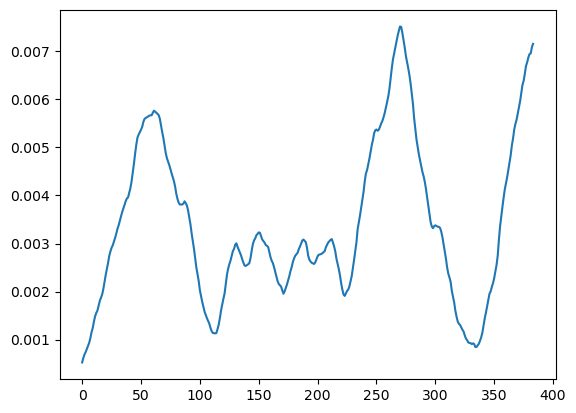

In [56]:
plt.plot(ne[1][:,0])

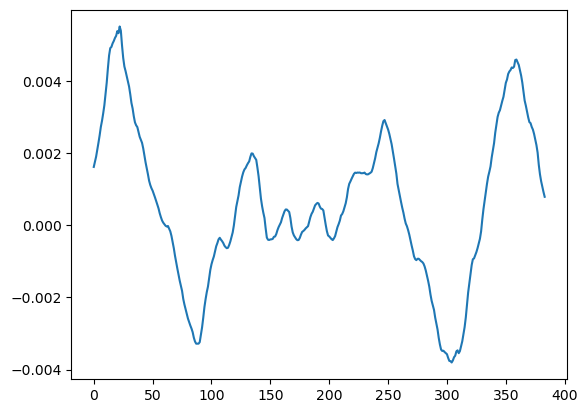

In [57]:
plt.plot(ne[1][:,1])

In [58]:
# evl = model.evaluate(tfGenEval)
# evl

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left
2023-03-27 12:34:54.774830: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-27 12:34:56.363762: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


     14/Unknown - 11s 313ms/step - loss: 3.9271e-06 - mae: 0.0014

14/14 [==============================] - 12s 339ms/step - loss: 3.9271e-06 - mae: 0.0014


[3.927097168343607e-06, 0.0014213809045031667]

In [59]:
p = model.predict(tfGenEval)
p *= 10.0
p.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


     14/Unknown - 7s 307ms/step

14/14 [==============================] - 7s 318ms/step


(5376, 2)

In [85]:
def getPastDataFromGen(genIn, predictedShapeIn):
    it = genIn.as_numpy_iterator()

    y_past_data = np.empty((predictedShapeIn[0], 2))
    i = 0

    try:
        while (ne := next(it)):
            #print(i)
            y_past_data[i:i+ne[1].shape[0],0] = ne[1][:,0]
            y_past_data[i:i+ne[1].shape[0],1] = ne[1][:,2]

            i += ne[1].shape[0]

    except StopIteration:
        pass

    return y_past_data
    
y_past_data = getPastDataFromGen(tfGenEval, p.shape)
y_past_data.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


(5376, 2)

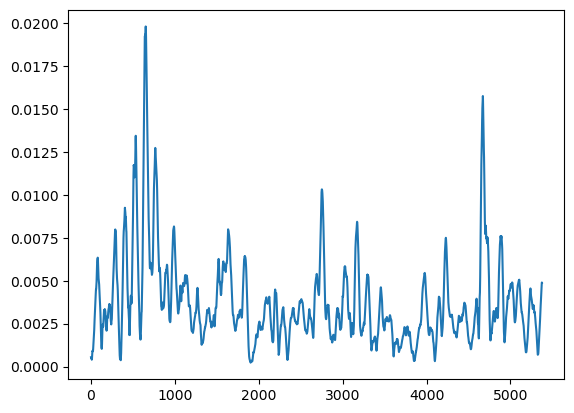

In [86]:
plt.plot(y_past_data[:,0])

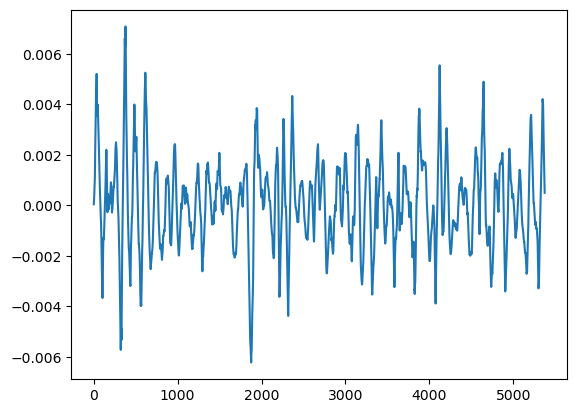

In [82]:
plt.plot(y_past_data[:,1])

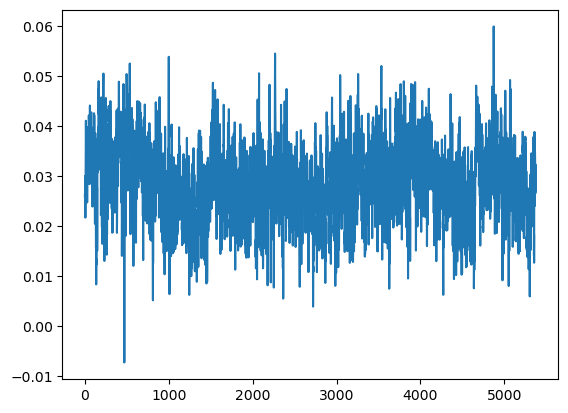

In [60]:
plt.plot(p[:,0])

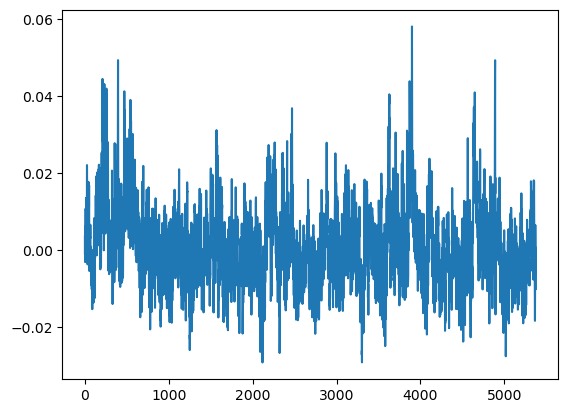

In [61]:
plt.plot(p[:,1])

In [62]:
p.shape

(5376, 2)

In [63]:
tickDF = pd.read_csv(TRAIN_FILES[1])
tickDF

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [64]:
tickDF.shape[0] - p.shape[0]

-55

In [65]:
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [68]:
# p_dir = p[:,0]
# p_dir_derivation = p[:,1]

p_future = p[:,0]
p_future_derivation = p[:,1]

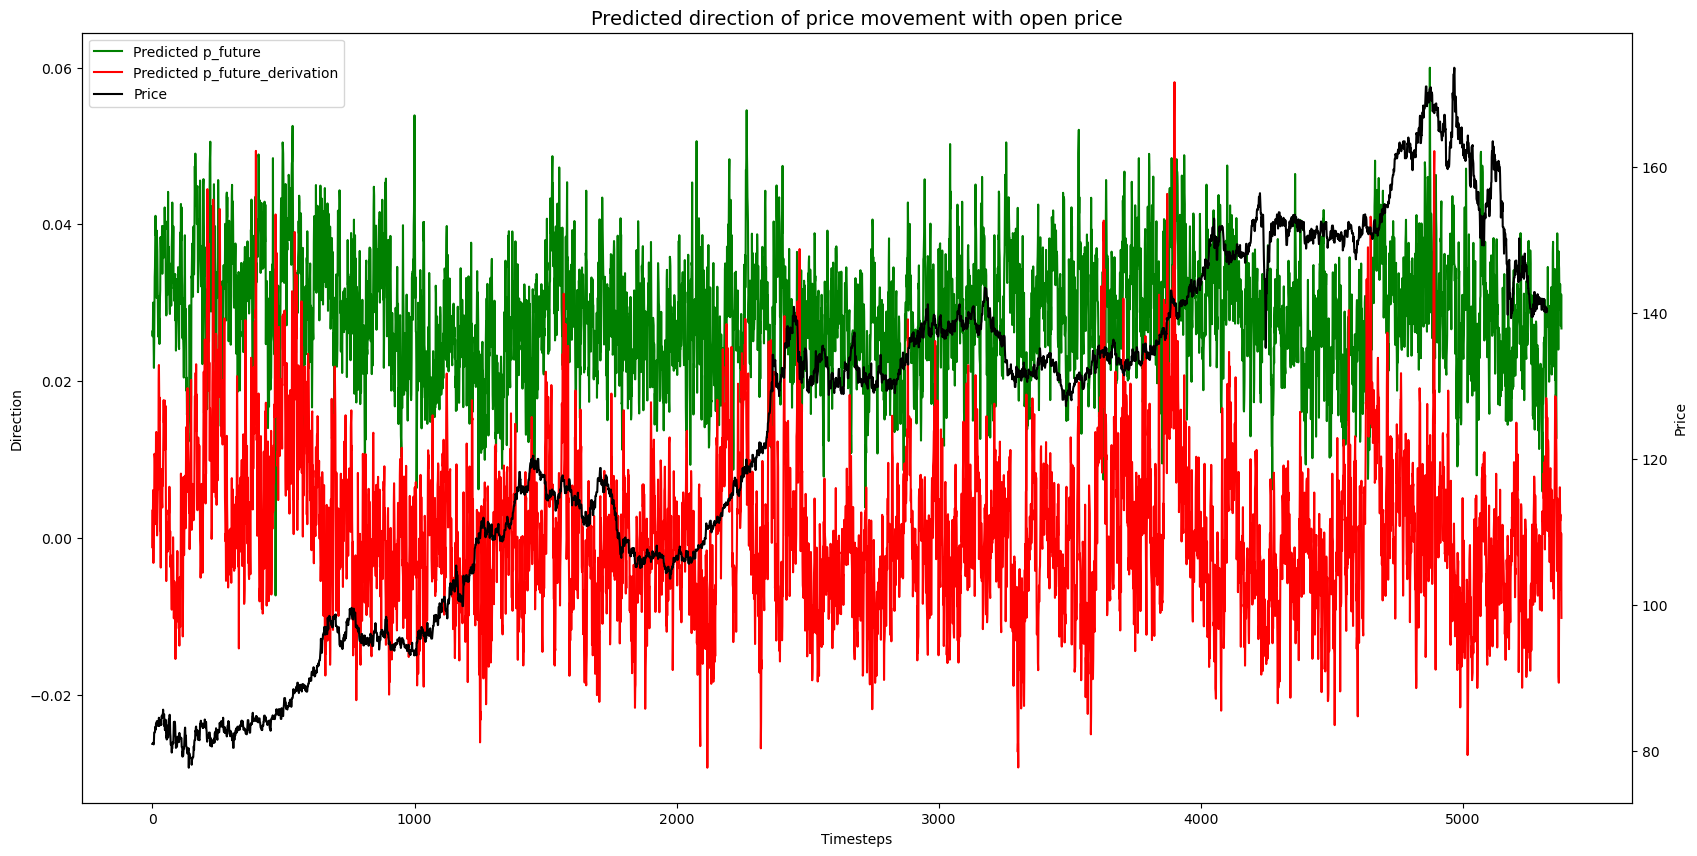

In [69]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_future, color="green", label="Predicted p_future")
_ = ax1.plot(p_future_derivation, color="red", label="Predicted p_future_derivation")
# _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [ ]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

In [ ]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_past_gain >= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables

In [ ]:
stop

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [87]:
# !mkdir /content/dataset/etffancy/FPNWithAttentionBigger_2_FutureOnly
# !mkdir /content/dataset/etffancy/FPNWithAttentionBigger_2_FutureOnly/test
# !mkdir /content/dataset/etffancy/FPNWithAttentionBigger_2_FutureOnly/eval

In [54]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

fileList = EVAL_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBigger_2_FutureOnly/eval"

# fileList = TEST_FILES
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBigger_2_FutureOnly/test"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 4)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]
        
        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
        
        # Add the predicted future gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain
        tickDFcropped.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation
        
        # Get the (known) past data
        y_past_data = getPastDataFromGen(tfGenEval, p.shape)

        # Add the past gain
        tickDFcropped.loc[:,"p_past_gain"] = y_past_data[:,0]
        tickDFcropped.loc[:,"p_past_gain_derivation"] = y_past_data[:,1]

        # Save the DF
        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                   | 0/266 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/etffancy/IE00B4KBBD01.csv' for index 0
INFO:root:File 'IE00B4KBBD01.csv' loaded, 0 left
2023-03-27 14:04:47.822336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-27 14:04:49.585821: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO:root:p.shape: (1536, 2)
  0%|▏                                          | 1/266 [00:06<30:36,  6.93s/it]INFO:root:
File name: '/content/dataset/etffancy/IE00B0M62Y33.csv' for index 1
INFO:root:File 'IE00B0M62Y33.csv' loaded, 0 left
INFO:root:p.shape: (5760, 2)
  1%|▎                                          | 2/266 [00:13<30:16,  6.88s/it]INFO:root:
File name: '/content/dataset/etffancy/IE00BHZPJ346.csv' for index 2
INFO:root:File 'IE00BHZPJ346.csv' loaded, 0 left
INFO:root:p.shape: (1152, 2)
  1%|▍       